# Identifying Processes Leading to Metastases

## Nevo Raz & Ofir Katz
April 2020

In [1]:
#basic data analysis packages
import numpy as np
import pandas as pd

#basic data visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

**Loading Data** From http://acgt.cs.tau.ac.il/multi_omic_benchmark/download.html (SKCM, clinical data) and gtex data

Description: 
- exp: gene expression data
- mirna: micro RNA (miRNA) data
- survival: specifying whether the patient sampled died or not
- clinical data -> melanoma: additional clinical information about the patient
- gtex: healthy people skin data (shared by Nimrod via gmail)

In [2]:
# load data
# description: 

"""
creating dict containing 
- filename (of data provided for the project)
- values: [fist column name, dataset name, separator]
"""

data = {'exp':['gene', 'gene_data', ' '], 
        'mirna': ['micro_rna', 'micro_rna_data', ' '],
        'gtex_data': ['ensemble_id', 'gtex_data', '\t']}

dataframes = {}

"""
load_dataframe will add relevant data to dataframes
"""

def load_dataframe(filename, values):
    title_row = pd.read_csv('{}.csv'.format(filename), header=None, nrows=1) #read table column names as row
    names = title_row.iloc[0, 0].replace('"', '').split(values[2]) #create colum title list
    if filename == 'gtex_data':
        names[0] = values[0]
    else:
        names = [values[0]] + names
    dataframes[values[1]] = pd.read_csv('{}.csv'.format(filename), names=names, skiprows=1, sep=values[2]) #read data    

for x in data.keys():
    load_dataframe(x, data[x])

In [3]:
# data exploration: delete irrelevant genes from data

# removing rows from 'exp' where genes begin in "X.." (following discussion with Nimrod, they are irrelevant)
dataframes['gene_data'] = dataframes['gene_data'][~dataframes['gene_data'].gene.str.contains("X..")] 

In [4]:
# data exploration: delete irrelevant samples from data

#sample types should be '01' or '06', but data exploration showed us that some other samples exist
def delete_irrelevant_samples(dataframe, title):
    sample_types = [x[-2:] for x in dataframe.columns[1:]]
    columns_to_remove = []
    for x in range(len(sample_types)):
        if sample_types[x] not in ['01', '06']:
            columns_to_remove.append(dataframe.columns[x + 1])
    print("removing following columns from {}:".format(title), columns_to_remove)
    dataframe = dataframe.drop(columns=columns_to_remove)
    return dataframe

dataframes['gene_data'] = delete_irrelevant_samples(dataframes['gene_data'], "gene expression data")
dataframes['micro_rna_data'] = delete_irrelevant_samples(dataframes['micro_rna_data'], "micro RNA data")

removing following columns from gene expression data: ['TCGA.D3.A1QA.07', 'TCGA.GN.A4U8.11']
removing following columns from micro RNA data: ['TCGA.D3.A1QA.07', 'TCGA.FW.A3R5.11', 'TCGA.GN.A4U8.11']


In [5]:
# create a copy of dataframes before normalization, to be later used for differential gene expression alaysis
not_normalized_dataframes = dataframes.copy()

In [6]:
# load survival data

"""
survival data needs to be loaded in a different way (based on data observation)
we will load it and add it to our dataframes dictionary (for consistency)

the column named "Death" has been renamed as "isDead" for clarity
"""
survival = pd.read_csv('survival.csv', names=['PatientID', 'Survival', 'isDead'], skiprows=1, sep='\t')

dataframes['survival_data'] = survival

In [7]:
# load clinical data data (clinical data -> melanoma)

"""
loading with python or excel: problem with rwos 38, 39!!

the data has a problem in line 38, 39:
they are series with 3 elements (total values: 105, unlike total 103 in other rows)
we discluded this data

we tried to load this data with RStudio but it didnt work
"""

clinical_titles = pd.read_csv('melanoma.txt', header=None, nrows=1) 
clinical_data_titles = clinical_titles.iloc[0, 0].split('\t')

clinical_data = pd.read_csv('melanoma.txt', header=None, names=clinical_data_titles, skiprows=[0, 38,39], sep='\t') 

dataframes['clinical_data'] = clinical_data

# Normalize Data

**Normalize Gene Expression and Micro RNA Data**

Steps: 
1. perform log2(val + 1)
3. remove features with low variance (we chose to remove values with variance below the 45th percentile, but this as a parameter that can be changed)
4. subtract mean and divide by std

**Normalize GTEX data**

Steps: 
1. check if data is normalized or partially normalized (--> we discovered the mean was already 0, the std was not 1)
2. normalize if necessary based on missing steps (--> the step left was only divide by std)

**<u>Gene Expression and Micro RNA Normalization</u>**

In [8]:
def perform_log(dataframe, column_name):
    # perform log2 (val+1)
    dataframe = dataframe.apply(lambda x: np.log2(x + 1) if x.name != column_name else x)
    return dataframe

def plot_relationship_between_mean_and_std(dataframe, title):
    mean_vals = dataframe.mean(axis=1) #these are the expected values 
    std_vals = dataframe.std(axis=1) #this is the variance
    plt.figure(figsize=(7, 7)) # set figure size
    plt.title("plotting relationship between mean (after log) and std: {}".format(title)) # set title
    plt.xlabel('mean (log)') # label x axis
    plt.ylabel('standard deviation') # label y axis
    plt.scatter(mean_vals, std_vals)
    plt.show()
    
    
def remove_low_variance_features(dataframe, percentile_to_remove):
    # find variance per row
    dataframe['std'] = dataframe.std(axis=1)
    # find relevant quantile for variance column
    quantile_value = dataframe['std'].quantile(percentile_to_remove)
    # retain only rows with variance greater than selected quantile
    dataframe = dataframe[dataframe['std'] > quantile_value]
    # drop current varinace column in order to not interfere in future calcuations on full rows
    dataframe = dataframe.drop(['std'], axis=1)
    return dataframe

def subtract_mean_divide_std(dataframe):
    # find mean per row
    mean_vals = dataframe.mean(axis=1) #these are the expected values
    # find std per row
    std_vals = dataframe.std(axis=1) #this is the variance
    # subtract means and divide by std
    dataframe.iloc[:, 1:] = dataframe.iloc[:, 1:].subtract(mean_vals, axis=0).divide(std_vals, axis=0)
    return dataframe    

"""
normalize data gets 
- a dataframe
- the name of the first column of the dataframe
- the percentile of variance values below which to remove features (to remove features with low variance)
- the tilte to add to the graph of mean (log) vs std
"""
def normalize_data(dataframe, column_name, percentile_to_remove):
    dataframe = perform_log(dataframe, column_name)
    dataframe = remove_low_variance_features(dataframe, percentile_to_remove)
    dataframe = subtract_mean_divide_std(dataframe)
    return dataframe

def log_and_plot(dataframe, column_name, title):
    x = perform_log(dataframe, column_name)
    plot_relationship_between_mean_and_std(x, title)
    

# check if datasets are normalized
def check_if_normalized(dataframe, data_description):
    print("checking {}:".format(data_description))
    max_mean = round(dataframe.mean(axis = 1), 1).max()
    min_mean = round(dataframe.mean(axis = 1), 1).min()
    max_std = round(dataframe.std(axis = 1), 1).max()
    min_std = round(dataframe.std(axis = 1), 1).min()
    # max/min mean values
    print("\nmean:")
    print("max value: ", max_mean)
    print("min value: ", min_mean)
    # max/min std values
    print("\nstd:")
    print("max value: ", max_std)
    print("min value: ", min_std)
    if max_mean == 0 and min_mean == 0:
        print("\nmean result is correct")
    else:
        print("\nmean result is not correct")
    if max_std == 1 and min_std == 1:
        print("\nstd result is correct")
    else:
        print("\nstd result is not correct")
        


In [9]:
dataframes['gene_data'] = normalize_data(dataframes['gene_data'], 'gene', 0.45)
dataframes['micro_rna_data'] = normalize_data(dataframes['micro_rna_data'], 'micro_rna', 0.45)

In [10]:
check_if_normalized(dataframes['gene_data'], "gene expression data")

checking gene expression data:

mean:
max value:  0.0
min value:  0.0

std:
max value:  1.0
min value:  1.0

mean result is correct

std result is correct


**<u>GTEX Normalization</u>**

In [11]:
# check if gtex is normalized

check_if_normalized(dataframes['gtex_data'], "gtex data")

checking gtex data:

mean:
max value:  -0.0
min value:  -0.0

std:
max value:  1.4
min value:  0.0

mean result is correct

std result is not correct


In [12]:
# these results mean that we have to partially normalize gtex_data: we'll divide each row by its std

def normalize_gtex(dataframe):
    std_vals = dataframe.std(axis=1)
    dataframe.iloc[:, 1:] = dataframe.iloc[:, 1:].divide(std_vals, axis=0)
    return dataframe    

dataframes['gtex_data'] = normalize_gtex(dataframes['gtex_data'])

In [13]:
# check if gtex is normalized now
check_if_normalized(dataframes['gtex_data'], "gtex data")

checking gtex data:

mean:
max value:  -0.0
min value:  -0.0

std:
max value:  1.0
min value:  1.0

mean result is correct

std result is correct


# Main Methods Used In This Project

**CLUSTERING**

**What is clustering?**
Clustering is a technique to group similar data points in a way that places more similar points in the same group.
A cluster is a group of similar points. In the following project we will use the <u>Hierarchical Clustering</u> method.

**Hierarchical Clustering**

There are 2 types of hierarchical clustering, agglomerative and divisive.
- <u>agglomerative</u>: data points are clustered using a bottom-up approach starting with individual data points
- <u>divisive</u>: data points are clustered using top-down approach 

In this project, we will use the agglomerative technique: the clustering works as follows:
1. Each data point will be considered a separate cluster (we will have k clusters for k data points)
2. The two closest data points will be joined, creating k-1 clusters
3. Keep iteratively joining the two closest clusters until we get one cluster

The clustering results can be visualized using a **dendrogram**

**Hierarchical Clustering Methods:**

we will describe 3 methods, that according to our research are the most commonly used methods in studies, though more methods exist:

1. <u>complete/max/farthest neighbor</u>: the distance between two clusters is defined as the longest distance between two points in each cluster.
2. <u>average</u>: the distance between two clusters is defined as the average distance between each point in one cluster to every point in the other cluster.
3. <u>ward/minimal increase of sum-of-squares</u>: uses ward's method: similar to average, but using the sum of the square of the distances. Proximity between two clusters is the magnitude by which the summed square in their joint cluster will be greater than the combined summed square in these two clusters.

<u>How can we select a method to use?</u>
- One possibility is to use the to calculate the cophenet, because the correlation between the distance matrix and the cophenetic distance can help suggest clustering method to choose. We want to select the method where the correlation between the original distances and the cophenetic distances is high.

<u>Which packages will we use for the analysis?</u>
- we used scipy for selecting a clustering method, performing hierarchical clustering and displaying a dendrogram

**PCA**

**What is PCA?** 
- Principal Component Analysis (PCA) is a statistical procedure used to convert a set of observations with multiple dimensions (features, variables) that might be correlated into a group of linearly uncorrelated variables (principal components) using orthogonal transformation.
- The variables are transformed into a new set of variables, known as principal components (PCs) that ar orthogonal and ordered in a way where the variation present in the PCs decrease as we move from the 1st PC to the last one
- PCA is an unsupervised method and it’s difficult to interpret the features used to create the main resulting PCs as they are some complex mixture of the original features.

Without getting into math, PCA works as follows:
1. Normalize the data
2. Calculate a matrix that summarizes how our variables are related (the covariance matrix)
2. Break the matrix down into separate components of direction and magnitude
3. Transform the original data to align with the important directions we found


<u>How can we select the number of principal components to use in our calculation?</u>
- When we graph, we can use only 2 PCs for a 2D graph and 3 PCs for a 3D graph
- However, we need to select a relevant number of components to be used in our calculation
- Various methods exist to select, we will plot the cumulative explained variance per component and select a number of components before where the graph slope becomes relatively steady


<u>Which packages will we use for the analysis?</u>
- we used sklearn for performing PCA

**DIFFERENTIAL EXPRESSION ANALYSIS**

**What is Differential Expression Analysis?**:
- Differential gene expression analysis is a group of statistical tests used to determine if per gene there is a significant variation across a set of tested conditions. 
- These tests can be used to compare between expression in two groups of samples, for example: a comparison between expression in primary (01) samples vs metastases samples (06) or a comparison between healthy skin samples (gtex) vs tumor samples (tcga gene expression)
- We will use differential expression analysis for analyzing gene expression and micro RNA expression
    
We selected to use 2 different methods for DE Analysis:
- **Welch's t-tests**: a two-sample location test which is used to test the hypothesis that two populations have equal means.
- **Rank Sum tests**: a test based on ranking observations of the combined samples so that each observation gets a rank (1 for the smallest, 2 for then next, and so on), and the rank-sum test statistic is the sum of the ranks for observations from one of the sample types.


**How do we define a highly-expressed/slightly-expressed gene?**
- To determine if a gene has been significantly expressed, we will use genes/miRNAs where:
    - **P-value: is less than 0.01** (this was an arbitrary selection because we got *a lot* of results for 0.05)
    - **log2FoldChange:** we read that fold-change of **+/- 2** is often used as the threshold for defining significant differential expression, therefore we will use a minimum of log fold-change +2 to define highly-expressed genes and a maximum of -2 to define slightly expressed genes. However, we will select actual values to use by examining an MA-Plot and seeing outlying values graphically. (specifically, we noticed that with our data, the limits of -7.5/+7.5 were actually better in many cases)
- When we say a gene/miRNA is highly/slightly expressed, we mean that we got it as a result from t-test, rank sum tests, or both. After we perform each test, we combine the results in order to get a more robust result.

<u>Which packages will we use for the analysis?</u>
- differential expression analysis using diffxpy (installation instructions: https://github.com/theislab/diffxpy/blob/master/docs/installation.rst)

# Data Analysis

Research Questions and Analysis Methodology:

<u>Question # 1</u>

**Question: If we look at gene expression data of primary tumors and metastases together, is there a clear distinction between them? Does such a distinction exist for micro RNA?**

***Analysis Description:*** <br />
<u>General Description:</u> In order to find a distinction between primary tumors and metastases, we will attempt to cluster our data by sample to create clusters of primary samples ('01') and clusters of metastases samples ('06'), using hierarchical clustering. We will then perform PCA and graph the results of clustering on the main PCs, so that we can visually compare plots of actual primary/metastases samples to plots as a result of cluestering. If we find similar results, we will have found a clear distinction between primary and metastases samples. <br />

The following process was be performed once with normalized gene expression data and once with normalized miRNA expression data.<br />
- A method for hierarchical clustering was selected by comparing the cophenet of 3 possible methods: 'ward', 'complete', 'average'
- Clustering was performed by sample (01, 06 samples) using 2 separate methods
- Results of clustering were displayed using a dendrogram (a useful tool to display biological clustering)
- Results of clustering were analyzed as follows:
    - Clustering results were examined for k # of clusters = [2, 4, 10, 15, 25, / 35, 45] (additionals for miRNA)
    - Per k, each cluster was examined:
        - We checked if the cluster has resulted in a higher percent of actual 01 samples / actual 06 samples
        - Based on the analysis, we defined each cluster as 'primary', 'metastases' or 'unknown'
- We selectd one of the clustering methods for a specific k for further analysis 
    - for gene expression: k = 25, method = 'complete'
    - for miRNA: k = 45, method = 'ward'
- We displayed the data matrix graphically as a scatter plot in 2D (this shouldn't make much sense because data is multi-dimensional, but gives a good understanding of data point types and the quality of clustering)
    1. one graph is displayed by actual 01/06 sample
    2. one graph is displayed by cluster
    3. one graph is displayed by 01/06 sample **based on clustering results**
- We performed PCA to find new axis (PC1, PC2, PC3) to display our data on
    - we normalized the data so that all data points are between 0 and 1
    - we performed analysis of a how many components to use for the PCA
    - we performed PCA for number of components selected
        - for gene expression: n_components = 300
        - for miRNA: n_components = 250
    - we calculated the explained variance % per PC and specifically examined the % for PCs 1, 2 and 3
    - we graphed the data in 2D (PC1 as x, PC2 as y) and in 3D ((PC1 as x, PC2 as y, PC3 as z)
        1. one graph section displayed the data points colored by actual sample type (primary, metastases) based on sample name 
        2. one graph section displayed the data points colored by cluster
        3. one graph section displayed the data points colored by cluster sample type (primary, metastases, unknown) **based on clustering results**
   
   
***Conclusion:*** <br />
The clustering process proved difficult as there were few primary samples compared to metastases samples. However,
- For gene expression data, our clustering into k=15 clusters gave relatively good results, and clustering into k=25 clusters gave even better results. Graphing on main PCs shows us that some areas of actual 01 samples are well recognized by our clustering, specifically the top right area of the 3D PCA graph. In our opinion, the distinction between primary and metastases samples was pretty good considering the small number of 01 samples.
- For micro rna expression data, our clustering into small ks resulted in very few distinctly primary clusters. In order to create relatively good graphical results, we had to use large ks, such as k=45. While the results for this k looked better, there is a high risk of overfitting in this case, so in our opinion the distinction between primary and metastases samples was not very good. 

In [14]:
# imports for hierarchial clustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet
from scipy.spatial.distance import pdist

# imports for PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# imports for plotting
import plotly.graph_objs as go
import plotly.offline as offline
from mpl_toolkits.mplot3d import Axes3D  

Question 1: Gene Expression Analysis

In [15]:
#transpose data to get a matrix of samples for rows, dimensions (genes) for columns

def transform_data(dataframe):
    a = dataframe.T
    a.columns = a.iloc[0]
    a = a.iloc[1:, :]
    X = a.to_numpy() # convert a to numpy array (no row, column names) because algos we will use need this
    return a, X
    
a, X = transform_data(dataframes['gene_data'])

a.head()

gene               A1BG.1 A2BP1.54715 A2LD1.87769 A2ML1.144568     A2M.2  \
TCGA.3N.A9WB.06  0.703106   -0.413022     1.75643     0.219317  -2.15274   
TCGA.3N.A9WC.06 -0.271476   -0.413022     1.03666    -0.712711   1.85089   
TCGA.3N.A9WD.06  0.623738     2.57316    0.220533    -0.712711 -0.204097   
TCGA.BF.A1PU.01 -0.418624    0.830254     1.06153     0.246341  -1.12695   
TCGA.BF.A1PV.01 -0.118319   -0.413022   -0.534805    -0.505992  -2.37279   

gene            A4GALT.53947 AACSL.729522 AADACL2.344752 AADACL3.126767  \
TCGA.3N.A9WB.06      -1.0512    -0.634155       0.939575       -0.16196   
TCGA.3N.A9WC.06     0.140153    -0.415142      -0.344445       -0.16196   
TCGA.3N.A9WD.06     0.816695   -0.0611561      -0.344445       -0.16196   
TCGA.BF.A1PU.01     0.450017    -0.634155       0.260928       -0.16196   
TCGA.BF.A1PV.01    -0.964558    -0.634155      -0.344445       -0.16196   

gene            AADAC.13  ... ZSCAN18.65982 ZSCAN1.284312 ZSCAN23.222696  \
TCGA.3N.A9WB.06 -0.53831  ...     -0.690519     -0.697552       -1.12202   
TCGA.3N.A9WC.06 -0.53831  ...       1.47795     0.0771556      -0.366684   
TCGA.3N.A9WD.06 -0.53831  ...       1.32464      0.463101      -0.571297   
TCGA.BF.A1PU.01 -0.53831  ...       1.16722     -0.327994       0.474251   
TCGA.BF.A1PV.01 -0.53831  ...       1.14218     -0.353843       -1.17547   

gene            ZSCAN4.201516 ZSCAN5A.79149 ZSCAN5B.342933 ZSWIM5.57643  \
TCGA.3N.A9WB.06      -0.64468      -1.51789       -1.15626    0.0902101   
TCGA.3N.A9WC.06      -0.64468      0.113756      -0.628801    -0.580616   
TCGA.3N.A9WD.06     0.0615025      0.738158       0.223716      1.56847   
TCGA.BF.A1PU.01      -0.64468     -0.661544       -1.15626     0.201055   
TCGA.BF.A1PV.01      -0.64468     0.0867665      -0.747601     -1.92418   

gene            ZUFSP.221302 ZYG11A.440590 psiTPTE22.387590  
TCGA.3N.A9WB.06    -0.141193        0.9863        -0.876562  
TCGA.3N.A9WC.06    0.0554014     -0.435242        -0.520554  
TCGA.3N.A9WD.06     0.104382       1.63676          2.47852  
TCGA.BF.A1PU.01    0.0906005     -0.985369        -0.929176  
TCGA.BF.A1PV.01    -0.216158     -0.985369         -1.14425  

[5 rows x 10650 columns]

In [16]:
# defining sample labels with only "06", "01" for clarity     
samples_label_list = [x[-2:] for x in list(a.index)]

In [17]:
# selecting clustering methods for use

def select_clustering_method(data_matrix, method_list):
    print("method; cophenet;")
    for method in method_list:
        l = linkage(data_matrix, method=method)
        c, coph_dists = cophenet(l, pdist(data_matrix))
        print(method, c)

select_clustering_method(X, ['complete', 'average', 'ward'])
    
# select optimal linkage method: chopenet should be closest to 1   
# methods selected: 'complete' and 'average'

method; cophenet;
complete 0.5378570666061107
average 0.7461720517220348
ward 0.4547375338222622


In [18]:
# cluster gene expression by samples (primary vs metastases) and plot resulting dendrogram

def cluster_by_sample_and_plot_dendrogram(data, labels, method):
    plt.figure(figsize=(25, 10)) # define figure size
    plt.title('Hierarchical Clustering Dendrogram, Method: {} - Cluster By Sample'.format(method.capitalize())) # add figure title
    plt.xlabel('samples') # label x axis
    plt.ylabel('distance') # label y axis
    samples_dist = pdist(data) # computing the distance
    samples_link = linkage(samples_dist,  metric='correlation', method=method) # computing the linkage
    dendrogram(samples_link,labels=labels)
    plt.show()
    return samples_link # return the linkage, it is needed for additional functions

# divide sample results of dendrogram into k clusters
def divide_samples_into_clusters(k, samples_link, samples_label_list):
    fl = fcluster(samples_link, k,criterion='maxclust') # list leaves by cluster      
    sample_clusters = fl.tolist() # sample_clusters will be a list of cluster numbers (1-k)
    sample_cluster_dict = {} # based on cluster results, create dict mapping to a list of samples in each cluster
    for num in range(1, k+1):
        sample_cluster_dict[num] = [] # initialize k empty lists in dict
    for x in range(len(sample_clusters)):
        sample_cluster_dict[sample_clusters[x]].append(samples_label_list[x]) # add the relevent label from samples_label_list to cluster list
    return sample_cluster_dict

# for each cluster, check if it is mostly 01 or 06 and print out results
def analyze_sample_clusters(sample_cluster_dict):
    print("\nk = {}".format(len(sample_cluster_dict)))
    print("cluster\t\tcluster_type\t\tprimary_cases\tmetastases_cases\ttotal_cases")   
    for key in sample_cluster_dict.keys(): # perform per cluster
        num_01 = num_06 = 0
        for element in sample_cluster_dict[key]: # count 01, 06 elements in cluster
            if element == '01':
                num_01+= 1
            elif element == '06':
                num_06+= 1
        total = num_01 + num_06 # total number of elements in cluster
        if total > 0:
            num_01 = (num_01/total)*100 # percent of 01 in cluster
            num_06 = (num_06/total)*100 # percent of 06 in cluster
            if round(num_01, 2) > round(num_06, 2): # greater percent of 01 is primary clsuter
                cluster_type = 'primary (01)'
            elif round(num_01, 2) < round(num_06, 2): # greater percent of 06 is metastases clsuter
                cluster_type = 'metastases (06)'
            else: # if the percent is equal, this cluster type is unknown
                cluster_type = 'unclear    '
            print("{}\t\t{}\t\t{}%\t\t{}%\t\t\t{}".format(key, cluster_type, round(num_01, 2), round(num_06, 2), total))

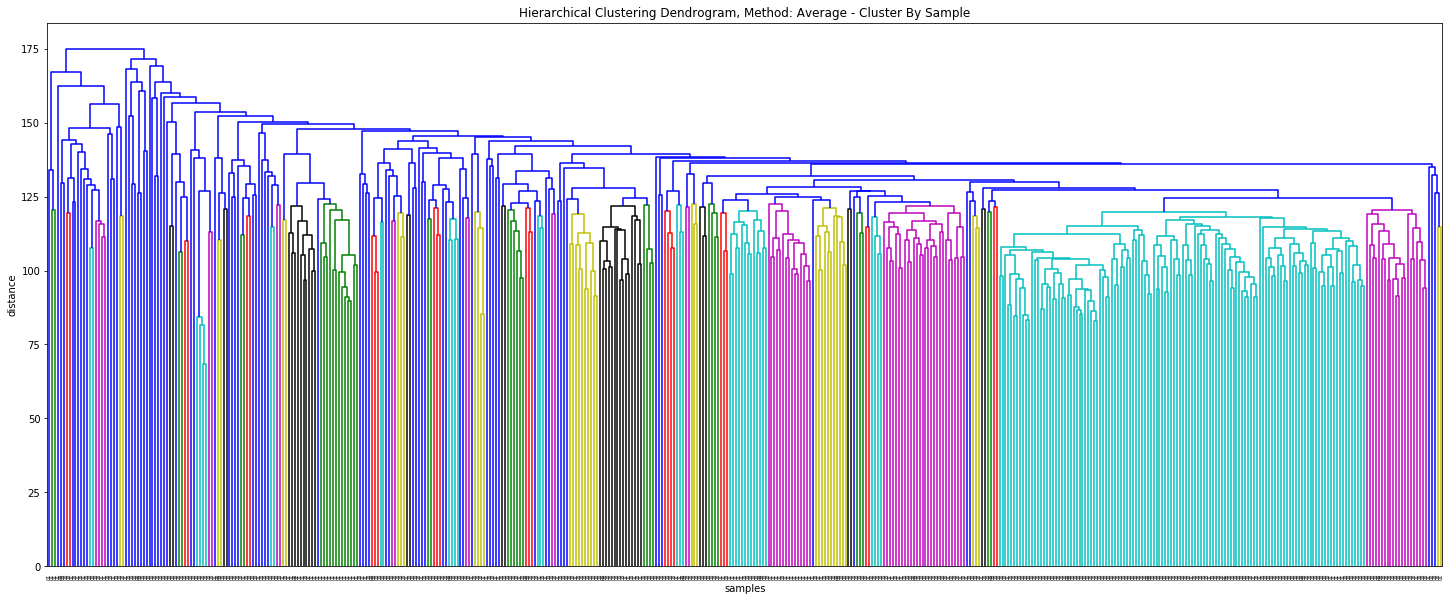


k = 2
cluster		cluster_type		primary_cases	metastases_cases	total_cases
1		metastases (06)		38.46%		61.54%			26
2		metastases (06)		20.9%		79.1%			445

k = 4
cluster		cluster_type		primary_cases	metastases_cases	total_cases
1		metastases (06)		38.46%		61.54%			26
2		metastases (06)		12.5%		87.5%			8
3		metastases (06)		21.1%		78.9%			436
4		metastases (06)		0.0%		100.0%			1

k = 10
cluster		cluster_type		primary_cases	metastases_cases	total_cases
1		primary (01)		100.0%		0.0%			3
2		metastases (06)		27.27%		72.73%			22
3		primary (01)		100.0%		0.0%			1
4		metastases (06)		0.0%		100.0%			3
5		metastases (06)		0.0%		100.0%			2
6		metastases (06)		0.0%		100.0%			2
7		primary (01)		100.0%		0.0%			1
8		metastases (06)		0.0%		100.0%			3
9		metastases (06)		21.25%		78.75%			433
10		metastases (06)		0.0%		100.0%			1

k = 15
cluster		cluster_type		primary_cases	metastases_cases	total_cases
1		primary (01)		100.0%		0.0%			3
2		metastases (06)		31.58%		68.42%			19
3		metastases (06)		0.0%		100.0

In [19]:
### Clustering with 'average' method ###

# cluster and plot dendrogram with 'average' method
samples_link = cluster_by_sample_and_plot_dendrogram(X, samples_label_list, 'average')

# choose best k for 'average' clustering:
for k in [2, 4, 10, 15, 25]:
    sample_cluster_dict = divide_samples_into_clusters(k, samples_link, samples_label_list)
    analyze_sample_clusters(sample_cluster_dict)

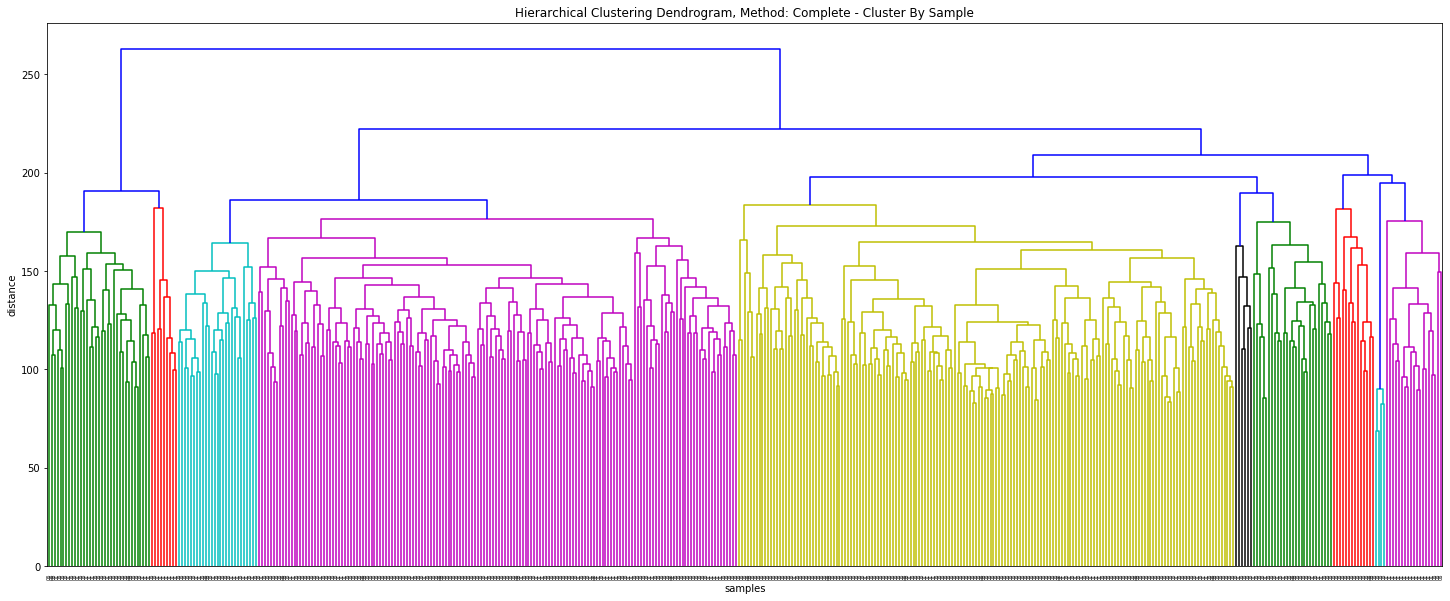


k = 2
cluster		cluster_type		primary_cases	metastases_cases	total_cases
1		metastases (06)		38.64%		61.36%			44
2		metastases (06)		20.14%		79.86%			427

k = 4
cluster		cluster_type		primary_cases	metastases_cases	total_cases
1		metastases (06)		38.64%		61.36%			44
2		metastases (06)		22.22%		77.78%			189
3		metastases (06)		13.93%		86.07%			201
4		metastases (06)		43.24%		56.76%			37

k = 10
cluster		cluster_type		primary_cases	metastases_cases	total_cases
1		metastases (06)		28.57%		71.43%			35
2		primary (01)		77.78%		22.22%			9
3		metastases (06)		33.33%		66.67%			27
4		metastases (06)		20.37%		79.63%			162
5		metastases (06)		11.9%		88.1%			168
6		metastases (06)		16.67%		83.33%			6
7		metastases (06)		25.93%		74.07%			27
8		metastases (06)		0.0%		100.0%			14
9		metastases (06)		0.0%		100.0%			4
10		primary (01)		84.21%		15.79%			19

k = 15
cluster		cluster_type		primary_cases	metastases_cases	total_cases
1		metastases (06)		28.57%		71.43%			35
2		metastases (06)		0.0%		100.0%			

In [20]:
### Clustering with 'complete' method ###

# cluster and plot dendrogram with 'complete' method
samples_link = cluster_by_sample_and_plot_dendrogram(X, samples_label_list, 'complete')

# choose best k for 'complete' clustering:
for k in [2, 4, 10, 15, 25]:
    sample_cluster_dict = divide_samples_into_clusters(k, samples_link, samples_label_list)
    analyze_sample_clusters(sample_cluster_dict)

In [21]:
# select clustering method

# set chosen k based on previous analysis and chosen method
k = 25

# define clusters
clusters = fcluster(samples_link, k, criterion='maxclust')

In [22]:
# scatter plot of clusters

# this function takes a data matrix and plots its points
# results shouldn't make much sense because we have many dimensions!
def scatter_plot_samples(data, color_values, title):
    plt.figure(figsize=(25, 7)) # set figure size
    plt.title(title) # set title
    plt.xlabel('genes expression value') # label x axis
    plt.ylabel('samples') # label y axis
    plt.scatter(data[:,0], data[:,1], c=color_values, cmap='prism')
    plt.show()

In [23]:
def define_cluster_types(dataset, k, samples_link, clusters):
    samples_full_label_list = list(dataset.index)
    sample_cluster_dict = divide_samples_into_clusters(k, samples_link, samples_full_label_list)    
    cluster_types = []
    for key in sample_cluster_dict.keys():
        num_01 = num_06 = 0
        for element in sample_cluster_dict[key]:
            if element[-2:] == '01':
                num_01+= 1
            elif element[-2:] == '06':
                num_06+= 1
        total = num_01 + num_06
        if total > 0:
            num_01 = (num_01/total)*100
            num_06 = (num_06/total)*100
            if round(num_01, 2) > round(num_06, 2):
                cluster_types.append((key, 'primary'))
            elif round(num_01, 2) < round(num_06, 2):
                cluster_types.append((key, 'metastases'))
            else: 
                cluster_types.append((key, 'unknown'))
    primary_metastases_cluster_list = []
    for cluster in clusters:
        if cluster_types[cluster-1][1] == 'primary':
            primary_metastases_cluster_list.append(1)
        elif cluster_types[cluster-1][1] == 'metastases':
            primary_metastases_cluster_list.append(6)
        else:
            primary_metastases_cluster_list.append(0)
    return cluster_types, primary_metastases_cluster_list

cluster_types, primary_metastases_cluster_list = define_cluster_types(a, k, samples_link, clusters)
primary_metastases_clusters = np.asarray(primary_metastases_cluster_list, dtype=np.int32)

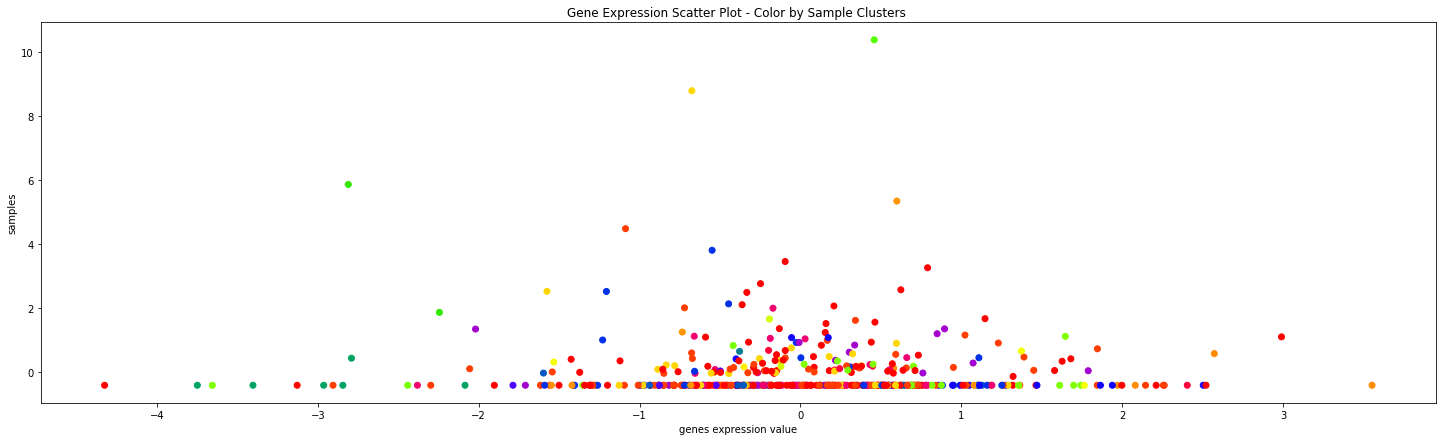

In [24]:
# 1. plot points with color by cluster
scatter_plot_samples(X, clusters, 'Gene Expression Scatter Plot - Color by Sample Clusters ')

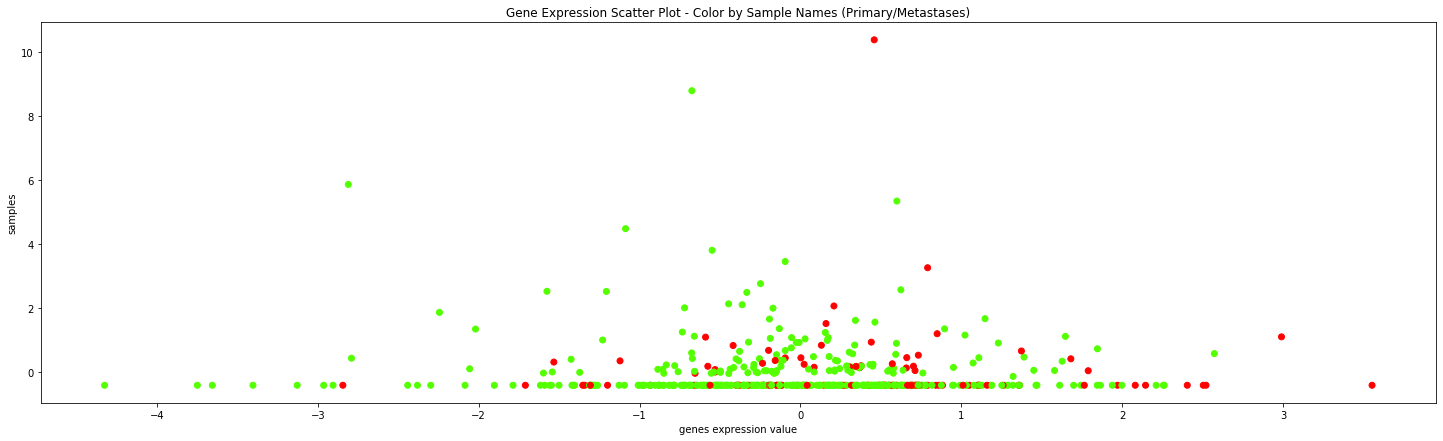

In [25]:
# 2. plot points with color by sample name (01 or 06) (actual tumor type: primary or metastases)

color_values = np.asarray(samples_label_list, dtype=np.int32)
scatter_plot_samples(X, color_values, 'Gene Expression Scatter Plot - Color by Sample Names (Primary/Metastases)')


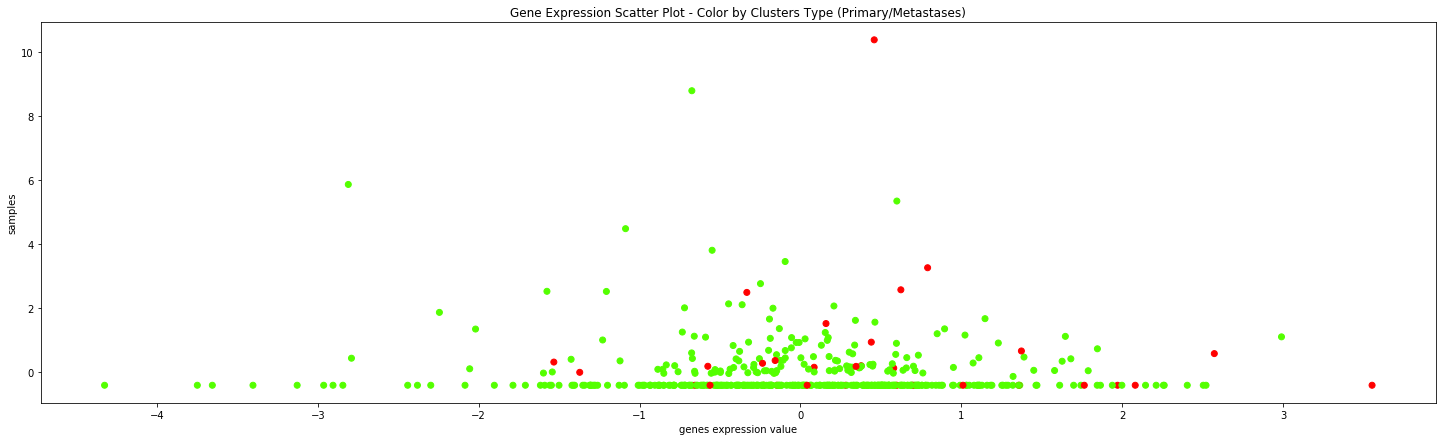

In [26]:
# 3. plot points with color by cluster tumor type (tumor typea as a result of clustering)
scatter_plot_samples(X, primary_metastases_clusters, 'Gene Expression Scatter Plot - Color by Clusters Type (Primary/Metastases)')

In [27]:
# Perform PCA in order to display data points on PCs

In [28]:
# normalize data to values between 0 and 1

scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(X)

print("data has been rescaled")
print("after rescaling: min={}, max={}".format(round(data_rescaled.min(), 2), round(data_rescaled.max(), 2)))

data has been rescaled
after rescaling: min=0.0, max=1.0


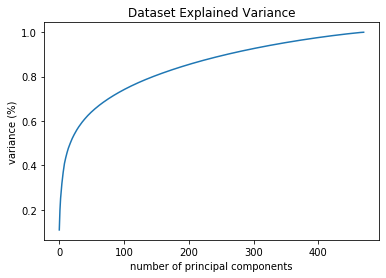

based on graph: selecting 300 principal components that appear to account for 90% of the variance


In [29]:
# Select number of principal components to use for PCA

# the function plots the explained variance for each attribute
def plot_explained_variance(data):
    pca = PCA().fit(data_rescaled) # fitting PCA with our data
    #Plotting the Cumulative Summation of the Explained Variance
    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of principal components')
    plt.ylabel('variance (%)') #for each component
    plt.title('Dataset Explained Variance')
    plt.show()
    
plot_explained_variance(data_rescaled)

# based on this graph we need to decide how many principal components to use
# we will not select the maximum possible, in order to preserve only principal components
# however, we want to select a number of components where the graph slope is not very big

# we will decide to use 300 principal components

print("based on graph: selecting 300 principal components that appear to account for 90% of the variance")

In [30]:
# functions for PCA and understanding explained varinace of PCs

def plot_explained_variance_and_cumsum(components, var_exp, cum_var_exp):
    # plot the explained variance
    x = ["PC%s" %i for i in range(1, components)]
    trace1 = go.Bar(x = x , y = list(var_exp), name = "explained variance")
    trace2 = go.Scatter(x = x, y = cum_var_exp, name = "cumulative variance")
    layout = go.Layout(title = 'Explained Variance', xaxis = dict(title = 'principle components', tickmode = 'linear'))
    data = [trace1, trace2]
    fig = go.Figure(data = data, layout = layout)
    offline.iplot(fig)
    
def perform_pca_and_plot_explained_variance(original_data, rescaled_data, components):
    pca = PCA(n_components=components) 
    dataset = pca.fit_transform(rescaled_data)
    Y = pca.fit(original_data)
    var_exp = Y.explained_variance_ratio_
    cum_var_exp = np.cumsum(var_exp)
    plot_explained_variance_and_cumsum(components, var_exp, cum_var_exp)
    return dataset

In [31]:
# perform PCA with 300 components

components = 300

print("plotting the explained variance per principal component")
dataset = perform_pca_and_plot_explained_variance(X, data_rescaled, components)

# based on the graph, we can see that: 
# PC1 + PC2 are responsible for nearly 21% of the explained variance
# PC1 + PC2 + PC3 are responsible for nearly 26% of the explained variance
# we will use these 3 PCs to graph the points on these axis

plotting the explained variance per principal component


In [32]:
# PC1 + PC2 are responsible for 21% of the explained variance

In [33]:
def add_cluster_info_to_dataset(a, clusters, cluster_types):
    a['tumor_type'] = np.asarray(['primary' if x[-2:] == '01' else 'metastases' for x in list(a.index)])
    a['cluster'] = clusters
    a['tumor_type_by_clustering'] = np.asarray([cluster_types[x-1][1] for x in clusters])
    
add_cluster_info_to_dataset(a, clusters, cluster_types)

In [34]:
# plotting graphs with PCs as axes


def plot_2D(dataset, labels, colors, labl, title, marker=None, alpha=None):
    # Plot PCA1 and PCA2 by primary, metastases (samples)
    Xax = dataset[:,0]
    Yax = dataset[:,1]
    labels = labels
    cdict = colors
    labl = labl
    if marker and alpha:
        marker = marker
        alpha = alpha
    fig,ax=plt.subplots(figsize=(10,10))
    fig.patch.set_facecolor('white')
    for l in np.unique(labels):
        ix=np.where(labels==l)
        if marker and alpha:
            ax.scatter(Xax[ix], Yax[ix], c = cdict[l], s = 40, label = labl[l], marker = marker[l], alpha = alpha[l])
        else:
            ax.scatter(Xax[ix], Yax[ix], s = 40, label = labl[l])
    plt.xlabel("first principal component (PC1)")
    plt.ylabel("second principal component (PC2)")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_3D(dataset, labels, colors, labl, title, marker=None, alpha=None):
    # Plot PCA1, PCA2 and PCA3 by clusters for k
    Xax = dataset[:,0]
    Yax = dataset[:,1]
    Zax = dataset[:,2]
    labels = labels
    cdict = colors
    labl = labl
    if marker and alpha:
        marker = marker
        alpha = alpha
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(10)
    ax = fig.add_subplot(111, projection='3d')
    fig.patch.set_facecolor('white')
    for l in np.unique(labels):
        ix=np.where(labels==l)
        if marker and alpha:
            ax.scatter(Xax[ix], Yax[ix], Zax[ix], c = cdict[l], s = 40, label = labl[l], marker = marker[l], alpha = alpha[l])
        else:
            ax.scatter(Xax[ix], Yax[ix], Zax[ix], s = 40, label = labl[l])
    ax.set_xlabel('first principal component (PC1)')
    ax.set_ylabel('second principal component (PC2)')
    ax.set_zlabel('third principal component (PC3)')
    plt.title(title)
    plt.show()

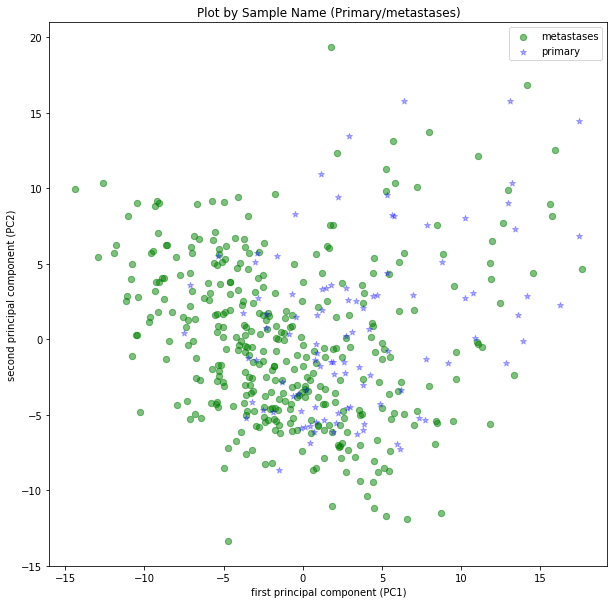

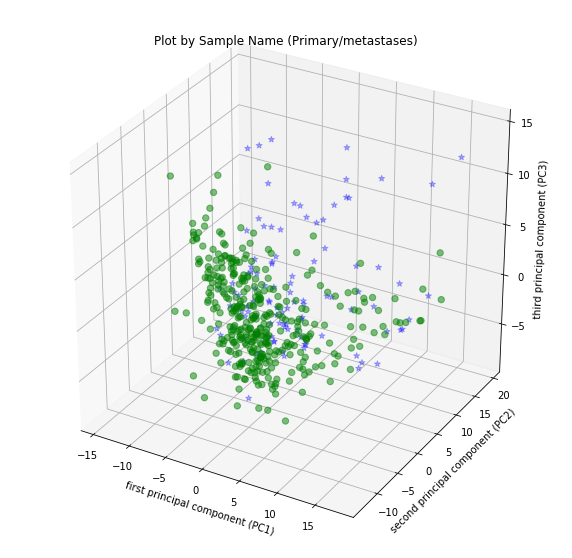

In [35]:
## 2D plot on PC1, PC2 by sample name (primary = 01, metastases = 06) ##

marker = {'primary':'*','metastases':'o'}
alpha = {'primary':.3, 'metastases':.5}

plot_2D(dataset, 
        a.tumor_type, 
        {'primary':'blue','metastases':'green'}, 
        {'primary':'primary','metastases':'metastases'},
        "Plot by Sample Name (Primary/Metastases)",
        marker,
        alpha,)

## 3D plot on PC1, PC2, PC3 by sample name (primary = 01, metastases = 06) ##

plot_3D(dataset, 
        a.tumor_type, 
        {'primary':'blue','metastases':'green'},
        {'primary':'primary','metastases':'metastases'},
        "Plot by Sample Name (Primary/Metastases)",
        marker,
        alpha,)

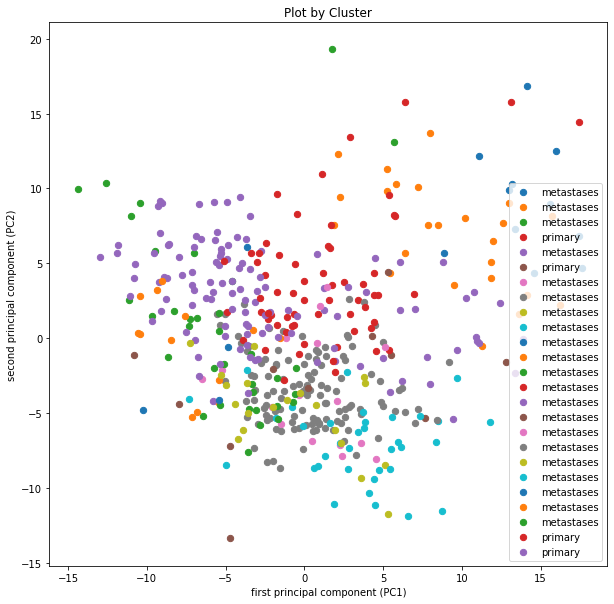

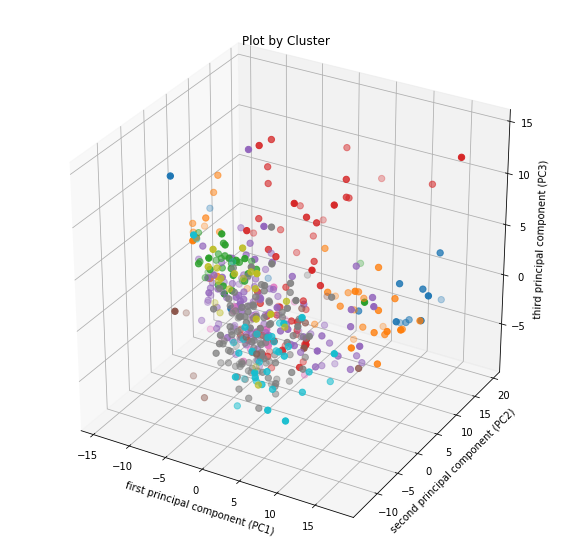

In [36]:
# specify labels
labl_dict = {}
for x in range(1, k+1):
    labl_dict[x] = cluster_types[x-1][1]


## 2D plot on PC1, PC2 by clustering results ##

plot_2D(dataset, a.cluster, a.cluster, labl_dict, "Plot by Cluster")

## 3D plot on PC1, PC2, PC3 by clustering results ##

plot_3D(dataset, a.cluster, a.cluster, labl_dict, "Plot by Cluster")


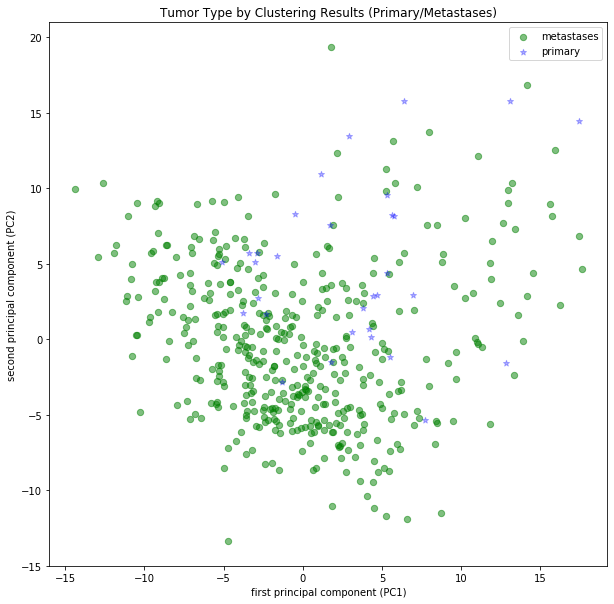

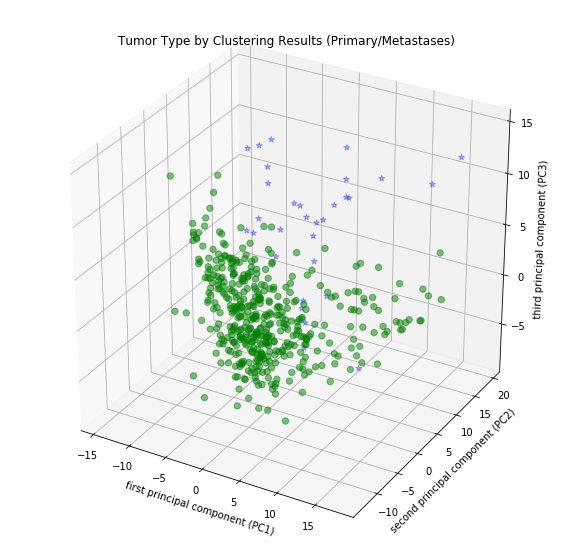

In [37]:
# specify labels

marker = {'primary':'*','metastases':'o', 'unknown':'.'}
alpha = {'primary':.3, 'metastases':.5, 'unknown':.2}

## 2D plot on PC1, PC2 tumor type by clustering results ##

plot_2D(dataset, 
        a.tumor_type_by_clustering, 
        {'primary':'blue','metastases':'green', 'unknown': 'red'}, 
        {'primary':'primary','metastases':'metastases', 'unknown':'unknown'}, 
        "Tumor Type by Clustering Results (Primary/Metastases)",
        marker,
        alpha,)

## 3D plot on PC1, PC2, PC3 tumor type by clustering results ##
plot_3D(dataset, 
        a.tumor_type_by_clustering, 
        {'primary':'blue','metastases':'green', 'unknown': 'red'}, 
        {'primary':'primary','metastases':'metastases', 'unknown':'unknown'}, 
        "Tumor Type by Clustering Results (Primary/Metastases)",
        marker,
        alpha,)

Question 1: miRNA Analysis

In [38]:
#transpose data to get a matrix of samples for rows, dimensions (miRNA) for columns
    
a, X = transform_data(dataframes['micro_rna_data'])

a.head()

micro_rna       hsa.let.7a.1 hsa.let.7a.2 hsa.let.7a.3 hsa.let.7b hsa.let.7c  \
TCGA.3N.A9WC.06     0.236728     0.222467     0.223786  -0.223227   -1.57813   
TCGA.3N.A9WD.06      1.41113      1.40648      1.41593   0.832507    2.19501   
TCGA.BF.A1PU.01      1.26298       1.2625      1.26297    1.42773   0.267714   
TCGA.BF.A1PV.01     0.185005     0.178666     0.155951  -0.256784   0.224654   
TCGA.BF.A1PX.01    0.0938264     0.110214     0.112603    1.30777   0.885622   

micro_rna       hsa.let.7d hsa.let.7e hsa.let.7f.1 hsa.let.7f.2 hsa.let.7g  \
TCGA.3N.A9WC.06   0.933032   0.104533     0.648021     0.199685   0.630162   
TCGA.3N.A9WD.06   0.280042    1.27134     0.839795      1.11564   0.994296   
TCGA.BF.A1PU.01  -0.495464    1.39041     0.799974     0.754727  -0.132817   
TCGA.BF.A1PV.01   -1.07188    1.33215    -0.603771     0.622544  -0.500857   
TCGA.BF.A1PX.01  -0.516688  0.0165566     -0.23625    -0.565286   -1.22644   

micro_rna        ... hsa.mir.937 hsa.mir.939 hsa.mir.940 hsa.mir.942  \
TCGA.3N.A9WC.06  ...    0.173835   -0.210296   -0.697373   -0.528136   
TCGA.3N.A9WD.06  ...    -1.17238    -1.10657    -1.43735    0.317472   
TCGA.BF.A1PU.01  ...    -1.23311    0.417562    -1.08156    -1.95351   
TCGA.BF.A1PV.01  ...    0.780597    0.999319    0.365494   -0.780081   
TCGA.BF.A1PX.01  ...   -0.103274    0.064687     1.07662   -0.154665   

micro_rna       hsa.mir.944 hsa.mir.95 hsa.mir.96 hsa.mir.98 hsa.mir.99a  \
TCGA.3N.A9WC.06   0.0459025   -1.10105   -1.01621   0.788233    -1.22283   
TCGA.3N.A9WD.06     1.05893   0.852694    1.93228  -0.305046     1.95442   
TCGA.BF.A1PU.01   -0.853568  -0.758042  -0.623808  -0.299624   -0.317983   
TCGA.BF.A1PV.01  -0.0743113   -1.10932  -0.755022    1.05446 -0.00787284   
TCGA.BF.A1PX.01     2.11916   0.606579  -0.535643  -0.133948    0.281251   

micro_rna       hsa.mir.99b  
TCGA.3N.A9WC.06    0.757963  
TCGA.3N.A9WD.06    0.317916  
TCGA.BF.A1PU.01  0.00876691  
TCGA.BF.A1PV.01   -0.235655  
TCGA.BF.A1PX.01    0.842755  

[5 rows x 575 columns]

In [39]:
# defining sample labels with only "06", "01" for clarity     
samples_label_list = [x[-2:] for x in list(a.index)]

In [40]:
# selecting clustering methods for use

select_clustering_method(X, ['complete', 'average', 'ward'])
    
# select optimal linkage method: chopenet should be closest to 1   
# methods selected: 'ward' and 'average'

method; cophenet;
complete 0.39044004884051225
average 0.8314533858105708
ward 0.4930703761275736


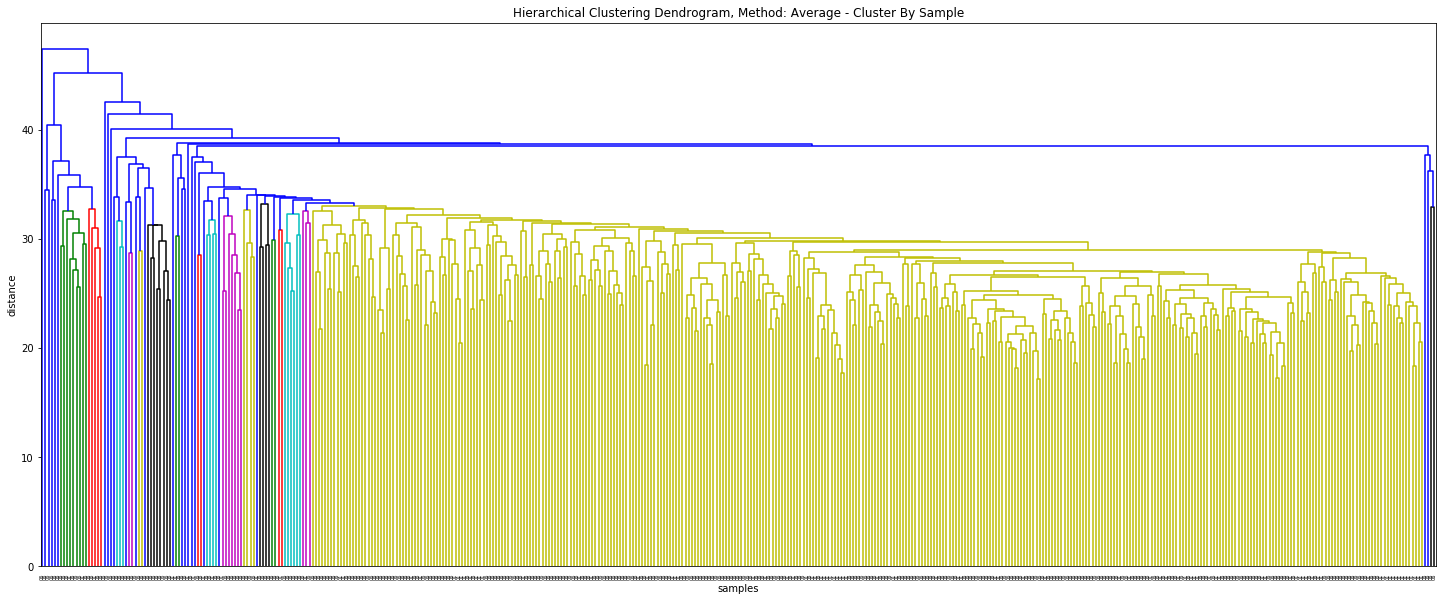


k = 2
cluster		cluster_type		primary_cases	metastases_cases	total_cases
1		metastases (06)		21.65%		78.35%			448
2		metastases (06)		0.0%		100.0%			1

k = 4
cluster		cluster_type		primary_cases	metastases_cases	total_cases
1		metastases (06)		15.79%		84.21%			19
2		metastases (06)		21.96%		78.04%			428
3		metastases (06)		0.0%		100.0%			1
4		metastases (06)		0.0%		100.0%			1

k = 10
cluster		cluster_type		primary_cases	metastases_cases	total_cases
1		metastases (06)		0.0%		100.0%			2
2		metastases (06)		17.65%		82.35%			17
3		metastases (06)		0.0%		100.0%			19
4		metastases (06)		40.0%		60.0%			5
5		metastases (06)		22.69%		77.31%			401
6		primary (01)		100.0%		0.0%			1
7		metastases (06)		0.0%		100.0%			1
8		metastases (06)		0.0%		100.0%			1
9		metastases (06)		0.0%		100.0%			1
10		metastases (06)		0.0%		100.0%			1

k = 15
cluster		cluster_type		primary_cases	metastases_cases	total_cases
1		metastases (06)		0.0%		100.0%			2
2		metastases (06)		17.65%		82.35%			17
3		metastases (06)		

In [41]:
### Clustering with 'average' method ### --> TERRIBLE!

# cluster and plot dendrogram with 'average' method
samples_link = cluster_by_sample_and_plot_dendrogram(X, samples_label_list, 'average')

# choose best k for 'average' clustering:
for k in [2, 4, 10, 15, 25]:
    sample_cluster_dict = divide_samples_into_clusters(k, samples_link, samples_label_list)
    analyze_sample_clusters(sample_cluster_dict)

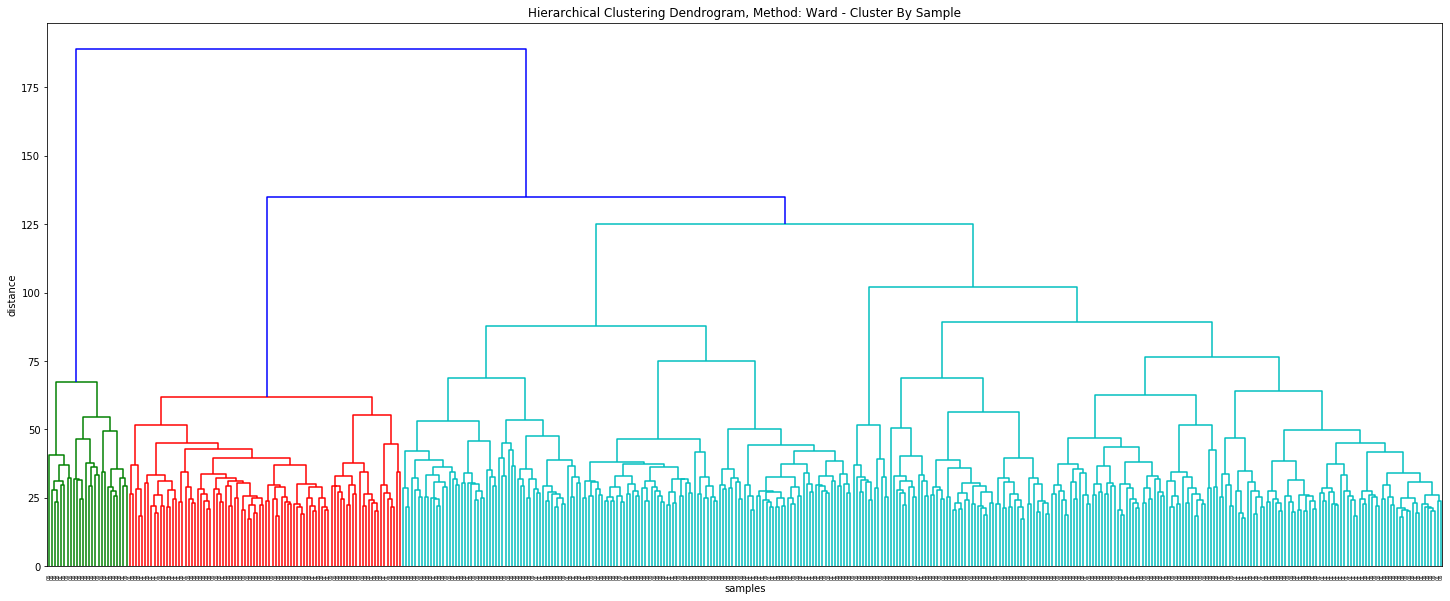


k = 2
cluster		cluster_type		primary_cases	metastases_cases	total_cases
1		metastases (06)		11.54%		88.46%			26
2		metastases (06)		22.22%		77.78%			423

k = 4
cluster		cluster_type		primary_cases	metastases_cases	total_cases
1		metastases (06)		11.54%		88.46%			26
2		metastases (06)		21.59%		78.41%			88
3		metastases (06)		22.76%		77.24%			145
4		metastases (06)		22.11%		77.89%			190

k = 10
cluster		cluster_type		primary_cases	metastases_cases	total_cases
1		metastases (06)		11.54%		88.46%			26
2		metastases (06)		21.59%		78.41%			88
3		metastases (06)		9.68%		90.32%			31
4		metastases (06)		18.52%		81.48%			27
5		metastases (06)		20.45%		79.55%			44
6		metastases (06)		37.21%		62.79%			43
7		metastases (06)		0.0%		100.0%			12
8		metastases (06)		5.77%		94.23%			52
9		metastases (06)		9.26%		90.74%			54
10		metastases (06)		47.22%		52.78%			72

k = 15
cluster		cluster_type		primary_cases	metastases_cases	total_cases
1		metastases (06)		12.5%		87.5%			8
2		metastases (06)		11.11%		88

In [42]:
### Clustering with 'ward' method ### --> Not great, but less terrible!

# cluster and plot dendrogram with 'ward' method
samples_link = cluster_by_sample_and_plot_dendrogram(X, samples_label_list, 'ward')

# choose best k for 'ward' clustering:
for k in [2, 4, 10, 15, 25, 35, 45]:
    sample_cluster_dict = divide_samples_into_clusters(k, samples_link, samples_label_list)
    analyze_sample_clusters(sample_cluster_dict)
    

In [43]:
# select clustering method

# set chosen k based on previous analysis and chosen method
k = 45

# define clusters
clusters = fcluster(samples_link, k, criterion='maxclust')

In [49]:
cluster_types, primary_metastases_cluster_list = define_cluster_types(a, k, samples_link, clusters)
primary_metastases_clusters = np.asarray(primary_metastases_cluster_list, dtype=np.int32)

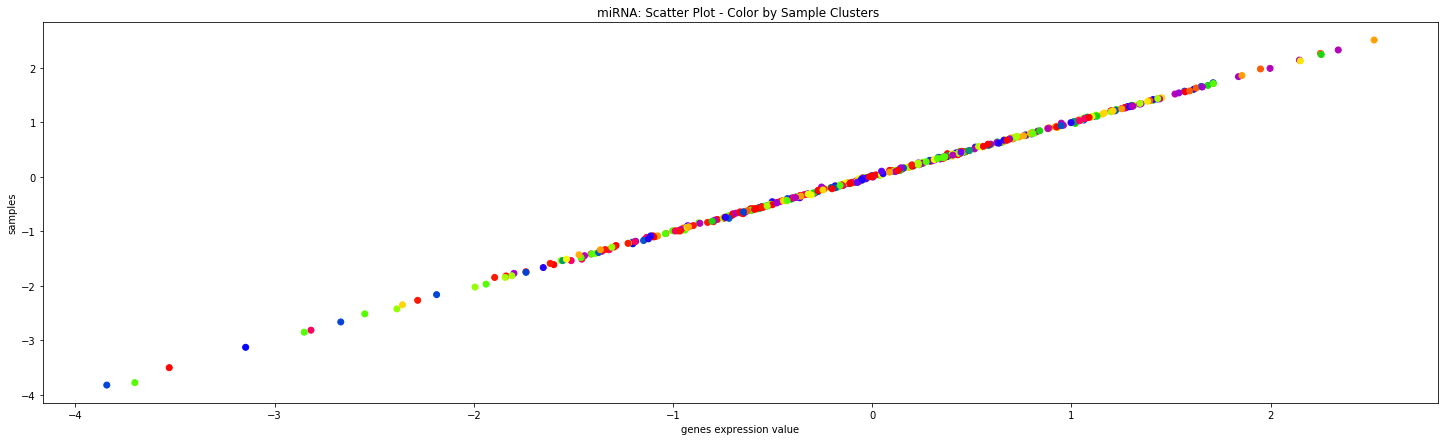

In [51]:
# 1. plot points with color by cluster
scatter_plot_samples(X, clusters, 'miRNA: Scatter Plot - Color by Sample Clusters ')

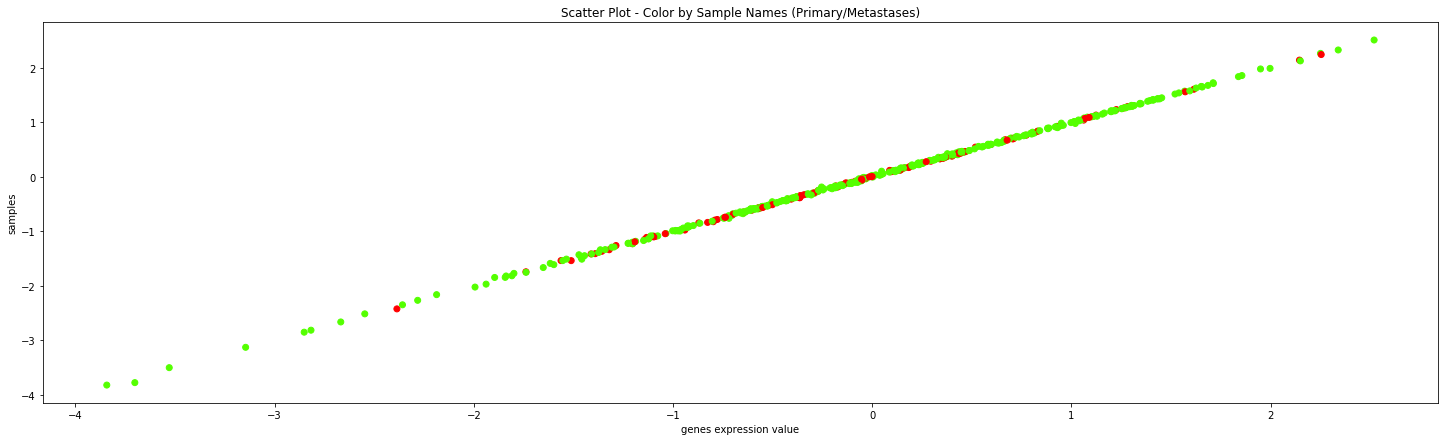

In [52]:
# 2. plot points with color by sample name (01 or 06) (actual tumor type: primary or metastases)

color_values = np.asarray(samples_label_list, dtype=np.int32)
scatter_plot_samples(X, color_values, 'Scatter Plot - Color by Sample Names (Primary/Metastases)')


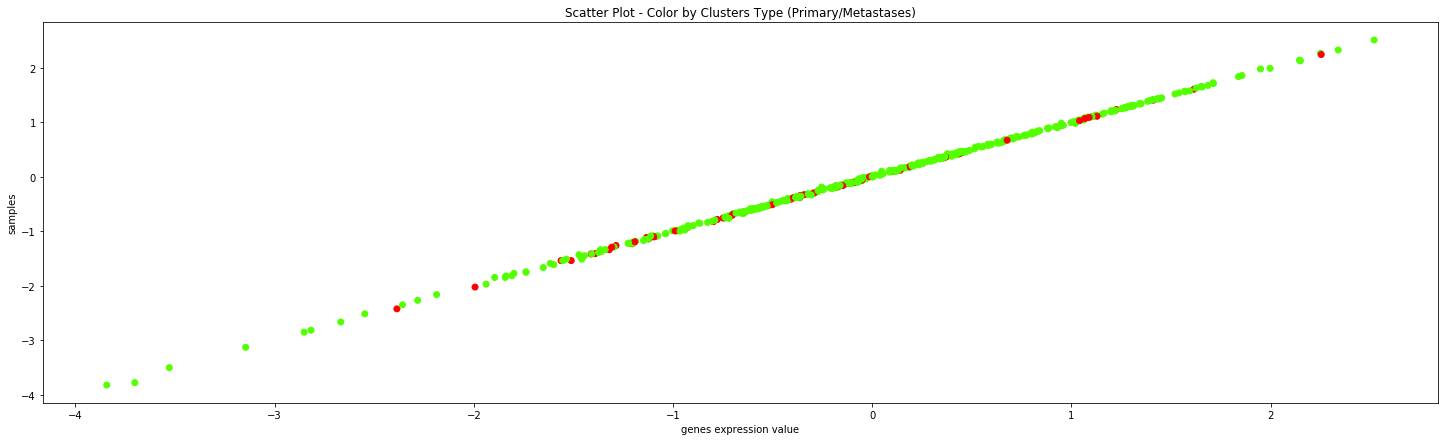

In [53]:
# 3. plot points with color by cluster tumor type (tumor typea as a result of clustering)
scatter_plot_samples(X, primary_metastases_clusters, 'Scatter Plot - Color by Clusters Type (Primary/Metastases)')

In [54]:
# Perform PCA in order to display data points on PCs

In [55]:
# normalize data to values between 0 and 1

scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(X)

print("data has been rescaled")
print("after rescaling: min={}, max={}".format(round(data_rescaled.min(), 2), round(data_rescaled.max(), 2)))

data has been rescaled
after rescaling: min=0.0, max=1.0


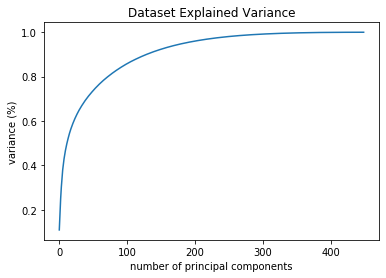

based on graph: selecting 200 principal components that appear to account for close to 100% of the variance


In [56]:
# Select number of principal components to use for PCA
    
plot_explained_variance(data_rescaled)

# based on this graph we need to decide how many principal components to use
# we will not select the maximum possible, in order to preserve only principal components
# however, we want to select a number of components where the graph slope is not very big

# we will decide to use 200 principal components

print("based on graph: selecting 200 principal components that appear to account for close to 100% of the variance")

In [57]:
# perform PCA with 300 components

components = 200

print("plotting the explained variance per principal component")
dataset = perform_pca_and_plot_explained_variance(X, data_rescaled, components)

# based on the graph, we can see that: 
# PC1 + PC2 are responsible for nearly 18% of the explained variance
# PC1 + PC2 + PC3 are responsible for nearly 25% of the explained variance
# we will use these 3 PCs to graph the points on these axis

plotting the explained variance per principal component


In [58]:
# PC1 + PC2 are responsible for 21% of the explained variance

In [59]:
add_cluster_info_to_dataset(a, clusters, cluster_types)

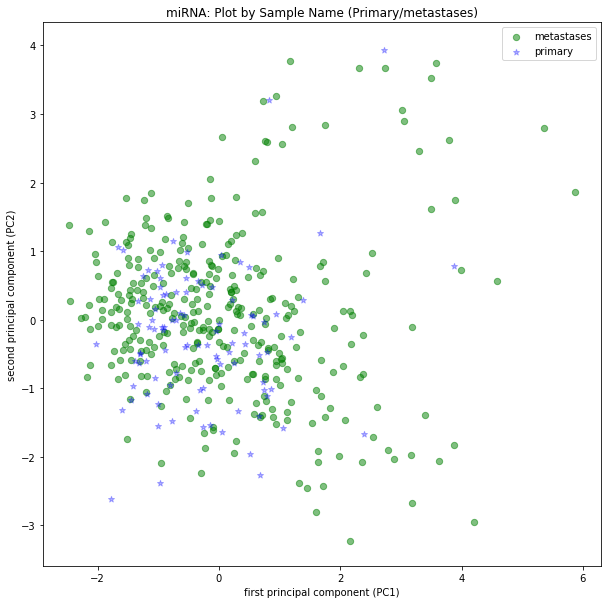

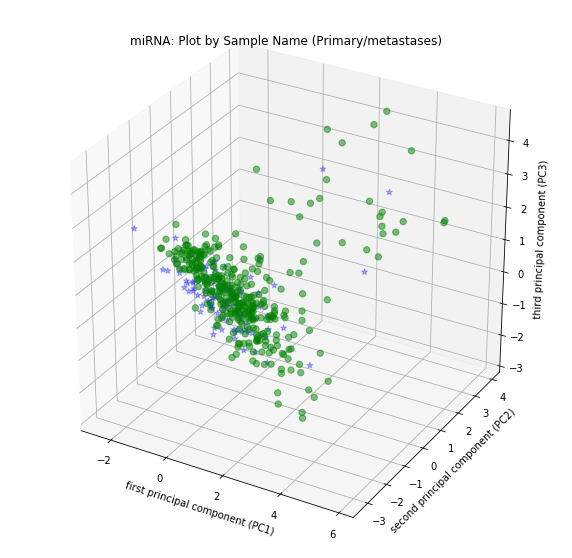

In [60]:
## 2D plot on PC1, PC2 by sample name (primary = 01, metastases = 06) ##

marker = {'primary':'*','metastases':'o'}
alpha = {'primary':.3, 'metastases':.5}

plot_2D(dataset, 
        a.tumor_type, 
        {'primary':'blue','metastases':'green'}, 
        {'primary':'primary','metastases':'metastases'},
        "miRNA: Plot by Sample Name (Primary/Metastases)",
        marker,
        alpha,)

## 3D plot on PC1, PC2, PC3 by sample name (primary = 01, metastases = 06) ##

plot_3D(dataset, 
        a.tumor_type, 
        {'primary':'blue','metastases':'green'},
        {'primary':'primary','metastases':'metastases'},
        "miRNA: Plot by Sample Name (Primary/Metastases)",
        marker,
        alpha,)

# resulting picture is really similar to gene expression picture!

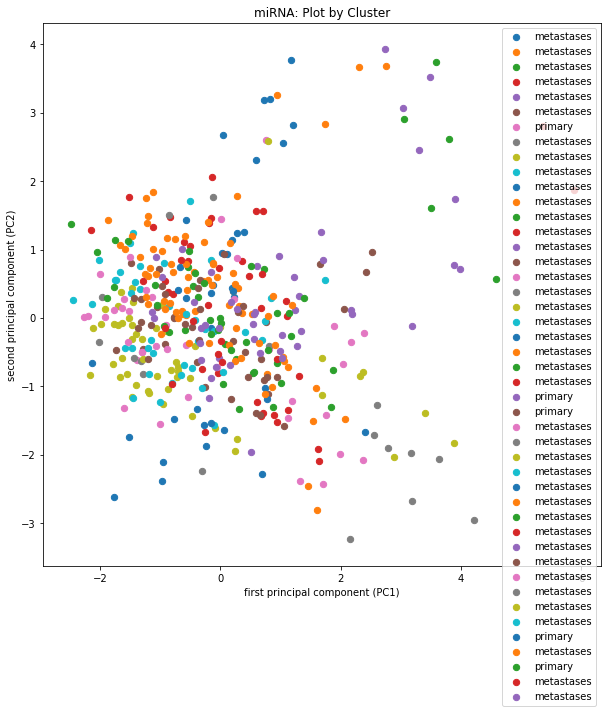

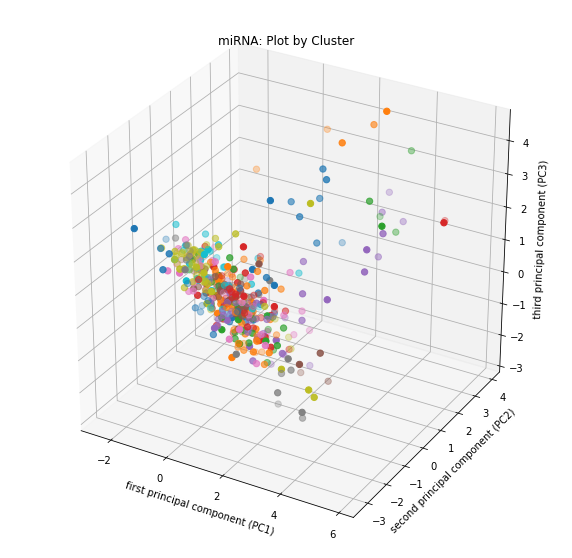

In [61]:
# specify labels
labl_dict = {}
for x in range(1, k+1):
    labl_dict[x] = cluster_types[x-1][1]


## 2D plot on PC1, PC2 by clustering results ##

plot_2D(dataset, a.cluster, a.cluster, labl_dict, "miRNA: Plot by Cluster")

## 3D plot on PC1, PC2, PC3 by clustering results ##

plot_3D(dataset, a.cluster, a.cluster, labl_dict, "miRNA: Plot by Cluster")


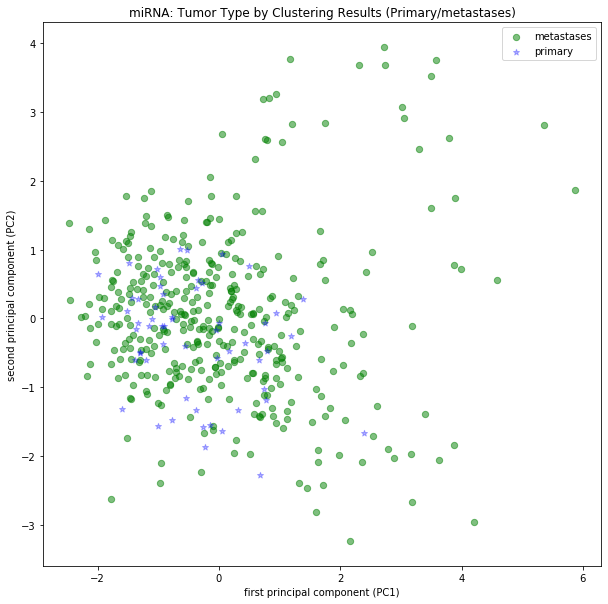

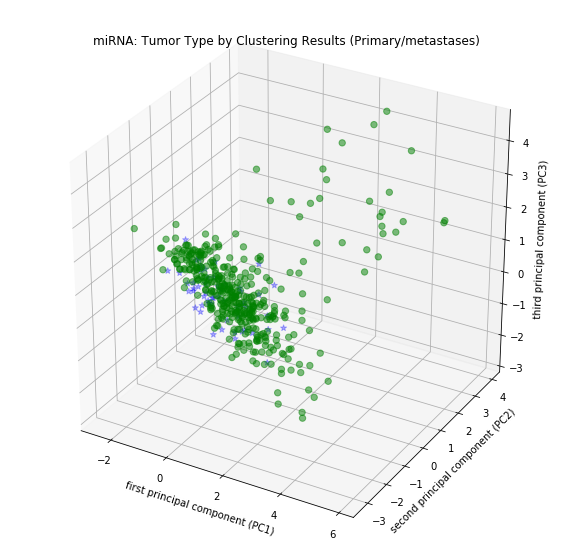

In [62]:
# specify labels

marker = {'primary':'*','metastases':'o', 'unknown':'.'}
alpha = {'primary':.3, 'metastases':.5, 'unknown':.2}

## 2D plot on PC1, PC2 tumor type by clustering results ##

plot_2D(dataset, 
        a.tumor_type_by_clustering, 
        {'primary':'blue','metastases':'green', 'unknown': 'red'}, 
        {'primary':'primary','metastases':'metastases', 'unknown':'unknown'}, 
        "miRNA: Tumor Type by Clustering Results (Primary/Metastases)",
        marker,
        alpha,)

## 3D plot on PC1, PC2, PC3 tumor type by clustering results ##
plot_3D(dataset, 
        a.tumor_type_by_clustering, 
        {'primary':'blue','metastases':'green', 'unknown': 'red'}, 
        {'primary':'primary','metastases':'metastases', 'unknown':'unknown'}, 
        "miRNA: Tumor Type by Clustering Results (Primary/Metastases)",
        marker,
        alpha,)

Research Questions and Analysis Methodology:
    
<u>Question # 2</u>

**Qustion:**

**a) Which genes and miRNA have a higher expression in local skin metastases vs primary tumor?<br />
b) Which genes and miRNA have a higher expression in distant metastases?<br />
c) Which genes and miRNA have a higher expression in lymph nodes?<br />
d) Are the genes in the various organs similar?<br />**



Defining highly-expressed genes
Differential Gene Expression (DGE) Analysis: (see description in "Methods" section)
This analysis is designed to be performed on counts (expression), not normalized data!
To determine if a gene has been significantly expressed, we will use in this section:
P-value < 0.01
log2FoldChange: see values in the code (the usual boundary is +/-2)
 However, these tests are unfortunately not enough to deal with our data because we received gtex_data already partially normalized
Our Version of Gene Expression Analysis:
Why do we need this when we can use DGE analysis?
Most methods use a counts matrix that has not been normalized and perform calculations based on it. In the case of TCGA data, we have these counts matrix available. However, gtex data is a dataset we already received partially normalized (genes have a mean of zero). Tests based on means cannot work for gtex data, because all of our means are zero.
We read that to the actual count numbers in the gene expression dataset and the numbers that are the basis for the gtex dataset are derived by different methods, so one number cannot actually be compared to another directly
For these reasons, we also defined our own definition of highly-expressed genes, using our normalized datasets:
Per gene per dataset, we have a gene expression value per sample, but want to define a single gene expression value to use to represent that gene (so that we can compare all values and find large ones to be highly expressed)
We will use median gene expression per gene
The normalization affects the values, but medians per gene can have a range of values
We arbitrarily selected to look at genes with median values in the 99.9th percentile, but defined this as a parameter, and other values can also be examined
Per group of samples, we will select the genes with 99.9th percentile of highest median expression as "highly expressed" for that group
        
**Analysis Description:**

Perform Differential Gene Expression (DGE) Analysis for Metastases Samples vs Primary Samples:
Prep data for determining highly and slightly expressed genes/miRNA in a given non-normalized dataframe. As part of this process:
Divide dataframe into to 4 mini dataframes: primary tumor,local skin metastasis, distant metastasis, lymph nodes
Plot the relationship between mean and std for each mini dataframe.
Transpose full dataframe to get a matrix where samples are rows, dimensions (genes/miRNA) for columns 
Create a sample types dataset, where the condition is defined as: if type one: 1, otherwise 0 (type one is each one of the mini dataframes every time).
Create an AnnData object that will hold our data matrix (X), sample descriptions, and and labels - and return it
Perform differential expression analysis
Run 2 types of tests on the data: Welch's t-test and rank sum test
Display an MA plot (this should be used to help define limits used to limit log2foldchange for high, low expression)
Graph volcano plots based on both tests to help differentiate significant values
Plot a comparison of both tests
Create a dataset of highly expressed genes/miRNAs and slightly expressed genes/miRNAs using p-value=0.01,  log2foldchange: see values in the code for slightly expressed and highly expressed.
merge all highly expressed genes into one dataframe, slightly expressed genes into one dataframe
return highly expressed and slightly expressed dataframes


In [15]:
# differential expression analysis using diffxpy 
# (installation instructions: https://github.com/theislab/diffxpy/blob/master/docs/installation.rst)

# import relevant packages for differential expression analysis
import anndata
import logging
import scipy.stats
import batchglm
import diffxpy.api as de

/Users/NevoHome/Documents/University- History/Semester 4a/Workshop in Computational Analysis of Genomic Medical Data/project/acgt_melanoma/venv/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning:

pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.



In [21]:
# function to add dataframes after data editing
def add_not_normalized_dataframe(name, dataframe, data_type, column_name):
    not_normalized_dataframes[name] = dataframe.iloc[1:, :]
    not_normalized_dataframes[name].columns = ['metastases_type'] + list(not_normalized_dataframes[data_type][column_name])
    not_normalized_dataframes[name]['metastases_type'] = name

# Part (a)
def divide_damples_by_organs(dataframe_name, column_name):
    def create_same_keys(df, column_name):
        """
        this function updates the sampleID row in the dataframes[dataframe_name] (miRNA or all the genes data)
        to match the first row in dataframes['clinical_data']
        """
        for i in df.index:
            value = df.at[i, column_name].replace('-', '.')
            df.at[i, column_name] = value

    create_same_keys(dataframes['clinical_data'], 'sampleID')

    data_transpose = not_normalized_dataframes[dataframe_name].T
    data_transpose.reset_index(
        inplace=True)  # create a column from the row headers, so the sample name is a column

    # this is only the clinical data divided according to 'tumor_tissue_site':
    lymph_clinical_data = dataframes['clinical_data'].loc[dataframes['clinical_data']
                                                            ['tumor_tissue_site'] == 'Regional Lymph Node'].filter(
        items=['sampleID'])

    distant_metastasisc_linical_data = dataframes['clinical_data'].loc[dataframes['clinical_data']
                                                                         [
                                                                             'tumor_tissue_site'] == 'Distant Metastasis'].filter(
        items=['sampleID'])

    primary_tumor_clinical_data = dataframes['clinical_data'].loc[dataframes['clinical_data']
                                                                    ['tumor_tissue_site'] == 'Primary Tumor'].filter(
        items=['sampleID'])

    local_skin_metastasis_data = dataframes['clinical_data'].loc[dataframes['clinical_data']
                                                                   ['tumor_tissue_site'] ==
                                                                   'Regional Cutaneous or Subcutaneous Tissue (includes satellite and in-transit metastasis)']. \
        filter(items=['sampleID'])

    # those are the genes data in every tumor_tissue_site:
    lymph_genes = pd.merge(lymph_clinical_data,
                           data_transpose,
                           right_on='index',
                           left_on='sampleID',
                           how='inner').drop(['sampleID'],
                                             axis=1)

    distant_metastasis_genes = pd.merge(distant_metastasisc_linical_data,
                                        data_transpose,
                                        right_on='index',
                                        left_on='sampleID',
                                        how='inner').drop(['sampleID'],
                                                          axis=1)

    primary_tumor_genes = pd.merge(primary_tumor_clinical_data,
                                   data_transpose,
                                   right_on='index',
                                   left_on='sampleID',
                                   how='inner').drop(['sampleID'],
                                                     axis=1)

    local_skin_metastasis_genes = pd.merge(local_skin_metastasis_data,
                                           data_transpose,
                                           right_on='index',
                                           left_on='sampleID',
                                           how='inner').drop(['sampleID'],
                                                             axis=1)

    add_not_normalized_dataframe(name='lymph',
                                   dataframe=lymph_genes,
                                   data_type=dataframe_name,
                                   column_name=column_name)

    add_not_normalized_dataframe(name='distant_metastasis',
                                   dataframe=distant_metastasis_genes,
                                   data_type=dataframe_name,
                                   column_name=column_name)

    add_not_normalized_dataframe(name='primary_tumor',
                                   dataframe=primary_tumor_genes,
                                   data_type=dataframe_name,
                                   column_name=column_name)

    add_not_normalized_dataframe(name='local_skin_metastasis',
                                   dataframe=local_skin_metastasis_genes,
                                   data_type=dataframe_name,
                                   column_name=column_name)

In [22]:
# part (b)
"""
This function graphes the mean and median gene expression/miRNAand 
edits the datasets to use the tests in part (c)
"""

def create_data_to_find_highly_expressed_genes(dataframe_names, single_df=False):
    if single_df:
        print(f'current data is: {dataframe_names[0]}')
    else:
        print(f'current datasets are: {dataframe_names[0]} and {dataframe_names[1]}')
    # concat dataframes
    df = not_normalized_dataframes[dataframe_names[0]]

    for name in dataframe_names[1:]:
        df = pd.concat(
            [df, not_normalized_dataframes[name]], sort=False)

    def perform_log_metastasis_type(dataframe, column_name):
        # perform log2 (val+1)
        dataframe = dataframe.apply(lambda x: np.log2(x.astype("float64") + 1) if x.name != column_name else x)
        return dataframe

    def plot_relationship_between_mean_and_std_metastasis_type(dataframe, title):
        mean_vals = dataframe.mean()  # these are the expected values
        std_vals = dataframe.std()  # this is the variance
        plt.figure(figsize=(7, 7))  # set figure size
        plt.title("plotting relationship between mean (after log) and std: {}".format(title))  # set title
        plt.xlabel('mean (log)')  # label x axis
        plt.ylabel('standard deviation')  # label y axis
        plt.scatter(mean_vals, std_vals)
        plt.show()

    def log_and_plot(dataframe, column_name, title):
        x = perform_log_metastasis_type(dataframe, column_name)
        plot_relationship_between_mean_and_std_metastasis_type(x, title)

    # plotting mean (after log) vs std, for each dataframe
    if single_df:
        log_and_plot(not_normalized_dataframes[dataframe_names[0]], 'metastases_type', dataframe_names[0])

    else:
        for dataframe_name in dataframe_names:
            log_and_plot(not_normalized_dataframes[dataframe_name], 'metastases_type', dataframe_name)

    # plotting mean (after log) vs std, combined dataframe
    log_and_plot(df, 'metastases_type', f'combined dataframes:{dataframe_names}')

    # no need to transform data, it is already in the correct format, we just need to exclude the column 'metastases_type'
    X = df.iloc[:, 1:].to_numpy()

    def create_sample_description_dataset(dataframe):
        sample_descriptions = pd.DataFrame(
            [dataframe_names.index(x) if x in dataframe_names else 8 for x in list(dataframe.metastases_type)])
        if single_df:
            sample_descriptions = pd.DataFrame(
                [1 if x == dataframe_names[0] else 0 for x in list(dataframe.metastases_type)])
        else:
            sample_descriptions = pd.DataFrame(
                [dataframe_names.index(x) if x in dataframe_names else 8 for x in list(dataframe.metastases_type)])
        sample_descriptions['batch'] = 0
        sample_descriptions.columns = ['condition', 'batch']
        return sample_descriptions

    sample_descriptions = create_sample_description_dataset(df)

    # create a column list that includes all genes and does not include 'metastases_type'
    cols = list(df.columns)[1:]

    data = anndata.AnnData(
        X=X,
        var=pd.DataFrame(index=cols),
        obs=sample_descriptions
    )

    return data


In [23]:
# part (c)
def differential_expression_analysis_multiple_groups(data, axis_name, bottom=-7.5, top=7.5):
    """
    Running differential expression tests:

    1. Welch's t-test
    2. Rank sum test

    For t-tests and rank sum tests, the grouping argument indicates the the name of the relevant condition column
    in the sample description
    """

    print("Performing differential expression tests and displaying sample results\n")

    print("Running Welch's T-Test:\n")

    # Welch's t-test
    test_tt = de.test.t_test(
        data=data,
        grouping="condition")

    print(test_tt.summary().iloc[:5, :-2])

    print("\nRunning Rank-Sum Test:\n")
    # Rank sum test
    test_rank = de.test.rank_test(
        data=data,
        grouping="condition"
    )
    print(test_rank.summary().iloc[:5, :-2])

    """
    MA Plot
    An MA-plot is a 2D plot that shows the log2-fold change vs mean expression
    """
    print("\nPrinting MA plot: shows log2-fold changes vs mean expression")
    test_tt.plot_ma()

    """
    Volcano Plot
    A volcano plot is a 2D scatter plot shaped like a volcano
    It is used to show statistically significant gene expression changes from two different conditions
    It displayes log fold change vs p-value

    """
    print("\nGraphing volcano plot: shows log fold change vs p-value\n")

    print("T-Test volcano plot:\n")
    test_tt.plot_volcano()

    print("Rank-Sum test volcano plot:\n")
    test_rank.plot_volcano()

    """
    Scatter plot of log10_pval for t-test vs log10_pval for rank sum test:
    """

    print("Graphing log10_pval for t-test (x axis) vs log10_pval for rank sum test (y axis)")
    # compare 2 results
    sns.scatterplot(x=test_tt.log10_pval_clean(), y=test_rank.log10_pval_clean())
    plt.show()

    """
    Returning Highly and Slightly Expressed Genes
    To determine if a gene has been significantly expressed, we use:
    1. P-value: 0.01
    2. log2FoldChange: we add as a parameter to the function. 
        we read that fold-change of +/- 2 is often used as the threshold for defining significant differential 
        expression, therefore we will use a minimum of log fold-change +2 to define highly-expressed genes and
        a maximum of -2 to define slightly expressed genes. However, we will select actual values to use by 
        examining an MA-Plot and seeing outlying values graphically.     
    """

    print("\nDetermining which genes are highly/slightly expressed using:")
    print("p-value: 0.01 or lower")
    print("log2FoldChange: {} or greater for highly expressed, {} or lower for slightly expressed".format(top, bottom))

    # defining highly-expressed genes based on t-test
    highly_expressed_tt = test_tt.summary()
    highly_expressed_tt = highly_expressed_tt[(highly_expressed_tt.pval < 0.01) & (highly_expressed_tt.log2fc >= top)]

    # defining slightly-expressed genes based on t-test
    slightly_expressed_tt = test_tt.summary()
    slightly_expressed_tt = slightly_expressed_tt[
        (slightly_expressed_tt.pval < 0.01) &
        (slightly_expressed_tt.log2fc <= bottom)]
    print("\nT-Test Results:")
    print("\nHighly Expressed Genes:\n")
    display(highly_expressed_tt)

    print("\nSlightly Expressed Genes:\n")
    display(slightly_expressed_tt)

    # defining highly-expressed genes based on rank-sum test
    highly_expressed_rt = test_rank.summary()
    highly_expressed_rt = highly_expressed_rt[(highly_expressed_rt.pval < 0.01) & (highly_expressed_rt.log2fc >= top)]

    # defining slightly-expressed genes based on t-test
    slightly_expressed_rt = test_rank.summary()
    slightly_expressed_rt = slightly_expressed_rt[
        (slightly_expressed_rt.pval < 0.01) &
        (slightly_expressed_rt.log2fc <= bottom)]
    print("\nRank-Sum Results:")
    print("\nHighly Expressed Genes:\n")
    display(highly_expressed_rt)

    print("\nSlightly Expressed Genes:\n")
    display(slightly_expressed_rt)

    # combine hightly-expressed dataframes
    highly_expressed = pd.merge(
        highly_expressed_tt[[axis_name, 'pval', 'log2fc', 'mean']],
        highly_expressed_rt[[axis_name, 'pval', 'log2fc', 'mean']],
        on='gene',
        how='outer')

    slightly_expressed = pd.merge(
        slightly_expressed_tt[[axis_name, 'pval', 'log2fc', 'mean']],
        slightly_expressed_rt[[axis_name, 'pval', 'log2fc', 'mean']],
        on='gene',
        how='outer')

    print("\nOverall highly expresed:")
    display(highly_expressed)
    print("\nOverall slightly expresed:")
    display(slightly_expressed)

    return highly_expressed, slightly_expressed


In [71]:
# part (d)
# TODO: Nevo

In [ ]:

def run_analysis_genes():
    """
    This function run all the question parts (b,c,d)
    """
    data = create_data_to_find_highly_expressed_genes(
        dataframe_names=['local_skin_metastasis', 'primary_tumor'])

    highly_expressed_genes, slightly_expressed_genes = differential_expression_analysis_multiple_groups(data=data,
                                                                                                        axis_name='gene',
                                                                                                        bottom=-3.5,
                                                                                                        top=6.5)

    data = create_data_to_find_highly_expressed_genes(
        dataframe_names=['distant_metastasis', 'local_skin_metastasis', 'primary_tumor', 'lymph'], single_df=True)

    highly_expressed_genes, slightly_expressed_genes = differential_expression_analysis_multiple_groups(data=data,
                                                                                                        axis_name='gene',
                                                                                                        bottom=-5.5,
                                                                                                        top=4.5)
    data = create_data_to_find_highly_expressed_genes(
        dataframe_names=['lymph', 'local_skin_metastasis', 'primary_tumor', 'distant_metastasis'], single_df=True)

    highly_expressed_genes, slightly_expressed_genes = differential_expression_analysis_multiple_groups(data=data,
                                                                                                        axis_name='gene',
                                                                                                        bottom=-7,
                                                                                                        top=8)


def run_analysis_miRNNA():
    """
    This function run all the question parts (b,c,d)
    """
    data = create_data_to_find_highly_expressed_genes(
        dataframe_names=['local_skin_metastasis', 'primary_tumor'])

    highly_expressed_genes, slightly_expressed_genes = differential_expression_analysis_multiple_groups(data=data,
                                                                                                        axis_name='gene',
                                                                                                        bottom=-1.5,
                                                                                                        top=1.5)

    data = create_data_to_find_highly_expressed_genes(
        dataframe_names=['distant_metastasis', 'local_skin_metastasis', 'primary_tumor', 'lymph'], single_df=True)

    highly_expressed_genes, slightly_expressed_genes = differential_expression_analysis_multiple_groups(data=data,
                                                                                                        axis_name='gene',
                                                                                                        bottom=-1,
                                                                                                        top=1)

    data = create_data_to_find_highly_expressed_genes(
        dataframe_names=['lymph', 'local_skin_metastasis', 'primary_tumor', 'distant_metastasis'], single_df=True)

    highly_expressed_genes, slightly_expressed_genes = differential_expression_analysis_multiple_groups(data=data,
                                                                                                        axis_name='gene',
                                                                                                        bottom=-1,
                                                                                                        top=1)

/Users/NevoHome/Documents/University- History/Semester 4a/Workshop in Computational Analysis of Genomic Medical Data/project/acgt_melanoma/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

Transforming to str index.
Transforming to str index.
/Users/NevoHome/Documents/University- History/Semester 4a/Workshop in Computational Analysis of Genomic Medical Data/project/acgt_melanoma/venv/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning:

divide by zero encountered in log

/Users/NevoHome/Documents/University- History/Semester 4a/Workshop in Computational Analysis of Genomic Medical Data/project/acgt_melanoma/venv/lib/python3.7/site-packages/dask/array/core.py:2622: RuntimeWarning:

div

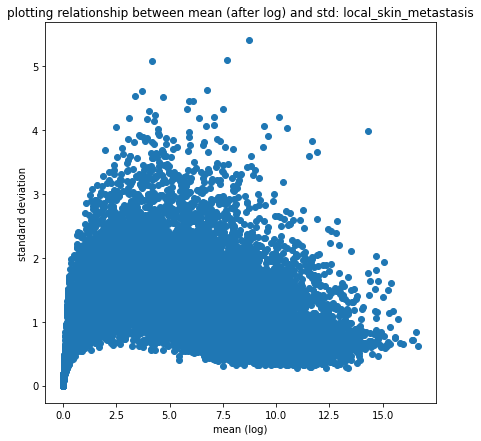

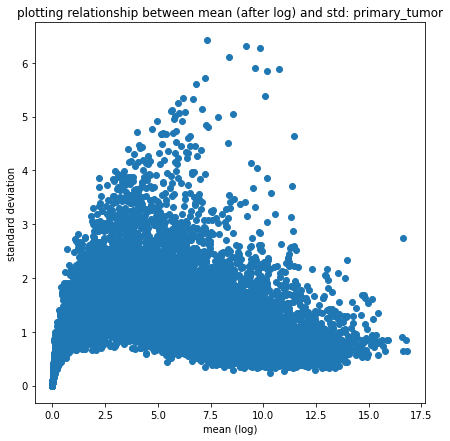

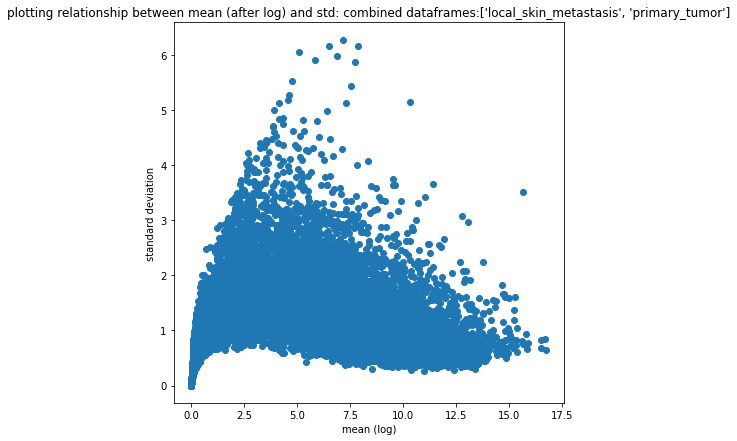

Performing differential expression tests and displaying sample results

Running Welch's T-Test:

           gene      pval      qval    log2fc        mean
0        A1BG.1  0.003395  0.021747  0.535412  337.165945
1    A1CF.29974  0.640911  0.757887  0.578316    0.164608
2   A2BP1.54715  0.322370  0.485767  4.678709    8.330055
3   A2LD1.87769  0.000285  0.004285  0.482664   99.135947
4  A2ML1.144568  0.000817  0.008310  2.849538  628.823562

Running Rank-Sum Test:

           gene          pval          qval    log2fc        mean
0        A1BG.1  2.398876e-03  1.193659e-02  0.535412  337.165945
1    A1CF.29974  3.263945e-01  4.773337e-01  0.578316    0.164608
2   A2BP1.54715  7.990242e-01  8.727358e-01  4.678709    8.330055
3   A2LD1.87769  3.524947e-04  2.754299e-03  0.482664   99.135947
4  A2ML1.144568  1.823163e-09  2.487243e-07  2.849538  628.823562

Printing MA plot: shows log2-fold changes vs mean expression

Graphing volcano plot: shows log fold change vs p-value

T-Test volcano

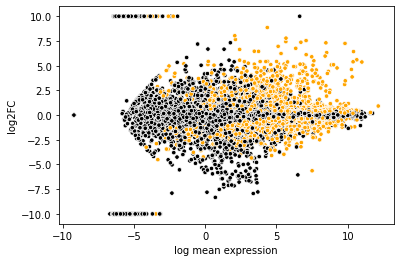

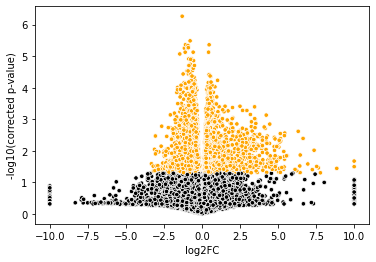

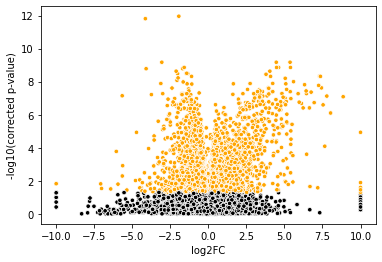

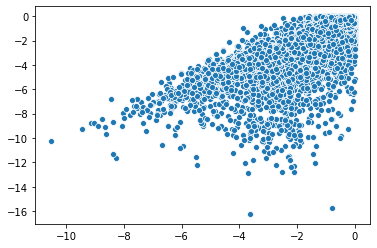

gene      pval      qval       log2fc         mean  \
4570      DEFB4A.1673  0.007182  0.036031     8.858906    77.854652   
8857     LCE3A.353142  0.006743  0.034575     7.649101     8.307933   
11584       OCM2.4951  0.005970  0.031690  1069.973744     0.035917   
13060  PPIAL4E.730262  0.003251  0.021162  1069.422425     0.024510   
16240     SPRR2G.6706  0.005835  0.031270     7.539829  1184.808938   

       zero_mean  zero_variance  
4570       False          False  
8857       False          False  
11584      False          False  
13060      False          False  
16240      False          False

Empty DataFrame
Columns: [gene, pval, qval, log2fc, mean, zero_mean, zero_variance]
Index: []

gene          pval          qval       log2fc         mean  \
4570      DEFB4A.1673  3.423331e-10  8.131695e-08     8.858906    77.854652   
7748     IGFL1.374918  3.059218e-10  7.453117e-08     7.783029   289.226186   
8686        KRT9.3857  2.452813e-07  1.156596e-05    10.288504   756.205800   
8857     LCE3A.353142  3.221128e-06  8.054093e-05     7.649101     8.307933   
8893   LDLRAD1.388633  2.641840e-03  1.282321e-02  1071.542749     0.106566   
11584       OCM2.4951  6.369175e-03  2.494506e-02  1069.973744     0.035917   
12081    OTOP3.347741  7.824596e-09  7.867238e-07     8.031093     7.971114   
13060  PPIAL4E.730262  9.872096e-03  3.500643e-02  1069.422425     0.024510   
16240     SPRR2G.6706  1.917171e-09  2.530000e-07     7.539829  1184.808938   

       zero_mean  zero_variance  
4570       False          False  
7748       False          False  
8686       False          False  
8857       False          False  
8893       False          False  
11584      False          False  
12081      False          False  
13060      False          False  
16240      False          False

gene      pval      qval       log2fc      mean  zero_mean  \
5569    FAM138B.654412  0.003212  0.014802 -1070.276724  0.031405      False   
9464  LOC642929.642929  0.003212  0.014802 -1069.929233  0.024682      False   

      zero_variance  
5569          False  
9464          False

gene    pval_x     log2fc_x       mean_x        pval_y  \
0     DEFB4A.1673  0.007182     8.858906    77.854652  3.423331e-10   
1    LCE3A.353142  0.006743     7.649101     8.307933  3.221128e-06   
2       OCM2.4951  0.005970  1069.973744     0.035917  6.369175e-03   
3  PPIAL4E.730262  0.003251  1069.422425     0.024510  9.872096e-03   
4     SPRR2G.6706  0.005835     7.539829  1184.808938  1.917171e-09   
5    IGFL1.374918       NaN          NaN          NaN  3.059218e-10   
6       KRT9.3857       NaN          NaN          NaN  2.452813e-07   
7  LDLRAD1.388633       NaN          NaN          NaN  2.641840e-03   
8    OTOP3.347741       NaN          NaN          NaN  7.824596e-09   

      log2fc_y       mean_y  
0     8.858906    77.854652  
1     7.649101     8.307933  
2  1069.973744     0.035917  
3  1069.422425     0.024510  
4     7.539829  1184.808938  
5     7.783029   289.226186  
6    10.288504   756.205800  
7  1071.542749     0.106566  
8     8.031093     7.971114

pval_x  log2fc_x  mean_x              gene    pval_y     log2fc_y    mean_y
0     NaN       NaN     NaN    FAM138B.654412  0.003212 -1070.276724  0.031405
1     NaN       NaN     NaN  LOC642929.642929  0.003212 -1069.929233  0.024682

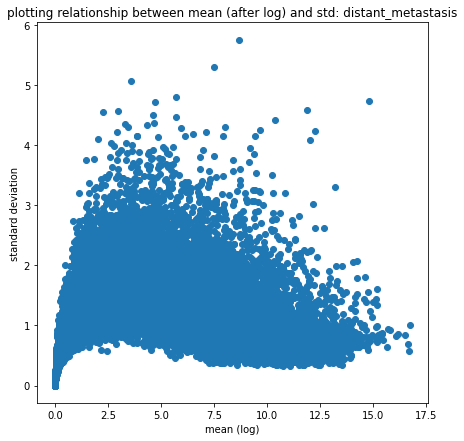

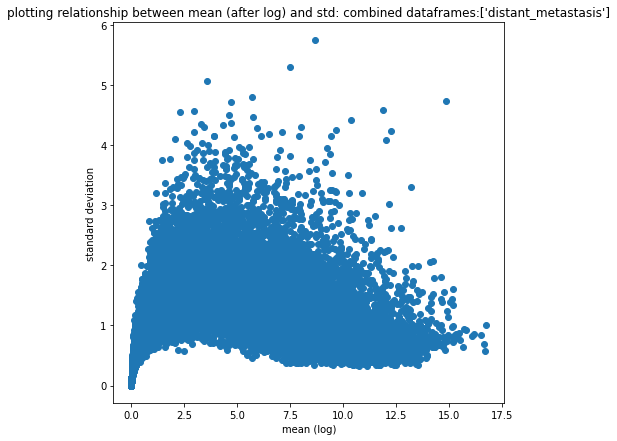

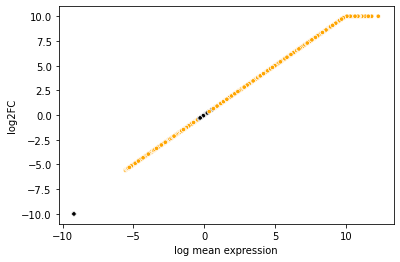

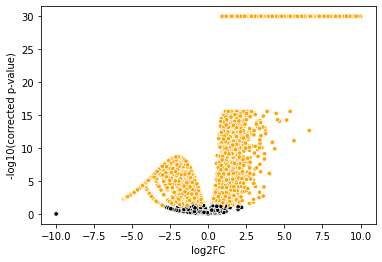

gene  pval  qval     log2fc          mean  zero_mean  \
5              A2M.2   0.0   0.0  10.366589  31779.895218      False   
19           AAMP.14   0.0   0.0   8.011927   3016.723994      False   
23           AARS.16   0.0   0.0   8.542232   5126.775154      False   
27        AATF.26574   0.0   0.0   7.607858   2013.959945      False   
36          ABCA2.20   0.0   0.0   7.575442   1949.721557      False   
...              ...   ...   ...        ...           ...        ...   
18845    ZNF207.7756   0.0   0.0   8.021117   3044.577136      False   
18874     ZNF24.7572   0.0   0.0   7.800054   2440.732860      False   
19147   ZNF638.27332   0.0   0.0   7.525012   1853.835385      False   
19164  ZNF664.144348   0.0   0.0   7.858612   2587.925945      False   
19311   ZNHIT1.10467   0.0   0.0   7.610305   2018.894348      False   

               grad   coef_mle   coef_sd          ll  
5      2.481008e-06  10.366589  0.114633 -761.231335  
19     8.429207e-07   8.011927  0.040757 -555.760912  
23     8.951361e-07   8.542232  0.057282 -611.466830  
27     1.232530e-07   7.607858  0.046918 -537.257795  
36     4.106596e-07   7.575442  0.089762 -568.234722  
...             ...        ...       ...         ...  
18845  1.544686e-07   8.021117  0.029611 -536.194634  
18874  3.466481e-08   7.800054  0.067275 -570.415300  
19147  6.528322e-07   7.525012  0.056794 -542.860365  
19164  1.139842e-07   7.858612  0.055551 -563.944371  
19311  4.683189e-07   7.610305  0.062847 -554.115474  

[2385 rows x 10 columns]

Empty DataFrame
Columns: [gene, pval, qval, log2fc, mean, zero_mean, grad, coef_mle, coef_sd, ll]
Index: []

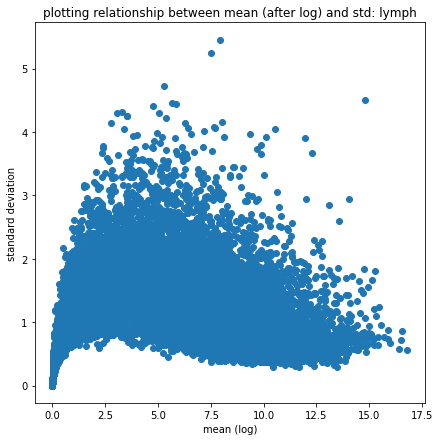

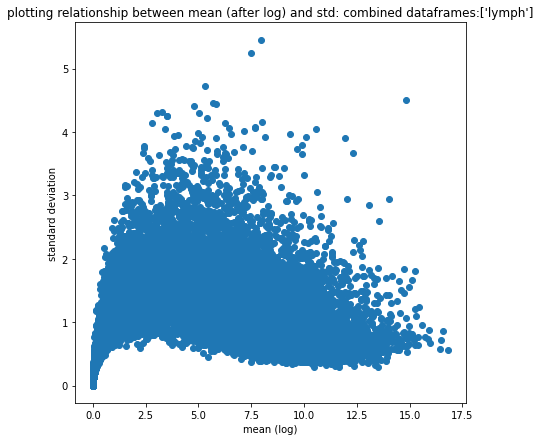

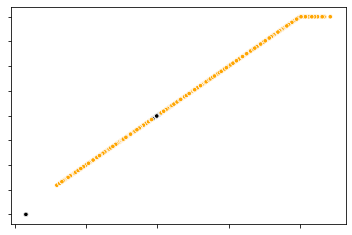

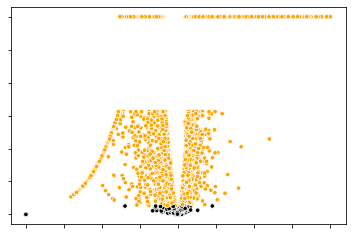

gene  pval  qval     log2fc          mean  zero_mean  \
5              A2M.2   0.0   0.0  10.607442  40434.639766      False   
19           AAMP.14   0.0   0.0   7.953033   2844.188981      False   
23           AARS.16   0.0   0.0   8.502291   4926.039692      False   
27        AATF.26574   0.0   0.0   7.538387   1878.796440      False   
67         ABCD1.215   0.0   0.0   7.817047   2482.564372      False   
...              ...   ...   ...        ...           ...        ...   
18845    ZNF207.7756   0.0   0.0   7.979851   2921.494467      False   
18874     ZNF24.7572   0.0   0.0   7.800720   2442.360585      False   
19147   ZNF638.27332   0.0   0.0   7.524083   1852.113583      False   
19164  ZNF664.144348   0.0   0.0   7.848037   2560.701761      False   
19311   ZNHIT1.10467   0.0   0.0   7.564956   1929.383065      False   

               grad   coef_mle   coef_sd           ll  
5      4.105780e-07  10.607442  0.062532 -2552.135938  
19     3.888455e-07   7.953033  0.020433 -1792.315805  
23     5.343007e-07   8.502291  0.033811 -2011.204575  
27     6.876414e-08   7.538387  0.021526 -1711.785110  
67     4.033875e-07   7.817047  0.064440 -1939.233135  
...             ...        ...       ...          ...  
18845  1.747190e-07   7.979851  0.014151 -1721.023185  
18874  1.515435e-07   7.800720  0.031519 -1844.160471  
19147  2.593673e-08   7.524083  0.025328 -1741.458732  
19164  7.596014e-07   7.848037  0.029020 -1839.076348  
19311  2.511316e-08   7.564956  0.034959 -1810.901693  

[2344 rows x 10 columns]

Empty DataFrame
Columns: [gene, pval, qval, log2fc, mean, zero_mean, grad, coef_mle, coef_sd, ll]
Index: []

In [26]:
# Running all the analysis
# Genes expression:
divide_damples_by_organs(dataframe_name='gene_data', column_name='gene')
run_analysis_genes()


/Users/NevoHome/Documents/University- History/Semester 4a/Workshop in Computational Analysis of Genomic Medical Data/project/acgt_melanoma/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

Transforming to str index.
Transforming to str index.
/Users/NevoHome/Documents/University- History/Semester 4a/Workshop in Computational Analysis of Genomic Medical Data/project/acgt_melanoma/venv/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning:

divide by zero encountered in log



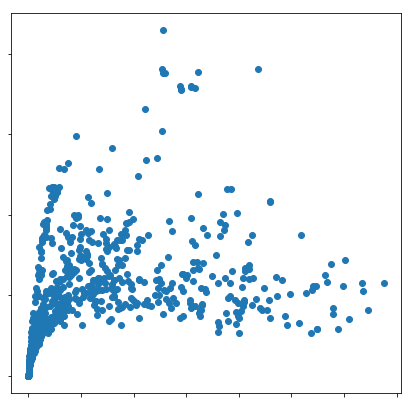

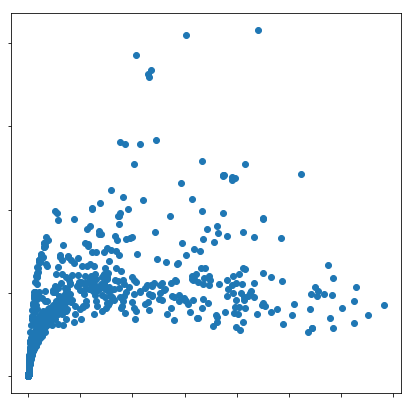

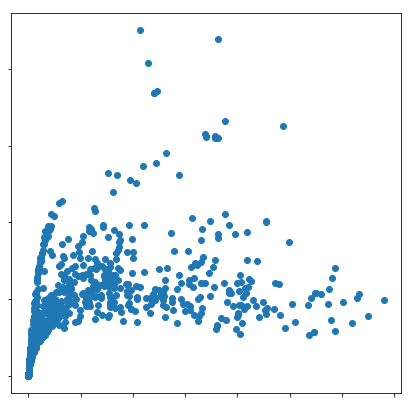

Performing differential expression tests and displaying sample results

Running Welch's T-Test:

           gene      pval      qval    log2fc          mean
0  hsa.let.7a.1  0.470561  0.638832 -0.066709  13940.059970
1  hsa.let.7a.2  0.461598  0.631660 -0.068212  27880.359916
2  hsa.let.7a.3  0.433644  0.607762 -0.072056  14072.978563
3    hsa.let.7b  0.255193  0.497626 -0.177389  24891.462067
4    hsa.let.7c  0.364385  0.551397 -0.192971   2124.068748

Running Rank-Sum Test:

           gene      pval      qval    log2fc          mean
0  hsa.let.7a.1  0.296132  0.505131 -0.066709  13940.059970
1  hsa.let.7a.2  0.274036  0.479843 -0.068212  27880.359916
2  hsa.let.7a.3  0.250389  0.458635 -0.072056  14072.978563
3    hsa.let.7b  0.079370  0.226243 -0.177389  24891.462067
4    hsa.let.7c  0.164109  0.361039 -0.192971   2124.068748

Printing MA plot: shows log2-fold changes vs mean expression

Graphing volcano plot: shows log fold change vs p-value

T-Test volcano plot:

Rank-Sum test vo

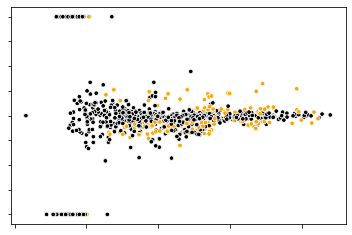

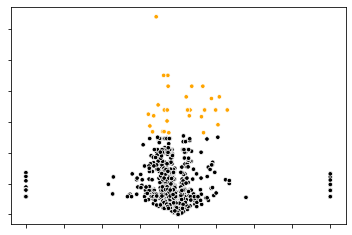

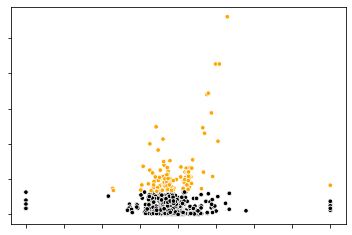

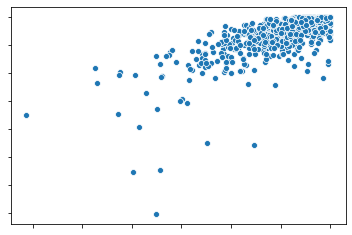

Empty DataFrame
Columns: [gene, pval, qval, log2fc, mean, zero_mean, zero_variance]
Index: []

Empty DataFrame
Columns: [gene, pval, qval, log2fc, mean, zero_mean, zero_variance]
Index: []

gene      pval      qval       log2fc      mean  zero_mean  \
1011  hsa.mir.890  0.002248  0.022168  1070.127115  0.039474      False   

      zero_variance  
1011          False

gene      pval      qval       log2fc      mean  zero_mean  \
509  hsa.mir.3650  0.008168  0.054754 -1068.089644  0.007011      False   
594  hsa.mir.3919  0.008168  0.054754 -1070.131446  0.028869      False   

     zero_variance  
509          False  
594          False

pval_x  log2fc_x  mean_x         gene    pval_y     log2fc_y    mean_y
0     NaN       NaN     NaN  hsa.mir.890  0.002248  1070.127115  0.039474

pval_x  log2fc_x  mean_x          gene    pval_y     log2fc_y    mean_y
0     NaN       NaN     NaN  hsa.mir.3650  0.008168 -1068.089644  0.007011
1     NaN       NaN     NaN  hsa.mir.3919  0.008168 -1070.131446  0.028869

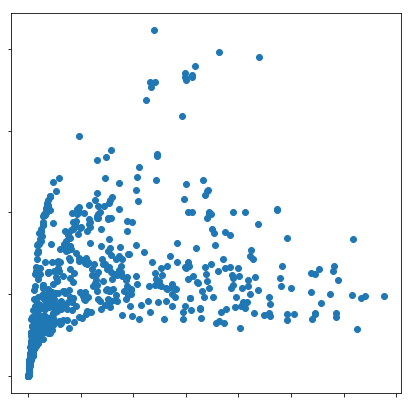

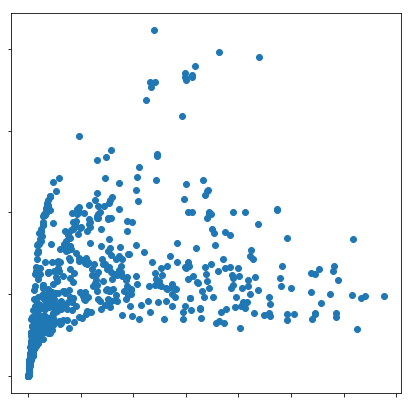

In [ ]:
# miRNA:
divide_damples_by_organs(dataframe_name='micro_rna_data', column_name='micro_rna')
run_analysis_miRNNA()


In [ ]:
# q-4 conclusion- TODO: Nevo

Research Questions and Analysis Methodology:
    
<u>Question # 3</u>

Research Questions and Analysis Methodology:

<u>Question # 4</u>

**Question: Which genes have a higher expression in tumors vs healthy skin? Are these genes similar to genes more highly expressed in metastases vs primary tumors?**

**Defining highly-expressed genes**

1. <u>Differential Gene Expression (DGE) Analysis</u>: (see description in "Methods")
    - **This analysis is designed to be performed on counts (expression), not normalized data!**
    - We selected to use 2 different methods for DGE Analysis:
        1. **Welch's t-tests**
        2. **Rank Sum tests**   
    - To determine if a gene has been significantly expressed, we will use in this section:
        - **P-value < 0.01** 
        - **log2FoldChange:** +/- 7.5 (the usual boundary is +/-2)
    - However, these tests are unfortunately not enough to deal with our data because we received gtex_data already partially normalized


2. <u>Our Version of Gene Expression Analysis</u>:
   - <u>why do we need this when we can use DGE analysis?</u>   
        - Most methods use a counts matrix that has not been normalized and perform calculations based on it. In the case of TCGA data, we have these counts matrix available. However, gtex data is a dataset we already received partially normalized (genes have a mean of zero). **Tests based on means cannot work for gtex data, because all of our means are zero**.
        - We read that to the actual count numbers in the gene expression dataset and the numbers that are the basis for the gtex dataset are derived by different methods, so one number cannot actually be compared to another directly.
        
   - <u>For these reasons, we also defined our own definition of highly-expressed genes, using our normalized datasets:</u> 
        - Per gene per dataset, we have a gene expression value per sample, but want to define a single gene expression value to use to represent that gene (so that we can compare all values and find large ones to be highly expressed)
        - We will use **median gene expression** per gene
            - The normalization affects the values, but medians per gene can have a range of values
            - We arbitrarily selected to look at genes with median values in the 99.9th percentile, but defined this as a parameter, and other values can also be examined
            - Per group of samples, we will select the genes with 99.9th percentile of highest median expression as "highly expressed" for that group
        
    
***Analysis Description:*** <br />
<u>Perform Differential Gene Expression (DGE) Analysis for Metastases Samples vs Primary Samples</u>:<br />
- Prep data for determining highly and slightly expressed genes/miRNA in a given non-normalized dataframe. As part of this process:
    1. Divide dataframe into a primary-samples-only dataframe and a metastases-samples-only-dataframe
    2. Plot the relationship between mean and std for the full dataframe, primary dataframe, metastases dataframe
    3. Transpose full dataframe to get a matrix where samples are rows, dimensions (genes/miRNA) for columns 
    4. Create a sample types dataset, where the condition is defined as: if metastasis sample: 1, otherwise 0
    5. Create an AnnData object that will hold our data matrix (X), sample descriptions, and and labels - and return it
- Perform differential expression analysis
    1. Run 2 types of tests on the data: Welch's t-test and rank sum test
    2. Display an MA plot (this should be used to help define limits used to limit log2foldchange for high, low expression)
    3. Graph volcano plots based on both tests to help differentiate significant values
    4. Plot a comparison of both tests
    5. Create a dataset of highly expressed genes/miRNAs and slightly expressed genes/miRNAs using 
        pvalue=0.01
        log2foldchange: lower than -7.5 for slightly expressed, higher than 7.5 for highly expressed
    6. merge all highly expressed genes into one dataframe, slightly expressed genes into one dataframe
    7. return highly expressed and slightly expressed dataframes

<u>Prep GTEX Data for Analysis</u>: <br />
- We had to match ensemble_ids in the gtex_data dataset, that contains healthy people skin samples, to 'genes' in the gene_data dataset <br />
    1. We researched the various types of gene IDs that exist, in order to understand which IDs we are actually looking at and need to translate between, because there are numerous gene id versions. According to our research: <br />
        - our gtex dataset uses enemble_ids, also referred to as: "gene stable id" <br />
        - our gene expression dataset uses a combination of "gene name" and "NCBI gene id", separated by a period  <br />
    2. We searched for methods for converting between these genes ids, and found several options: <br />
        - packages available only in R
        - an online conversion interface, http://www.ensembl.org/biomart/martview/
        - an online conversion interface, https://mygene.info/demo (we used it, but it had many missing translations)
    3. Eventually we managed to convert the most IDs using http://www.ensembl.org/biomart/martview/, so we selected that method, with the following parameters: <br />
        - FILTERS:  
            - GENE: Input external references ID list [Max 500 advised]: "Gene stable ID(s) 
        - ATTRIBUTES:
            - GENE: Ensembl: "Gene stable ID", "Gene name"
            - EXTERNAL: External References: NCBI Gene ID        
    4. Dealing with interface limitations: the interface can translate a maximum of 500 gene IDs at a time, therefore we divided the ensemble_ids in gtex_data into sub-datasets of 500 ids or less <br />
        - gtex_data contains 16593 ensemble_ids, so the dataset had to be divided int 34 datasets
        - each file was uploaded to the interface, and the results were saved in 34 text files called "mart_export (#).txt" 
        - the 34 result text files were combined into a single conversions dataset
        - a gene column was added to the conversions dataset, created using: "gene name"."NCBI gene id" where "NCBI gene id" was available, and "gene name" only where it was not available.
    5. The new conversions 'gene' column was merged into the gtex_data dataset
    6. Gtex_data was merged with the 'gene' column of gene_data, to examine the genes that could be matched
        - it is important to note that gene_data contains only genes that have high variance, because we removed all genes that had low variance values as part of the normalization and data cleaning process
    7. Only matched genes (a total of 5181 genes) were left in the gtex dataset


<u>Our Version of Gene Expression Analysis</u>:<br /> 
- Finding most highly expressed genes in metastases vs primary samples:<br />
    - We divided the gene expression dataset into a primary tumor dataset (01 samples) and a metastases dataset (06 samples)
    - We calculated the median value per gene (according to all samples in the group)
    - We graphed the median gene expression by sample type (primary/metastasis) to help select a cutoff line
    - We defined a cutoff line at gene expression medians in the  99.9 percentile (this percentile was arbitrarily selected, based on graphing, but it is a parameter that can be changed in the analysis)
    - We created a dataset for 01 samples and 06 samples that contains only genes with median values equal or greater than the 99.9th percentile value, and combined these results into one single dataset (highly_expressed_06_vs_01)
    
- compare to healthy skin to tumor sample <br />
    - We could not directly compare gene expression values in gene_data to the numbers in the gtex_data dataset, even for matching genes, because according to our research, the numbers are obtained through different processes before they are normalized
    - Per dataset (gtex_data, gene_data (all samples, 01 and 06 combined)) we calculated the median value per gene according to all relevant samples
    - We defined a cutoff line at medians in the  99.9 percentile
    - We created a dataset for gtex samples and tumor samples that contains only genes with median values equal or greater than the 99.9th percentile value, and combined these results into one single dataset (highly_expressed_gtex_vs_cancer)
    
- We created a combined dataset for highly-expressed genes in all datasets: highly_expressed_comparison (by combining highly_expressed_gtex_vs_cancer and highly_expressed_06_vs_01), and also graphed the dataset. <br />

***Conclusion:*** <br />

- Unfortunately, we could not use only differential gene expression analysis to get results for this question ecause the gtex data we received is already with zero means. 
- When we obtain highly-expressed genes for metastases vs primary with DGE and highly-expressed genes for cancer vs healthy skin in the different method we devised, there are no gene similarities. 
- However, if we use the method we created to analyze both cancer vs healthy skin and metastasis vs primary, we find similarities in some of our resulting genes:
    - We see that out of 11 genes that have a high expression in tumors, 7 (64%) are also highly expressed in metastases. These genes are: CSAG1.158511, MAGEA12.4111, MAGEA3.4102, MAGEA2.4101, CSAG3.389903, MAGEA6.4105, RPS28.6234
    - We see that out of 5 highly expressed genes in healthy skin, 1 gene (20%) is also highly expressed in metastases: RPS4Y1.6192



<u> Part 1: Differential Gene Expression Analysis For Metastases vs Primary Tumor </u>

In [126]:
# differential expression analysis using diffxpy 
# (installation instructions: https://github.com/theislab/diffxpy/blob/master/docs/installation.rst)

# import relevant packagees
import anndata
import logging
import scipy.stats
import batchglm
import diffxpy.api as de


# titles is a list of 3 titles to be used for log_and_plot graphs (in order)
# axis_name should either be 'gene' or 'miRNA', depending on the dataframe
"""
Prep data for determining highly and slightly expressed genes/miRNA in a given non-normalized dataframe
As part of this process:
1. Divide dataframe into a primary-samples-only dataframe and a metastases-samples-only-dataframe
2. Plot the relationship between mean and std for the full dataframe, primary dataframe, metastases dataframe
3. Transpose full datafrane to get a matrix where samples are rows, dimensions (genes/miRNA) for columns 
4. Create a sample types dataset, where the condition is defined as: if metastases sample: 1, otherwise 0
5. Create an AnnData object that will hold our data matrix (X), sample descriptions, and and labels - and return it
"""
def create_data_to_find_highly_and_slightly_expressed(dataframe_name, titles, axis_name):
    
    """
    divide not_normalized_dataframes[dataframe_name] into 
    - a dataset for primary samples (df_01)
    - a dataset for metastases samples (df_06)
    """
    
    # create dataset for primary samples (df_01)
    df_01 = pd.concat(
                [not_normalized_dataframes[dataframe_name][axis_name], 
                not_normalized_dataframes[dataframe_name].filter(like='.01',axis=1)], 
                axis=1, 
                sort=False)

    # create dataset for metastases samples (df_06)
    df_06 = pd.concat(
                [not_normalized_dataframes[dataframe_name][axis_name], 
                not_normalized_dataframes[dataframe_name].filter(like='.06',axis=1)], 
                axis=1, 
                sort=False)
    
    
    """
    per non-normalized dataframe, plot the relationship between mean and std
    """
    
    print("Graphing relationship between dataframe mean and std (after log2):\n")
    
    print("Full dataframe:")
    log_and_plot(not_normalized_dataframes[dataframe_name], axis_name, titles[0])
    
    print("Partial dataframe: primary tumor samples only:")
    log_and_plot(df_01, axis_name, titles[1])
    
    print("Partial dataframe: metastases samples only:")
    log_and_plot(df_06, axis_name, titles[2])    
    
    
    """
    transpose data to get a matrix of samples for rows, dimensions (genes) for columns (same function as Q1)
    """
    
    def transform_data(dataframe):
        a = dataframe.T
        a.columns = a.iloc[0]
        a = a.iloc[1:, :]
        X = a.to_numpy()  # convert a to numpy array (no row, column names) because algos we will use need this
        return a, X

    
    """
    per sample, create a dataset that describes the sample types
    
    ** condition definition ** : 1 for metastases, 0 for primary (because of the semantics of the question)

    example:

    if this is our original dataframe:
            sample1_01  sample2_01  sample3_06
    gene_a       x           y          z
    gene_b       a           b          c
    ...
    gene_n       f           g          h


    then this is our sample types dataset:
    # if 1 means metastases and 0 means not metastases --> primary:
    # the batch is needed because the data is accepted in this format
            condition   batch
    sample1     0         0
    sample2     0         0
    sample3     1         0

    """
    
    def create_sample_description_dataset(dataframe):
        sample_descriptions = pd.DataFrame([0 if x[-2:] == '01' else 1 for x in list(dataframe.index)])
        sample_descriptions['batch'] = 0
        sample_descriptions.columns = ['condition', 'batch']
        return sample_descriptions

    a, X = transform_data(not_normalized_dataframes[dataframe_name])
    sample_descriptions = create_sample_description_dataset(a)

    
    """
    create an AnnData object that will hold our data matrix (X), sample descriptions, and and labels
    """
    
    data = anndata.AnnData(
        X=X,
        var=pd.DataFrame(index=list(a.columns)), #labels: genes or miRNA
        obs=sample_descriptions
    )

    return data


"""
    Perform differential expression analysis
    1. Run 2 types of tests on the data: Welch's t-test and rank sum test
    2. Display an MA plot (this should be used to define the values of top, bottom)
    3. Graph volcano plots based on both tests to help differentiate significant values
    4. Plot a comparison of both tests
    5. Create a dataset of highly expressed genes/miRNAs and slightly expressed genes/miRNAs using 
        pvalue=0.01
        log2foldchange: lower than bottom for slightly expressed, higher than top for highly expressed
    6. merge all highly expressed genes into one dataframe, slightly expressed genes into one dataframe
    7. return highly expressed and slightly expressed dataframes
"""

def differential_expression_analysis(data, axis_name, bottom=-7.5, top=7.5, pval=0.01):
    
    """
    Running differential expression tests:
    
    1. Welch's t-test
    2. Rank sum test
    
    For t-tests and rank sum tests, the grouping argument indicates the the name of the relevant condition column 
    in the sample description
    """
    
    print("Performing differential expression tests and displaying sample results\n")
    
    print("Running Welch's T-Test:\n")
    
    # Welch's t-test
    test_tt = de.test.t_test(
        data=data,
        grouping="condition")
    
    # this model is built for analyzing genes, we want to change the 'gene' column to miRNA if necessary
    res_tt = test_tt.summary()
    res_tt.columns = [axis_name, 'pval', 'qval', 'log2fc', 'mean', 'zero_mean', 'zero_variance']
    print(res_tt.iloc[:5, :-2])
    
    
    print("\nRunning Rank-Sum Test:\n")
    # Rank sum test
    test_rank = de.test.rank_test(
        data=data,
        grouping="condition"
    )
    
    # this model is built for analyzing genes, we want to change the 'gene' column to miRNA if necessary
    res_rt = test_rank.summary()
    res_rt.columns = [axis_name, 'pval', 'qval', 'log2fc', 'mean', 'zero_mean', 'zero_variance']
    print(res_rt.iloc[:5, :-2])    
    
    
    """
    MA Plot
    An MA-plot is a 2D plot that shows the log2-fold change vs mean expression
    """
    print("\nPrinting MA plot: shows log2-fold changes vs mean expression")
    test_tt.plot_ma()

        
    """
    Volcano Plot
    A volcano plot is a 2D scatter plot shaped like a volcano
    It is used to show statistically significant gene expression changes from two different conditions
    It displays log fold change vs p-value

    """
    print("\nGraphing volcano plot: shows log fold change vs p-value\n")
    
    print("T-Test volcano plot:\n")
    test_tt.plot_volcano()

    print("Rank-Sum test volcano plot:\n")
    test_rank.plot_volcano()
   

    """
    Scatter plot of log10_pval for t-test vs log10_pval for rank sum test:
    """
    
    print("Graphing log10_pval for t-test (x axis) vs log10_pval for rank sum test (y axis)")
    # compare 2 results
    sns.scatterplot(x=test_tt.log10_pval_clean(), y=test_rank.log10_pval_clean())
    plt.show()
    
    
    """
    Returning Highly and Slightly Expressed Genes
    To determine if a gene has been significantly expressed, we use:
    1. P-value: 0.01
    2. log2FoldChange: we add as a parameter to the function. 
        we read that fold-change of +/- 2 is often used as the threshold for defining significant differential 
        expression, therefore we will use a minimum of log fold-change +2 to define highly-expressed genes and
        a maximum of -2 to define slightly expressed genes. However, we will select actual values to use by 
        examining an MA-Plot and seeing outlying values graphically.     
    """
    
    print("\nDetermining which {}s are highly/slightly expressed using:".format(axis_name))
    print("p-value: 0.01 or lower")
    print("log2FoldChange: {} or greater for highly expressed, {} or lower for slightly expressed".format(top, bottom))

    # defining highly-expressed genes based on t-test
    highly_expressed_tt = test_tt.summary()
    highly_expressed_tt = highly_expressed_tt[(highly_expressed_tt.pval < pval) & (highly_expressed_tt.log2fc >= top)]
    
    # defining slightly-expressed genes based on t-test
    slightly_expressed_tt = test_tt.summary()
    slightly_expressed_tt = slightly_expressed_tt[
                                                (slightly_expressed_tt.pval < pval) & 
                                                (slightly_expressed_tt.log2fc <= bottom)]
    
    
    # this model is built for analyzing genes, we want to change the 'gene' to miRNA if necessary
    highly_expressed_tt.columns = [axis_name, 'pval', 'qval', 'log2fc', 'mean', 'zero_mean', 'zero_variance']
    slightly_expressed_tt.columns = [axis_name, 'pval', 'qval', 'log2fc', 'mean', 'zero_mean', 'zero_variance']
    
    print("\nT-Test Results:")
    print("\nHighly Expressed Genes:\n")
    display(highly_expressed_tt)
    
    print("\nSlightly Expressed Genes:\n")
    display(slightly_expressed_tt)
    
    # defining highly-expressed genes based on rank-sum test
    highly_expressed_rt = test_rank.summary()
    highly_expressed_rt = highly_expressed_rt[(highly_expressed_rt.pval < pval) & (highly_expressed_rt.log2fc >= top)]

    # defining slightly-expressed genes based on t-test
    slightly_expressed_rt = test_rank.summary()
    slightly_expressed_rt = slightly_expressed_rt[
                                                (slightly_expressed_rt.pval < pval) &
                                                (slightly_expressed_rt.log2fc <= bottom)]
    
    
    # this model is built for analyzing genes, we want to change the 'gene' column to miRNA if necessary
    highly_expressed_rt.columns = [axis_name, 'pval', 'qval', 'log2fc', 'mean', 'zero_mean', 'zero_variance']
    slightly_expressed_rt.columns = [axis_name, 'pval', 'qval', 'log2fc', 'mean', 'zero_mean', 'zero_variance']
    
    print("\nRank-Sum Results:")
    print("\nHighly Expressed Genes:\n")
    display(highly_expressed_rt)
    
    print("\nSlightly Expressed Genes:\n")
    display(slightly_expressed_rt)

    # combine hightly-expressed dataframes
    highly_expressed = pd.merge(
                            highly_expressed_tt[[axis_name, 'pval', 'log2fc', 'mean']] , 
                            highly_expressed_rt[[axis_name, 'pval', 'log2fc', 'mean']], 
                            on=axis_name, 
                            how='outer')

    slightly_expressed = pd.merge(
                            slightly_expressed_tt[[axis_name, 'pval', 'log2fc', 'mean']] , 
                            slightly_expressed_rt[[axis_name, 'pval', 'log2fc', 'mean']], 
                            on=axis_name, 
                            how='outer')
    
    print("\nOverall highly expresed:")
    display(highly_expressed)
    print("\nOverall slightly expresed:")
    display(slightly_expressed)
    
    return highly_expressed, slightly_expressed


Graphing relationship between dataframe mean and std (after log2):

Full dataframe:


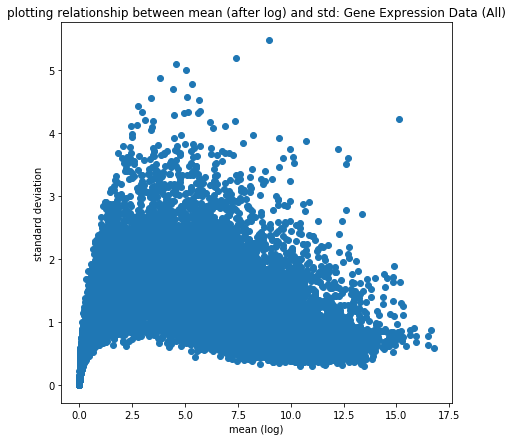

Partial dataframe: primary tumor samples only:


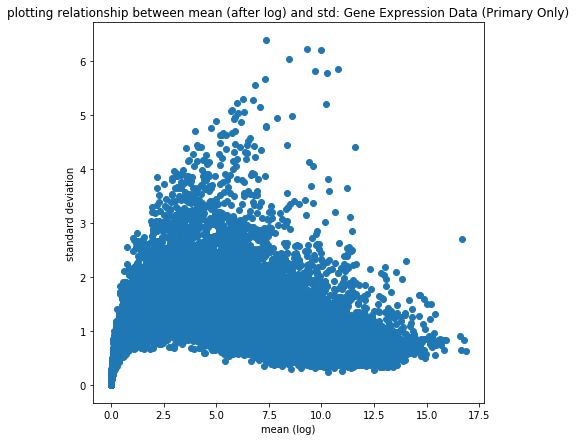

Partial dataframe: metastases samples only:


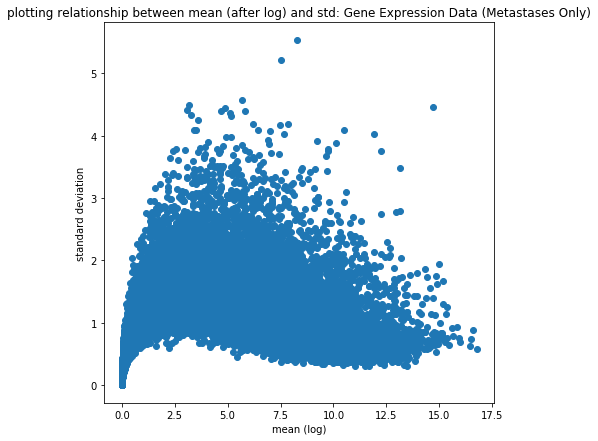

Transforming to str index.


In [127]:
# prep gene expression data for differential expression analysis and graph log mean vs std

titles = ['Gene Expression Data (All)', 'Gene Expression Data (Primary Only)', 'Gene Expression Data (Metastases Only)']
data_genes = create_data_to_find_highly_and_slightly_expressed('gene_data', titles, 'gene')


Performing differential expression tests and displaying sample results

Running Welch's T-Test:

           gene      pval      qval    log2fc        mean
0        A1BG.1  0.001069  0.005596 -0.548340  294.801172
1    A1CF.29974  0.878604  0.921598 -0.160835    0.175014
2   A2BP1.54715  0.385012  0.523108 -2.700799    4.697858
3   A2LD1.87769  0.073438  0.153855 -0.178384  101.314465
4  A2ML1.144568  0.000076  0.000671 -4.328338  251.987262

Running Rank-Sum Test:

           gene          pval          qval    log2fc        mean
0        A1BG.1  1.003637e-05  8.401385e-05 -0.548340  294.801172
1    A1CF.29974  3.992502e-01  5.233949e-01 -0.160835    0.175014
2   A2BP1.54715  6.614095e-01  7.532511e-01 -2.700799    4.697858
3   A2LD1.87769  3.563117e-02  7.683487e-02 -0.178384  101.314465
4  A2ML1.144568  7.830184e-15  7.043103e-13 -4.328338  251.987262

Printing MA plot: shows log2-fold changes vs mean expression


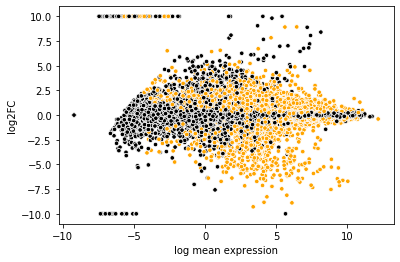


Graphing volcano plot: shows log fold change vs p-value

T-Test volcano plot:



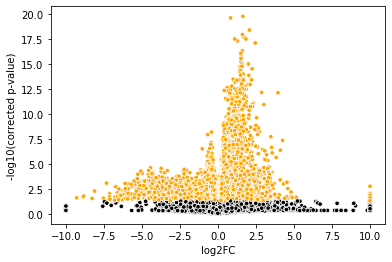

Rank-Sum test volcano plot:



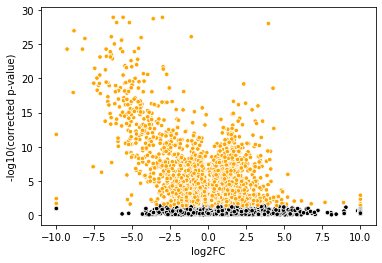

Graphing log10_pval for t-test (x axis) vs log10_pval for rank sum test (y axis)


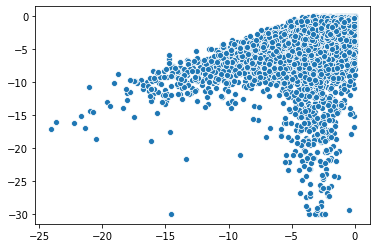


Determining which genes are highly/slightly expressed using:
p-value: 0.01 or lower
log2FoldChange: 7.5 or greater for highly expressed, -7.5 or lower for slightly expressed

T-Test Results:

Highly Expressed Genes:



gene      pval      qval       log2fc      mean  \
5569       FAM138B.654412  0.000246  0.001718  1069.610675  0.037283   
6533             GIP.2695  0.009081  0.029979  1069.524744  0.035127   
9230     LOC154449.154449  0.004802  0.018216  1068.655280  0.019227   
9307     LOC285375.285375  0.003603  0.014504  1067.974434  0.011994   
9560     LOC730811.730811  0.002410  0.010678  1067.552621  0.008953   
11687       OR11G2.390439  0.008949  0.029615  1066.841179  0.005468   
11738       OR2A12.346525  0.001657  0.007911  1067.636551  0.009489   
12819        PLGLA.285189  0.004218  0.016421  1067.510231  0.008694   
15748  SNORA38B.100124536  0.002061  0.009421  1068.005334  0.012253   
16702        TAS2R7.50837  0.003309  0.013621  1068.183079  0.013860   
17730           TSHB.7252  0.007413  0.025583  1067.549333  0.008933   

       zero_mean  zero_variance  
5569       False          False  
6533       False          False  
9230       False          False  
9307       False          False  
9560       False          False  
11687      False          False  
11738      False          False  
12819      False          False  
15748      False          False  
16702      False          False  
17730      False          False


Slightly Expressed Genes:



gene      pval      qval    log2fc         mean  zero_mean  \
4570      DEFB4A.1673  0.007138  0.024871 -9.288885    29.219999      False   
8667     KRT6C.286887  0.008132  0.027537 -7.534058  6895.910799      False   
8861     LCE3E.353145  0.008471  0.028419 -8.277418    76.602001      False   
14575  S100A7A.338324  0.000986  0.005252 -8.116672   310.107806      False   
16240     SPRR2G.6706  0.005677  0.020834 -8.887956   444.402500      False   
18473   WFDC12.128488  0.004220  0.016428 -8.834378    62.517250      False   

       zero_variance  
4570           False  
8667           False  
8861           False  
14575          False  
16240          False  
18473          False


Rank-Sum Results:

Highly Expressed Genes:



gene      pval      qval       log2fc         mean  \
2204   C20orf70.140683  0.004872  0.014789     7.671862    59.939656   
4157         CSN2.1447  0.001305  0.004916    10.984137     5.933407   
5569    FAM138B.654412  0.009415  0.025590  1069.610675     0.037283   
14713     SCGB1A1.7356  0.000276  0.001334    11.141320    57.647970   
16407       STATH.6779  0.005379  0.016077     8.890804  1297.589287   

       zero_mean  zero_variance  
2204       False          False  
4157       False          False  
5569       False          False  
14713      False          False  
16407      False          False


Slightly Expressed Genes:



gene          pval          qval       log2fc         mean  \
4543   DEFB108B.245911  1.045823e-03  4.079952e-03 -1067.996702     0.003409   
4570       DEFB4A.1673  5.166131e-28  4.925647e-25    -9.288885    29.219999   
8667      KRT6C.286887  1.366750e-22  4.917463e-20    -7.534058  6895.910799   
8686         KRT9.3857  1.957202e-14  1.615666e-12   -10.870980   282.939480   
8858      LCE3B.353143  7.532479e-03  2.123863e-02 -1068.863119     0.006215   
8859      LCE3C.353144  3.264622e-09  8.688481e-08    -7.575577     2.002315   
8861      LCE3E.353145  4.946981e-28  4.925647e-25    -8.277418    76.602001   
11850      OR4P4.81300  7.532479e-03  2.123863e-02 -1068.002888     0.003424   
11939     OR5L1.219437  7.532479e-03  2.123863e-02 -1067.005570     0.001715   
14575   S100A7A.338324  8.537951e-30  1.356752e-26    -8.116672   310.107806   
14717   SCGB1D4.404552  7.532479e-03  2.123863e-02 -1069.215766     0.007936   
16114   SPAG11A.653423  1.045823e-03  4.079952e-03 -1067.747207     0.002868   
16240      SPRR2G.6706  4.605457e-21  1.155546e-18    -8.887956   444.402500   
18473    WFDC12.128488  4.176581e-31  9.955404e-28    -8.834378    62.517250   

       zero_mean  zero_variance  
4543       False          False  
4570       False          False  
8667       False          False  
8686       False          False  
8858       False          False  
8859       False          False  
8861       False          False  
11850      False          False  
11939      False          False  
14575      False          False  
14717      False          False  
16114      False          False  
16240      False          False  
18473      False          False


Overall highly expresed:


gene    pval_x     log2fc_x    mean_x    pval_y  \
0       FAM138B.654412  0.000246  1069.610675  0.037283  0.009415   
1             GIP.2695  0.009081  1069.524744  0.035127       NaN   
2     LOC154449.154449  0.004802  1068.655280  0.019227       NaN   
3     LOC285375.285375  0.003603  1067.974434  0.011994       NaN   
4     LOC730811.730811  0.002410  1067.552621  0.008953       NaN   
5        OR11G2.390439  0.008949  1066.841179  0.005468       NaN   
6        OR2A12.346525  0.001657  1067.636551  0.009489       NaN   
7         PLGLA.285189  0.004218  1067.510231  0.008694       NaN   
8   SNORA38B.100124536  0.002061  1068.005334  0.012253       NaN   
9         TAS2R7.50837  0.003309  1068.183079  0.013860       NaN   
10           TSHB.7252  0.007413  1067.549333  0.008933       NaN   
11     C20orf70.140683       NaN          NaN       NaN  0.004872   
12           CSN2.1447       NaN          NaN       NaN  0.001305   
13        SCGB1A1.7356       NaN          NaN       NaN  0.000276   
14          STATH.6779       NaN          NaN       NaN  0.005379   

       log2fc_y       mean_y  
0   1069.610675     0.037283  
1           NaN          NaN  
2           NaN          NaN  
3           NaN          NaN  
4           NaN          NaN  
5           NaN          NaN  
6           NaN          NaN  
7           NaN          NaN  
8           NaN          NaN  
9           NaN          NaN  
10          NaN          NaN  
11     7.671862    59.939656  
12    10.984137     5.933407  
13    11.141320    57.647970  
14     8.890804  1297.589287


Overall slightly expresed:


gene    pval_x  log2fc_x       mean_x        pval_y  \
0       DEFB4A.1673  0.007138 -9.288885    29.219999  5.166131e-28   
1      KRT6C.286887  0.008132 -7.534058  6895.910799  1.366750e-22   
2      LCE3E.353145  0.008471 -8.277418    76.602001  4.946981e-28   
3    S100A7A.338324  0.000986 -8.116672   310.107806  8.537951e-30   
4       SPRR2G.6706  0.005677 -8.887956   444.402500  4.605457e-21   
5     WFDC12.128488  0.004220 -8.834378    62.517250  4.176581e-31   
6   DEFB108B.245911       NaN       NaN          NaN  1.045823e-03   
7         KRT9.3857       NaN       NaN          NaN  1.957202e-14   
8      LCE3B.353143       NaN       NaN          NaN  7.532479e-03   
9      LCE3C.353144       NaN       NaN          NaN  3.264622e-09   
10      OR4P4.81300       NaN       NaN          NaN  7.532479e-03   
11     OR5L1.219437       NaN       NaN          NaN  7.532479e-03   
12   SCGB1D4.404552       NaN       NaN          NaN  7.532479e-03   
13   SPAG11A.653423       NaN       NaN          NaN  1.045823e-03   

       log2fc_y       mean_y  
0     -9.288885    29.219999  
1     -7.534058  6895.910799  
2     -8.277418    76.602001  
3     -8.116672   310.107806  
4     -8.887956   444.402500  
5     -8.834378    62.517250  
6  -1067.996702     0.003409  
7    -10.870980   282.939480  
8  -1068.863119     0.006215  
9     -7.575577     2.002315  
10 -1068.002888     0.003424  
11 -1067.005570     0.001715  
12 -1069.215766     0.007936  
13 -1067.747207     0.002868

In [128]:
# perform differential expression analysis and find hgihly/slightly expressed genes

highly_expressed_genes_06_vs_01, slightly_expressed_genes_06_vs_01 = differential_expression_analysis(data_genes,
                                                                                                      'gene')


<u> Part 2: Our Version of Gene Expression Analysis For Heathly Skin vs Tumors </u>

In [129]:
# pass 'mean' or 'median' as mean_or_median
def plot_highly_expressed_genes(data, mean_or_median, title_additions):           
    plt.figure(figsize=(10, 10))
    plt.title('{} gene expression {}'.format(mean_or_median, title_additions))
    sns.barplot(x = data['gene'], y = data['{}_exp'.format(mean_or_median)])
    plt.xlabel("highly expressed genes {}".format(title_additions))
    plt.xticks(rotation=90)
    plt.ylabel("{} gene expression value after normalizing".format(mean_or_median))

    
def find_highly_expressed_medians(data, quantile, title_additions):
    # creade a dataset of gene name, median gene expression per gene based on given data
    medians = pd.concat([data['gene'], data.iloc[:, 1:].median(axis=1)], axis=1, sort=False)
    medians.columns = ['gene', 'median_exp']
    
    # sort new dataset by median gene expression (high to low), this is used for making a pretty graph
    medians = medians.sort_values(by = 'median_exp', ascending=False)
    
    # we want to define the top quantile-th percentile of values
    medians_limit = round(medians['median_exp'].quantile(quantile), 2)
    print("medians ", quantile*100, "-th percentile value: ", medians_limit)

    # keep only values greater or equal to limit
    highly_expressed_medians = medians[medians['median_exp'] >= medians_limit]
    
    # graph results
    plot_highly_expressed_genes(highly_expressed_medians, 'median', title_additions)
    
    highly_expressed_medians.columns = ['gene', 'median_exp']
    return medians, highly_expressed_medians


def combine_highly_expressed_datasets(highly_expressed_data_1, highly_expressed_data_2, name_data_1, name_data_2):
    if name_data_1 is not None and name_data_2 is not None:
        highly_expressed_data_1.columns = ['gene', 'median_exp_{}'.format(name_data_1)]
        highly_expressed_data_2.columns = ['gene', 'median_exp_{}'.format(name_data_2)]
    return pd.merge(highly_expressed_data_1, highly_expressed_data_2, on='gene', how='outer')


# pass 'mean' or 'median' as mean_or_median
def plot_mean_or_median_gene_expression(mean_or_median, data, ylabel_additions):
    #plotting means of genes exp (this is a subset of data we previously normalized)
    plt.figure(figsize=(10, 10))
    plt.title("{} gene expression by gene".format(mean_or_median))
    sns.barplot(x = data['gene'], y = data['{}_exp'.format(mean_or_median)]) #this takes a long time
    plt.xlabel("gene")
    plt.ylabel("{} gene expression value {}".format(mean_or_median, ylabel_additions))

Match GTEX ensemble_id with gene expression gene ids:

   1. clean data
   2. export ensemble ids in batches small enough for inputing into http://www.ensembl.org/biomart/martview/ -> max 500, resulting in exported 34 files
   3. enter http://www.ensembl.org/biomart/martview/
       FILTERS:  
       - GENE: Input external references ID list [Max 500 advised]: "Gene stable ID(s) 
       ATTRIBUTES:
       - GENE: Ensembl: "Gene stable ID", "Gene name"
       - EXTERNAL: External References: NCBI Gene ID
       Results were saved in 34 text files called "mart_export (#).txt"
   4. Importing results and combine them into one df (conversions)
   5. Creating a 'gene' column using 'Gene name'.'NCBI gene ID'
   6. Merging into gtex data only genes with names that were also found in gene expression data
   7. Drop unecessary columns (used for matching and merging), and re-order columns

In [130]:
# clean gtex_data dataframe


# remove quotations from ensemble_id (the dataset has each ensemble_id enveloped by quotations)
def remove_quotations(row):
    row.ensemble_id = row.ensemble_id.strip('"')
    return row

dataframes['gtex_data'] = dataframes['gtex_data'].apply(remove_quotations, axis = 'columns')

In [131]:
# export ensemble ids in batches small enough for inputing into http://www.ensembl.org/biomart/martview/ -> max 500


# divide gtex_data's ensemble ids into sections of 500 genes or less, so we need 34 datasets of 500 genes
ensemble_dfs = {}

data = dataframes['gtex_data']['ensemble_id']
for x in range(34):
    df = pd.DataFrame()
    df = data[:500]
    ensemble_dfs[x] = df
    data = data[500:]

# export values to CSV
for x in range(34):
    ensemble_dfs[x].to_csv('{}.csv'.format(x), index=False)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning:

The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.



In [132]:
# importing results and combining them into one df

names = ['ensemble_id' , 'Gene name', 'NCBI gene ID']
conversions = pd.read_csv('mart_export (0).txt', names=names, skiprows=1, sep=",")

for x in range(1, 34):
    df = pd.read_csv('mart_export ({}).txt'.format(x), names=names, skiprows=1, sep=",")
    conversions = pd.concat([conversions, df], axis=0, sort=False).reset_index(drop=True)


print("shape: ", conversions.shape)
display(conversions.head())

shape:  (16093, 3)


ensemble_id Gene name  NCBI gene ID
0  ENSG00000000938       FGR        2268.0
1  ENSG00000001460     STPG1       90529.0
2  ENSG00000001461    NIPAL3       57185.0
3  ENSG00000004455       AK2         204.0
4  ENSG00000004487     KDM1A       23028.0

In [133]:
import math

def create_gene_name(row):
    ncbi_gene_id = float(row['NCBI gene ID'])
    if not math.isnan(ncbi_gene_id):
        ncbi_gene_id = str(int(ncbi_gene_id))
        row.gene = row['Gene name'] + "." + ncbi_gene_id
    else:
        row.gene = row['Gene name']
    return row

# in order for apply to work, the column ['gene'] should already exist in dataframe
conversions['gene'] = np.nan

# update conversions to include a row of "Gene name"."NCBI gene ID", they both exist
conversions = conversions.apply(create_gene_name, axis = 'columns')

In [134]:
# merging

dataframes['gtex_data'] = pd.merge(
                                dataframes['gtex_data'], 
                                conversions[['ensemble_id', 'gene']], 
                                on='ensemble_id', 
                                how='left')

# trying to match rows from dataframes['gene_data']
dataframes['gene_data']['gene2'] = dataframes['gene_data']['gene']

m = pd.merge(
        dataframes['gtex_data'], 
        dataframes['gene_data'][['gene', 'gene2']], 
        on='gene', 
        how='inner')


In [135]:
# We managed to match only 5181 genes (this is not terrible, taking into account gene expression data removed many genes)
# we'll preform the analysis with only matched genes


# comparing only matched genes
dataframes['gtex_data'] = m
dataframes['gtex_data'].head()
dataframes['gtex_data'] = dataframes['gtex_data'].drop(columns=['ensemble_id', 'gene2'])


# reorder columns for gtex_data
cols = list(dataframes['gtex_data'].columns)
cols = [cols[-1]] + [x for x in cols[:-1]]
dataframes['gtex_data']  = dataframes['gtex_data'][cols]

dataframes['gtex_data'].head()

gene  GTEX-111YS-0006-SM-5NQBE  GTEX-1122O-0005-SM-5O99J  \
0  KLHL17.339451                 -0.279908                 -0.835156   
1  PLEKHN1.84069                 -0.200912                 -1.013192   
2     HES4.57801                  0.227358                  2.186521   
3     ISG15.9636                  0.193308                  1.331465   
4    AGRN.375790                 -0.274640                  1.210520   

   GTEX-1128S-0005-SM-5P9HI  GTEX-113IC-0006-SM-5NQ9C  \
0                 -0.408072                 -1.410811   
1                  0.641047                  1.477039   
2                 -0.430179                  2.149775   
3                 -1.224713                  2.529799   
4                  0.141486                  3.308054   

   GTEX-113JC-0006-SM-5O997  GTEX-117XS-0005-SM-5PNU6  \
0                  0.523505                 -0.521197   
1                  0.372336                 -1.923460   
2                  1.411524                 -1.272982   
3                  3.673485                 -0.275449   
4                  4.207091                 -0.848101   

   GTEX-117YW-0005-SM-5NQ8Z  GTEX-1192W-0005-SM-5NQBQ  \
0                  0.053786                 -0.106698   
1                 -0.756503                 -1.661922   
2                 -0.855489                  0.464439   
3                 -0.389703                  0.486343   
4                  0.224843                  0.175697   

   GTEX-11DXW-0006-SM-5NQ7Y  ...  GTEX-ZVE2-0006-SM-51MRW  \
0                 -0.260480  ...                 2.496293   
1                 -2.192522  ...                 1.438572   
2                  0.101561  ...                 0.641636   
3                 -0.203910  ...                -0.448540   
4                 -0.658319  ...                -0.077691   

   GTEX-ZVP2-0005-SM-51MRK  GTEX-ZVT2-0005-SM-57WBW  GTEX-ZVT3-0006-SM-51MT9  \
0                -0.158198                 0.327074                -1.277016   
1                -0.931609                -2.508796                -1.060247   
2                 1.522860                 0.658801                 0.245804   
3                -2.588012                 0.469086                 0.305854   
4                -1.306012                 1.015157                -0.983269   

   GTEX-ZVT4-0006-SM-57WB8  GTEX-ZVTK-0006-SM-57WBK  GTEX-ZVZP-0006-SM-51MSW  \
0                -0.452272                 0.132588                -0.647277   
1                 2.616110                 0.229421                 0.735088   
2                -0.213726                -0.422631                -0.968229   
3                 0.892913                -0.720614                 0.052023   
4                -0.732651                -0.796740                -0.016115   

   GTEX-ZVZQ-0006-SM-51MR8  GTEX-ZXES-0005-SM-57WCB  GTEX-ZXG5-0005-SM-57WCN  
0                -1.332039                -1.091149                 0.791253  
1                -0.182378                -0.584952                 1.269399  
2                -0.134881                -1.354220                -0.103158  
3                -0.798169                 0.626281                -1.101371  
4                -0.402000                 1.133667                -1.043875  

[5 rows x 394 columns]

Highly Expressed Genes: GTEX 
medians  99.9 -th percentile value:  0.5


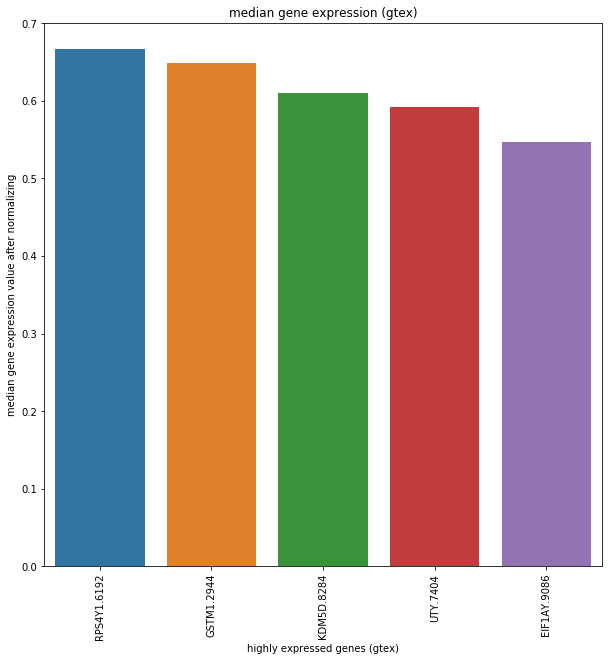

In [136]:
print("Highly Expressed Genes: GTEX ")
df_gtex, highly_expressed_medians_gtex = find_highly_expressed_medians(dataframes['gtex_data'], 0.999, "(gtex)")

Highly Expressed Genes: Tumors(primary/metastases) 
medians  99.9 -th percentile value:  0.37


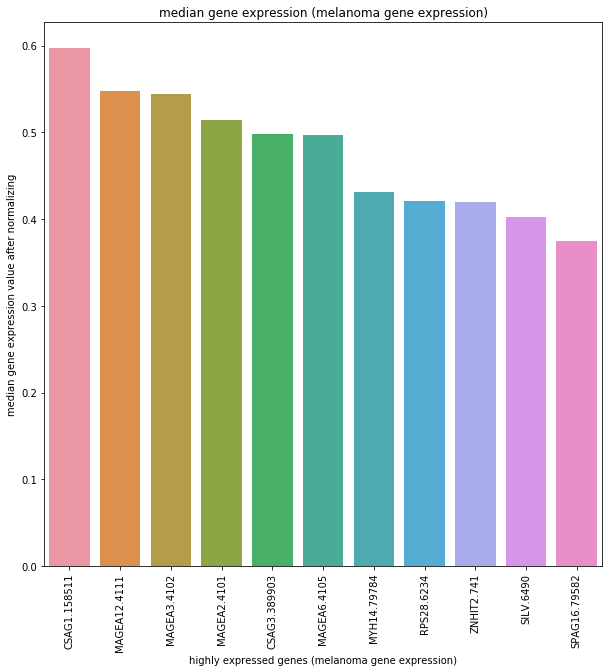

In [137]:
print("Highly Expressed Genes: Tumors(primary/metastases) ")
df_cancer, highly_expressed_medians_cancer = find_highly_expressed_medians(dataframes['gene_data'], 0.999, "(melanoma gene expression)")

In [138]:
highly_expressed_gtex_vs_cancer = combine_highly_expressed_datasets(
                                                                highly_expressed_medians_gtex, 
                                                                highly_expressed_medians_cancer, 
                                                                'gtex', 
                                                                'tumor')

highly_expressed_gtex_vs_cancer

gene  median_exp_gtex  median_exp_tumor
0    RPS4Y1.6192         0.667302               NaN
1     GSTM1.2944         0.649312               NaN
2     KDM5D.8284         0.610324               NaN
3       UTY.7404         0.592438               NaN
4    EIF1AY.9086         0.547142               NaN
5   CSAG1.158511              NaN          0.596801
6   MAGEA12.4111              NaN          0.547988
7    MAGEA3.4102              NaN          0.544647
8    MAGEA2.4101              NaN          0.514051
9   CSAG3.389903              NaN          0.497883
10   MAGEA6.4105              NaN          0.496738
11   MYH14.79784              NaN          0.430708
12    RPS28.6234              NaN          0.420327
13    ZNHIT2.741              NaN          0.420014
14     SILV.6490              NaN          0.402322
15  SPAG16.79582              NaN          0.374652

Option 1 Results

In [139]:
highly_expressed_v1 = pd.merge(
        highly_expressed_genes_06_vs_01[['gene', 'mean_x', 'mean_y']], 
        highly_expressed_gtex_vs_cancer, 
        on='gene', 
        how='outer')

highly_expressed_v1

gene    mean_x       mean_y  median_exp_gtex  \
0       FAM138B.654412  0.037283     0.037283              NaN   
1             GIP.2695  0.035127          NaN              NaN   
2     LOC154449.154449  0.019227          NaN              NaN   
3     LOC285375.285375  0.011994          NaN              NaN   
4     LOC730811.730811  0.008953          NaN              NaN   
5        OR11G2.390439  0.005468          NaN              NaN   
6        OR2A12.346525  0.009489          NaN              NaN   
7         PLGLA.285189  0.008694          NaN              NaN   
8   SNORA38B.100124536  0.012253          NaN              NaN   
9         TAS2R7.50837  0.013860          NaN              NaN   
10           TSHB.7252  0.008933          NaN              NaN   
11     C20orf70.140683       NaN    59.939656              NaN   
12           CSN2.1447       NaN     5.933407              NaN   
13        SCGB1A1.7356       NaN    57.647970              NaN   
14          STATH.6779       NaN  1297.589287              NaN   
15         RPS4Y1.6192       NaN          NaN         0.667302   
16          GSTM1.2944       NaN          NaN         0.649312   
17          KDM5D.8284       NaN          NaN         0.610324   
18            UTY.7404       NaN          NaN         0.592438   
19         EIF1AY.9086       NaN          NaN         0.547142   
20        CSAG1.158511       NaN          NaN              NaN   
21        MAGEA12.4111       NaN          NaN              NaN   
22         MAGEA3.4102       NaN          NaN              NaN   
23         MAGEA2.4101       NaN          NaN              NaN   
24        CSAG3.389903       NaN          NaN              NaN   
25         MAGEA6.4105       NaN          NaN              NaN   
26         MYH14.79784       NaN          NaN              NaN   
27          RPS28.6234       NaN          NaN              NaN   
28          ZNHIT2.741       NaN          NaN              NaN   
29           SILV.6490       NaN          NaN              NaN   
30        SPAG16.79582       NaN          NaN              NaN   

    median_exp_tumor  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  
5                NaN  
6                NaN  
7                NaN  
8                NaN  
9                NaN  
10               NaN  
11               NaN  
12               NaN  
13               NaN  
14               NaN  
15               NaN  
16               NaN  
17               NaN  
18               NaN  
19               NaN  
20          0.596801  
21          0.547988  
22          0.544647  
23          0.514051  
24          0.497883  
25          0.496738  
26          0.430708  
27          0.420327  
28          0.420014  
29          0.402322  
30          0.374652

Option 2 Results

Highly Expressed Genes: Primary Tumor
medians  99.9 -th percentile value:  1.18
Highly Expressed Genes: Metastases
medians  99.9 -th percentile value:  0.41


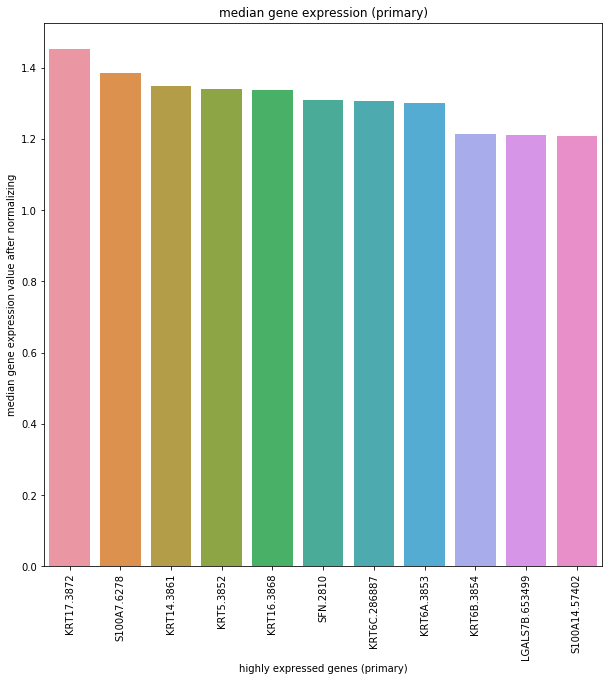

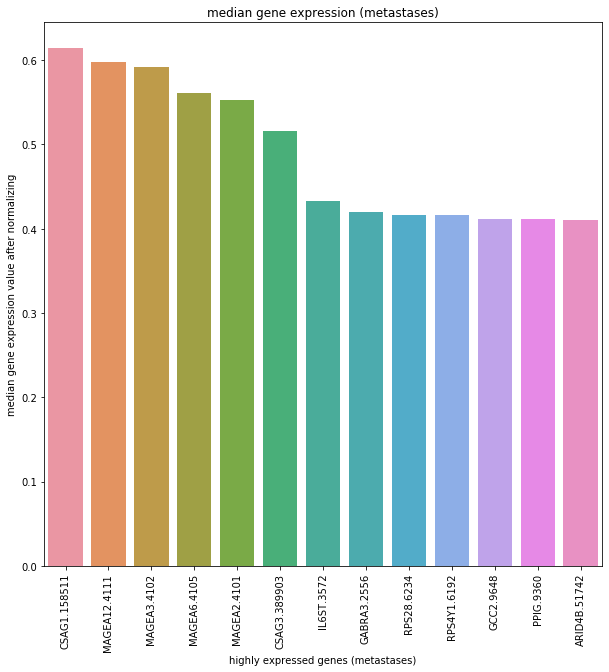

In [140]:
# We will try to use the same method we invented to analyze gene expression data for 01, 06 separately

df_01 = pd.concat(
                [dataframes['gene_data']['gene'], 
                dataframes['gene_data'].filter(like='.01',axis=1)], 
                axis=1, 
                sort=False)

# create dataset for metastases samples (df_06)
df_06 = pd.concat(
                [dataframes['gene_data']['gene'], 
                dataframes['gene_data'].filter(like='.06',axis=1)], 
                axis=1, 
                sort=False)

print("Highly Expressed Genes: Primary Tumor")
df_01, highly_expressed_medians_01 = find_highly_expressed_medians(df_01, 0.999, "(primary)")

print("Highly Expressed Genes: Metastases")
df_06, highly_expressed_medians_06 = find_highly_expressed_medians(df_06, 0.999, "(metastases)")


# combining resulting dataframes
highly_expressed_06_vs_01_v2 = combine_highly_expressed_datasets(
                                                        highly_expressed_medians_01, 
                                                        highly_expressed_medians_06, 
                                                        '01', 
                                                        '06')


# compare highly_expressed_gtex_vs_cancer with highly_expressed_06_vs_01_v2

highly_expressed_comparison = combine_highly_expressed_datasets(
                                                        highly_expressed_gtex_vs_cancer, 
                                                        highly_expressed_06_vs_01_v2, 
                                                        None, 
                                                        None)


Compare Highly Expressed Genes for: gtex data, tumor data, only primary tumor data (01), only metastases (06)

A gene is considered highly expressed if the median of its samples is in the 99.9th percentile of values in that dataset


gene  median_exp_gtex  median_exp_tumor  median_exp_01  \
0      RPS4Y1.6192         0.667302               NaN            NaN   
1       GSTM1.2944         0.649312               NaN            NaN   
2       KDM5D.8284         0.610324               NaN            NaN   
3         UTY.7404         0.592438               NaN            NaN   
4      EIF1AY.9086         0.547142               NaN            NaN   
5     CSAG1.158511              NaN          0.596801            NaN   
6     MAGEA12.4111              NaN          0.547988            NaN   
7      MAGEA3.4102              NaN          0.544647            NaN   
8      MAGEA2.4101              NaN          0.514051            NaN   
9     CSAG3.389903              NaN          0.497883            NaN   
10     MAGEA6.4105              NaN          0.496738            NaN   
11     MYH14.79784              NaN          0.430708            NaN   
12      RPS28.6234              NaN          0.420327            NaN   
13      ZNHIT2.741              NaN          0.420014            NaN   
14       SILV.6490              NaN          0.402322            NaN   
15    SPAG16.79582              NaN          0.374652            NaN   
16      KRT17.3872              NaN               NaN       1.453357   
17     S100A7.6278              NaN               NaN       1.386351   
18      KRT14.3861              NaN               NaN       1.350019   
19       KRT5.3852              NaN               NaN       1.339443   
20      KRT16.3868              NaN               NaN       1.336766   
21        SFN.2810              NaN               NaN       1.308991   
22    KRT6C.286887              NaN               NaN       1.305628   
23      KRT6A.3853              NaN               NaN       1.302039   
24      KRT6B.3854              NaN               NaN       1.214045   
25  LGALS7B.653499              NaN               NaN       1.211213   
26   S100A14.57402              NaN               NaN       1.208154   
27      IL6ST.3572              NaN               NaN            NaN   
28     GABRA3.2556              NaN               NaN            NaN   
29       GCC2.9648              NaN               NaN            NaN   
30       PPIG.9360              NaN               NaN            NaN   
31    ARID4B.51742              NaN               NaN            NaN   

    median_exp_06  
0        0.416429  
1             NaN  
2             NaN  
3             NaN  
4             NaN  
5        0.614003  
6        0.597770  
7        0.591515  
8        0.552307  
9        0.515523  
10       0.561095  
11            NaN  
12       0.416435  
13            NaN  
14            NaN  
15            NaN  
16            NaN  
17            NaN  
18            NaN  
19            NaN  
20            NaN  
21            NaN  
22            NaN  
23            NaN  
24            NaN  
25            NaN  
26            NaN  
27       0.432725  
28       0.419922  
29       0.411727  
30       0.411701  
31       0.410166


Display a categorical graph of these results:


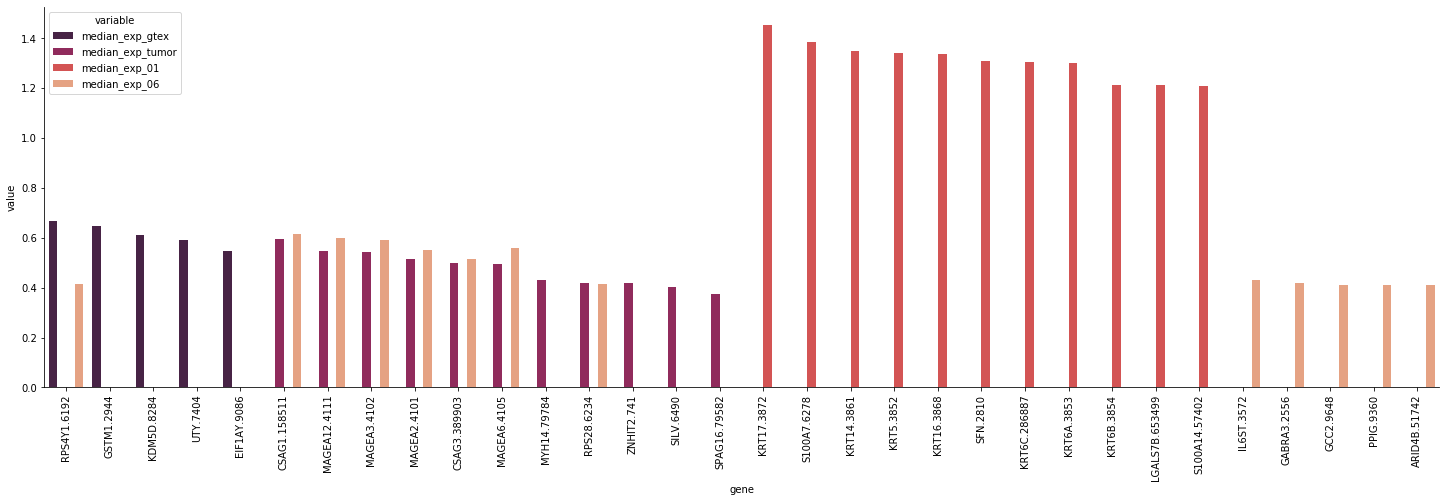

In [141]:
print("Compare Highly Expressed Genes for: gtex data, tumor data, only primary tumor data (01), only metastases (06)\n")
print("A gene is considered highly expressed if the median of its samples is in the 99.9th percentile of values in that dataset")
display(highly_expressed_comparison)


# create a categorical graph of the results
print("\nDisplay a categorical graph of these results:")
fig, ax1 = plt.subplots(figsize=(25, 7))
tidy = pd.melt(highly_expressed_comparison, id_vars=['gene'])
sns.barplot(x='gene', y='value', hue='variable', data=tidy, ax=ax1, palette="rocket")
sns.despine(fig)
plt.xticks( rotation=90)
plt.show()


Research Questions and Analysis Methodology:

<u>Question # 5</u>

**Question: There are miRNAs for which we know what genes expressions they affect. Are miRNAs that act differently between primary tumors and metastases known to be responsible for genes expressed differently between primary tumors and metastases? To answer this question, we should use external DBs that map known relationships between miRNA and genes, such as http://www.mirdb.org/faq.html**<br />

**Analysis Description:**<br />
1. Perform differential expression analysis for non-normalized micro rna data, and return highly and slightly expressed gene lists (using functions defined in Q4)<br />
2. Display results from highly/slightly_expressed_genes_06_vs_01 found in Q4, vs results for micro_rna
3. Check http://www.mirdb.org/faq.html to determine:
   - if highly expressed genes are known to be related to highly expressed mRNA<br />
   - if slightly expressed genes are known to be related to slightly expressed mRNA<br />
4. Section 3 should be done by searching for relevant gene symbol, and then relevant gene NCBI ids in the db. One of these is not enough because in some cases there is a mis-match in the TCGA gene id format (see conclusion)
   
**Conclusion**<br />
- We found very few relevant relationships:<br />
   - The only known relationship found between highly expressed genes and highly expressed mRNA was between <u>CSN2</u> and hsa-miR-153-5p (while hsa-miR-153-2 was in our list). We found an additional relationship between a highly-expressed gene and a slightly-expressed miRNA: <u>SCGB1A1</u> and hsa-miR-203a-5p (while hsa-miR-203 was a slightly-expressed miRNA in our list).
   - the only known relationship found between slightly expressed genes and slightly expressed mRNA was between <u>S100A7A</u> and hsa-miR-203a-3p (while hsa-miR-203 was in our list)
- We can point to several possible explanations:<br />
    - We defined "highly/slightly" expressed genes/miRNA using arbitrary choices for pvalues/logfoldchanges that we selected based on MA plots and in order not to get **many** results, in our opinion. Changing these arbitrary limits would have resulted in far more highly/slightly expressed results, and thus might have increased the number of relationships we would have found
    - Not all genes in our results were found mapped in mirdb. This could be because they have no known mapping, and could also be a result of a mix-up in gene id formatting. While most gene names in the TCGA dataset are formatted by placing "gene name/symbol"."NCBI gene id", we have found several genes that seem to have different formats. Many genes we searched for were missing, and maybe this has to do with name formatting
    - We both don't know biology, so had a difficulty in understanding how miRNA/genes we found with similar names to miRNA/genes in our list are actually similar...

Graphing relationship between dataframe mean and std (after log2):

Full dataframe:


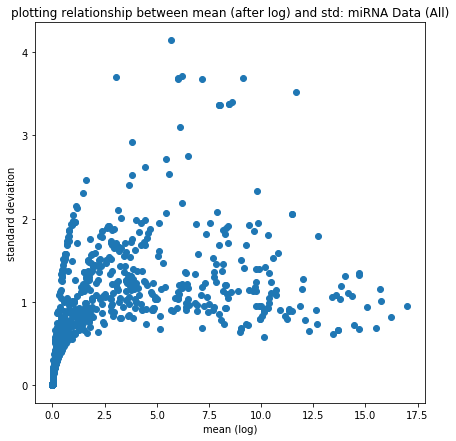

Partial dataframe: primary tumor samples only:


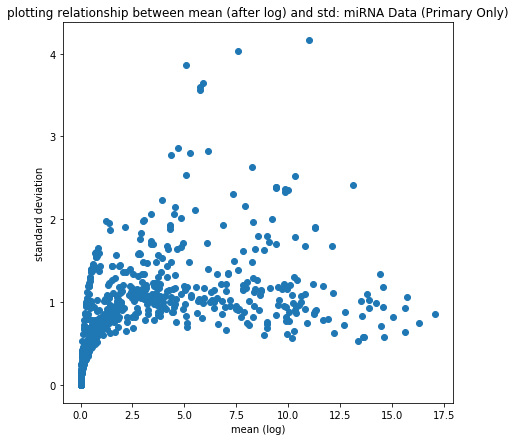

Partial dataframe: metastases samples only:


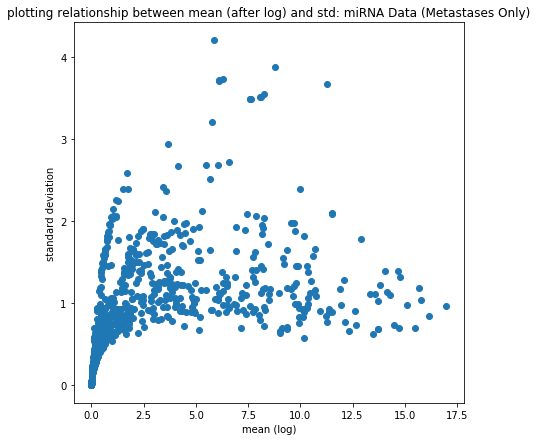

Transforming to str index.


In [80]:
# Find miRNA that act differently between primary and metastases using differential expression analysis

# prep miRNA data for differential expression analysis and graph log mean vs std
titles = ['miRNA Data (All)', 'miRNA Data (Primary Only)', 'miRNA Data (Metastases Only)']
data_mirna = create_data_to_find_highly_and_slightly_expressed('micro_rna_data', titles, 'micro_rna')



Performing differential expression tests and displaying sample results

Running Welch's T-Test:

      micro_rna      pval      qval    log2fc          mean
0  hsa.let.7a.1  0.118978  0.278440  0.109411  14538.403112
1  hsa.let.7a.2  0.111759  0.267094  0.111718  29093.350797
2  hsa.let.7a.3  0.109149  0.263656  0.112170  14673.002034
3    hsa.let.7b  0.761522  0.847076 -0.036394  23444.652835
4    hsa.let.7c  0.741816  0.830281  0.053271   2011.808051

Running Rank-Sum Test:

      micro_rna      pval      qval    log2fc          mean
0  hsa.let.7a.1  0.144183  0.309307  0.109411  14538.403112
1  hsa.let.7a.2  0.131300  0.292825  0.111718  29093.350797
2  hsa.let.7a.3  0.124226  0.284803  0.112170  14673.002034
3    hsa.let.7b  0.885810  0.947501 -0.036394  23444.652835
4    hsa.let.7c  0.979906  0.991617  0.053271   2011.808051

Printing MA plot: shows log2-fold changes vs mean expression


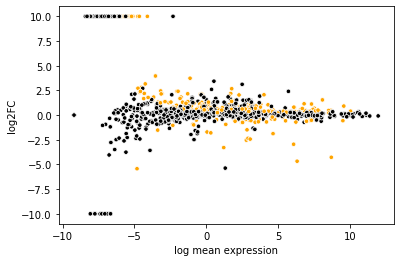


Graphing volcano plot: shows log fold change vs p-value

T-Test volcano plot:



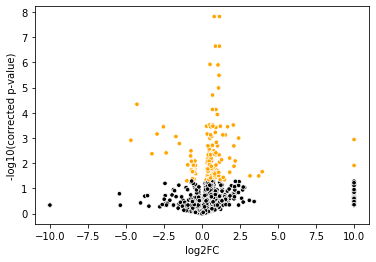

Rank-Sum test volcano plot:



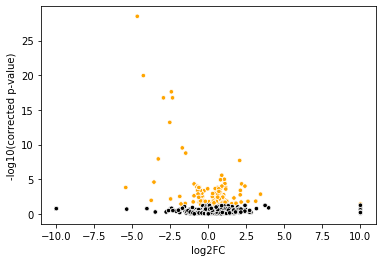

Graphing log10_pval for t-test (x axis) vs log10_pval for rank sum test (y axis)


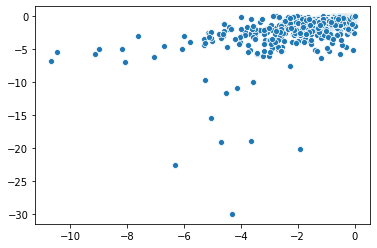


Determining which genes are highly/slightly expressed using:
p-value: 0.01 or lower
log2FoldChange: 2 or greater for highly expressed, -2 or lower for slightly expressed

T-Test Results:

Highly Expressed Genes:



micro_rna      pval      qval       log2fc       mean  zero_mean  \
64    hsa.mir.124.3  0.009151  0.053892     2.443460   0.041580      False   
83     hsa.mir.1257  0.000038  0.001007     2.410638   0.129509      False   
117    hsa.mir.1280  0.001133  0.012304  1067.467283   0.008467      False   
129  hsa.mir.1289.2  0.008607  0.051696  1066.615624   0.004692      False   
170  hsa.mir.135a.1  0.000097  0.002057     2.096425   0.759299      False   
199   hsa.mir.153.2  0.000623  0.008133     2.185707   5.495517      False   
286    hsa.mir.216a  0.001249  0.013150     2.105626   0.661359      False   
411    hsa.mir.3171  0.004535  0.031676     3.159331   0.014278      False   
610    hsa.mir.3938  0.002666  0.021716     3.960505   0.029028      False   
623    hsa.mir.422a  0.008833  0.052578     2.193890   0.013277      False   
806  hsa.mir.526a.2  0.004610  0.031953     3.731046   0.322654      False   
974    hsa.mir.663b  0.000046  0.001154  1068.428392   0.016484      False   
980     hsa.mir.675  0.000006  0.000305     2.061655  55.543367      False   

     zero_variance  
64           False  
83           False  
117          False  
129          False  
170          False  
199          False  
286          False  
411          False  
610          False  
623          False  
806          False  
974          False  
980          False


Slightly Expressed Genes:



micro_rna          pval      qval    log2fc         mean  zero_mean  \
179    hsa.mir.141  9.035478e-06  0.000359 -2.535512    16.246604      False   
259   hsa.mir.200a  2.311328e-04  0.003892 -2.355502    18.232538      False   
261   hsa.mir.200c  2.074795e-05  0.000693 -2.952355   437.229562      False   
263    hsa.mir.203  5.078427e-07  0.000046 -4.275540  6025.274616      False   
265    hsa.mir.205  5.050461e-05  0.001230 -4.675066   557.558594      False   
1040   hsa.mir.944  2.621721e-04  0.004218 -3.290994     3.373917      False   

      zero_variance  
179           False  
259           False  
261           False  
263           False  
265           False  
1040          False


Rank-Sum Results:

Highly Expressed Genes:



micro_rna          pval          qval       log2fc        mean  \
49     hsa.mir.1224  9.077050e-05  1.434811e-03     3.430393    1.700144   
170  hsa.mir.135a.1  1.204751e-04  1.796803e-03     2.096425    0.759299   
199   hsa.mir.153.2  8.407524e-07  4.734487e-05     2.185707    5.495517   
269     hsa.mir.206  2.111828e-06  9.938924e-05     2.405657  304.417549   
286    hsa.mir.216a  1.837312e-05  4.037606e-04     2.105626    0.661359   
541    hsa.mir.3681  2.070676e-03  1.568903e-02     2.606447    1.441500   
594    hsa.mir.3919  7.030268e-03  3.910044e-02  1071.008290    0.098560   
827  hsa.mir.548f.1  2.963844e-03  1.963546e-02     2.158741    0.273779   
908     hsa.mir.599  1.837630e-03  1.491626e-02     3.114542   12.133555   
980     hsa.mir.675  2.188296e-10  1.971655e-08     2.061655   55.543367   

     zero_mean  zero_variance  
49       False          False  
170      False          False  
199      False          False  
269      False          False  
286      False          False  
541      False          False  
594      False          False  
827      False          False  
908      False          False  
980      False          False


Slightly Expressed Genes:



micro_rna          pval          qval    log2fc         mean  \
179    hsa.mir.141  4.191853e-16  6.294766e-14 -2.535512    16.246604   
259   hsa.mir.200a  1.000039e-19  1.802070e-17 -2.355502    18.232538   
260   hsa.mir.200b  8.023411e-21  2.409698e-18 -2.432090    21.269000   
261   hsa.mir.200c  8.098377e-20  1.802070e-17 -2.952355   437.229562   
263    hsa.mir.203  2.464239e-23  1.110140e-20 -4.275540  6025.274616   
265    hsa.mir.205  3.428482e-32  3.089063e-29 -4.675066   557.558594   
546   hsa.mir.3686  1.269930e-03  1.132879e-02 -3.758733     0.003716   
603   hsa.mir.3927  5.006978e-06  1.571322e-04 -5.429765     0.008037   
1011   hsa.mir.890  4.057130e-07  2.611053e-05 -3.576407     0.019834   
1015  hsa.mir.892b  7.078926e-04  7.086791e-03 -2.483182     0.425327   
1040   hsa.mir.944  1.189089e-10  1.190410e-08 -3.290994     3.373917   

      zero_mean  zero_variance  
179       False          False  
259       False          False  
260       False          False  
261       False          False  
263       False          False  
265       False          False  
546       False          False  
603       False          False  
1011      False          False  
1015      False          False  
1040      False          False


Overall highly expresed:


micro_rna    pval_x     log2fc_x     mean_x        pval_y  \
0    hsa.mir.124.3  0.009151     2.443460   0.041580           NaN   
1     hsa.mir.1257  0.000038     2.410638   0.129509           NaN   
2     hsa.mir.1280  0.001133  1067.467283   0.008467           NaN   
3   hsa.mir.1289.2  0.008607  1066.615624   0.004692           NaN   
4   hsa.mir.135a.1  0.000097     2.096425   0.759299  1.204751e-04   
5    hsa.mir.153.2  0.000623     2.185707   5.495517  8.407524e-07   
6     hsa.mir.216a  0.001249     2.105626   0.661359  1.837312e-05   
7     hsa.mir.3171  0.004535     3.159331   0.014278           NaN   
8     hsa.mir.3938  0.002666     3.960505   0.029028           NaN   
9     hsa.mir.422a  0.008833     2.193890   0.013277           NaN   
10  hsa.mir.526a.2  0.004610     3.731046   0.322654           NaN   
11    hsa.mir.663b  0.000046  1068.428392   0.016484           NaN   
12     hsa.mir.675  0.000006     2.061655  55.543367  2.188296e-10   
13    hsa.mir.1224       NaN          NaN        NaN  9.077050e-05   
14     hsa.mir.206       NaN          NaN        NaN  2.111828e-06   
15    hsa.mir.3681       NaN          NaN        NaN  2.070676e-03   
16    hsa.mir.3919       NaN          NaN        NaN  7.030268e-03   
17  hsa.mir.548f.1       NaN          NaN        NaN  2.963844e-03   
18     hsa.mir.599       NaN          NaN        NaN  1.837630e-03   

       log2fc_y      mean_y  
0           NaN         NaN  
1           NaN         NaN  
2           NaN         NaN  
3           NaN         NaN  
4      2.096425    0.759299  
5      2.185707    5.495517  
6      2.105626    0.661359  
7           NaN         NaN  
8           NaN         NaN  
9           NaN         NaN  
10          NaN         NaN  
11          NaN         NaN  
12     2.061655   55.543367  
13     3.430393    1.700144  
14     2.405657  304.417549  
15     2.606447    1.441500  
16  1071.008290    0.098560  
17     2.158741    0.273779  
18     3.114542   12.133555


Overall slightly expresed:


micro_rna        pval_x  log2fc_x       mean_x        pval_y  log2fc_y  \
0    hsa.mir.141  9.035478e-06 -2.535512    16.246604  4.191853e-16 -2.535512   
1   hsa.mir.200a  2.311328e-04 -2.355502    18.232538  1.000039e-19 -2.355502   
2   hsa.mir.200c  2.074795e-05 -2.952355   437.229562  8.098377e-20 -2.952355   
3    hsa.mir.203  5.078427e-07 -4.275540  6025.274616  2.464239e-23 -4.275540   
4    hsa.mir.205  5.050461e-05 -4.675066   557.558594  3.428482e-32 -4.675066   
5    hsa.mir.944  2.621721e-04 -3.290994     3.373917  1.189089e-10 -3.290994   
6   hsa.mir.200b           NaN       NaN          NaN  8.023411e-21 -2.432090   
7   hsa.mir.3686           NaN       NaN          NaN  1.269930e-03 -3.758733   
8   hsa.mir.3927           NaN       NaN          NaN  5.006978e-06 -5.429765   
9    hsa.mir.890           NaN       NaN          NaN  4.057130e-07 -3.576407   
10  hsa.mir.892b           NaN       NaN          NaN  7.078926e-04 -2.483182   

         mean_y  
0     16.246604  
1     18.232538  
2    437.229562  
3   6025.274616  
4    557.558594  
5      3.373917  
6     21.269000  
7      0.003716  
8      0.008037  
9      0.019834  
10     0.425327

In [81]:
# perform differential expression analysis and find hgihly/slightly expressed mirna

highly_expressed_mirna_06_vs_01, slightly_expressed_mirna_06_vs_01 = differential_expression_analysis(data_mirna, 
                                                                                                      'micro_rna', 
                                                                                                      -2, 
                                                                                                      2)


In [82]:
# we need to change micro rna names to a format which matches the format hsa-miR-124-3p (used in http://www.mirdb.org)

highly_expressed_mirna_06_vs_01['micro_rna'] = pd.Series(highly_expressed_mirna_06_vs_01['micro_rna']).str.replace('.', '-', regex=True).str.replace('mir', 'miR', regex=True)
slightly_expressed_mirna_06_vs_01['micro_rna'] = pd.Series(slightly_expressed_mirna_06_vs_01['micro_rna']).str.replace('.', '-', regex=True).str.replace('mir', 'miR', regex=True)



In [83]:
# after finding genes and miRNA that act differently between primary and metastases samples, display highly expressed

print("Highly Expressed Genes Metastases vs Primary (Q4 Result)")
display(highly_expressed_genes_06_vs_01)

print("\nHighly Expressed miRNA Metastases vs Primary")
display(highly_expressed_mirna_06_vs_01)


Highly Expressed Genes Metastases vs Primary (Q4 Result)


gene    pval_x     log2fc_x    mean_x    pval_y  \
0       FAM138B.654412  0.000246  1069.610675  0.037283  0.009415   
1             GIP.2695  0.009081  1069.524744  0.035127       NaN   
2     LOC154449.154449  0.004802  1068.655280  0.019227       NaN   
3     LOC285375.285375  0.003603  1067.974434  0.011994       NaN   
4     LOC730811.730811  0.002410  1067.552621  0.008953       NaN   
5        OR11G2.390439  0.008949  1066.841179  0.005468       NaN   
6        OR2A12.346525  0.001657  1067.636551  0.009489       NaN   
7         PLGLA.285189  0.004218  1067.510231  0.008694       NaN   
8   SNORA38B.100124536  0.002061  1068.005334  0.012253       NaN   
9         TAS2R7.50837  0.003309  1068.183079  0.013860       NaN   
10           TSHB.7252  0.007413  1067.549333  0.008933       NaN   
11     C20orf70.140683       NaN          NaN       NaN  0.004872   
12           CSN2.1447       NaN          NaN       NaN  0.001305   
13        SCGB1A1.7356       NaN          NaN       NaN  0.000276   
14          STATH.6779       NaN          NaN       NaN  0.005379   

       log2fc_y       mean_y  
0   1069.610675     0.037283  
1           NaN          NaN  
2           NaN          NaN  
3           NaN          NaN  
4           NaN          NaN  
5           NaN          NaN  
6           NaN          NaN  
7           NaN          NaN  
8           NaN          NaN  
9           NaN          NaN  
10          NaN          NaN  
11     7.671862    59.939656  
12    10.984137     5.933407  
13    11.141320    57.647970  
14     8.890804  1297.589287


Highly Expressed miRNA Metastases vs Primary


micro_rna    pval_x     log2fc_x     mean_x        pval_y  \
0    hsa-miR-124-3  0.009151     2.443460   0.041580           NaN   
1     hsa-miR-1257  0.000038     2.410638   0.129509           NaN   
2     hsa-miR-1280  0.001133  1067.467283   0.008467           NaN   
3   hsa-miR-1289-2  0.008607  1066.615624   0.004692           NaN   
4   hsa-miR-135a-1  0.000097     2.096425   0.759299  1.204751e-04   
5    hsa-miR-153-2  0.000623     2.185707   5.495517  8.407524e-07   
6     hsa-miR-216a  0.001249     2.105626   0.661359  1.837312e-05   
7     hsa-miR-3171  0.004535     3.159331   0.014278           NaN   
8     hsa-miR-3938  0.002666     3.960505   0.029028           NaN   
9     hsa-miR-422a  0.008833     2.193890   0.013277           NaN   
10  hsa-miR-526a-2  0.004610     3.731046   0.322654           NaN   
11    hsa-miR-663b  0.000046  1068.428392   0.016484           NaN   
12     hsa-miR-675  0.000006     2.061655  55.543367  2.188296e-10   
13    hsa-miR-1224       NaN          NaN        NaN  9.077050e-05   
14     hsa-miR-206       NaN          NaN        NaN  2.111828e-06   
15    hsa-miR-3681       NaN          NaN        NaN  2.070676e-03   
16    hsa-miR-3919       NaN          NaN        NaN  7.030268e-03   
17  hsa-miR-548f-1       NaN          NaN        NaN  2.963844e-03   
18     hsa-miR-599       NaN          NaN        NaN  1.837630e-03   

       log2fc_y      mean_y  
0           NaN         NaN  
1           NaN         NaN  
2           NaN         NaN  
3           NaN         NaN  
4      2.096425    0.759299  
5      2.185707    5.495517  
6      2.105626    0.661359  
7           NaN         NaN  
8           NaN         NaN  
9           NaN         NaN  
10          NaN         NaN  
11          NaN         NaN  
12     2.061655   55.543367  
13     3.430393    1.700144  
14     2.405657  304.417549  
15     2.606447    1.441500  
16  1071.008290    0.098560  
17     2.158741    0.273779  
18     3.114542   12.133555

We used the website http://www.mirdb.org/faq.html to examine the relationship between the resulting miRNA and the resulting genes

**Highly expressed results:**
- by gene symbol found in mirdb:
    - CSN2 (casein beta) - a relationshp with hsa-miR-153-5p has been found with a target rank of 19 and a target score of 81 (while hsa-miR-153-2 is in our list and seems similar though not exactly identical)
    - SCGB1A1 (secretoglobin family 1A member 1) - a relationship with hsa-miR-203a-5p has been found with a target rank of 6 and a target score of 56 (while hsa-miR-203 is a **slightly-expressed** mRNA in our next list)
    - GIP - no relationship in found between our 2 lists
    - STATH - no relationship in found between our 2 lists
- by ncdbi ids found in mirdb (cases where the relevant gene symbol was not found)
    - 140683 -> no relationship in found between our 2 lists
    
    
* we are adding a disclaimer here that we both don't actually know biology so we don't know how similar/different these almost-matches actually are...

In [101]:
# after finding genes and miRNA that act differently between primary and metastases samples, display slightly expressed

print("Slightly Expressed Genes Metastases vs Primary (Q4 Result)")
display(slightly_expressed_genes_06_vs_01)

print("\nSlightly Expressed miRNA Metastases vs Primary (Q4 Result)")
display(slightly_expressed_mirna_06_vs_01)

Slightly Expressed Genes Metastases vs Primary (Q4 Result)


gene    pval_x  log2fc_x       mean_x        pval_y  \
0       DEFB4A.1673  0.007138 -9.288885    29.219999  5.166131e-28   
1      KRT6C.286887  0.008132 -7.534058  6895.910799  1.366750e-22   
2      LCE3E.353145  0.008471 -8.277418    76.602001  4.946981e-28   
3    S100A7A.338324  0.000986 -8.116672   310.107806  8.537951e-30   
4       SPRR2G.6706  0.005677 -8.887956   444.402500  4.605457e-21   
5     WFDC12.128488  0.004220 -8.834378    62.517250  4.176581e-31   
6   DEFB108B.245911       NaN       NaN          NaN  1.045823e-03   
7         KRT9.3857       NaN       NaN          NaN  1.957202e-14   
8      LCE3B.353143       NaN       NaN          NaN  7.532479e-03   
9      LCE3C.353144       NaN       NaN          NaN  3.264622e-09   
10      OR4P4.81300       NaN       NaN          NaN  7.532479e-03   
11     OR5L1.219437       NaN       NaN          NaN  7.532479e-03   
12   SCGB1D4.404552       NaN       NaN          NaN  7.532479e-03   
13   SPAG11A.653423       NaN       NaN          NaN  1.045823e-03   

       log2fc_y       mean_y  
0     -9.288885    29.219999  
1     -7.534058  6895.910799  
2     -8.277418    76.602001  
3     -8.116672   310.107806  
4     -8.887956   444.402500  
5     -8.834378    62.517250  
6  -1067.996702     0.003409  
7    -10.870980   282.939480  
8  -1068.863119     0.006215  
9     -7.575577     2.002315  
10 -1068.002888     0.003424  
11 -1067.005570     0.001715  
12 -1069.215766     0.007936  
13 -1067.747207     0.002868


Slightly Expressed miRNA Metastases vs Primary (Q4 Result)


micro_rna        pval_x  log2fc_x       mean_x        pval_y  log2fc_y  \
0    hsa-miR-141  9.035478e-06 -2.535512    16.246604  4.191853e-16 -2.535512   
1   hsa-miR-200a  2.311328e-04 -2.355502    18.232538  1.000039e-19 -2.355502   
2   hsa-miR-200c  2.074795e-05 -2.952355   437.229562  8.098377e-20 -2.952355   
3    hsa-miR-203  5.078427e-07 -4.275540  6025.274616  2.464239e-23 -4.275540   
4    hsa-miR-205  5.050461e-05 -4.675066   557.558594  3.428482e-32 -4.675066   
5    hsa-miR-944  2.621721e-04 -3.290994     3.373917  1.189089e-10 -3.290994   
6   hsa-miR-200b           NaN       NaN          NaN  8.023411e-21 -2.432090   
7   hsa-miR-3686           NaN       NaN          NaN  1.269930e-03 -3.758733   
8   hsa-miR-3927           NaN       NaN          NaN  5.006978e-06 -5.429765   
9    hsa-miR-890           NaN       NaN          NaN  4.057130e-07 -3.576407   
10  hsa-miR-892b           NaN       NaN          NaN  7.078926e-04 -2.483182   

         mean_y  
0     16.246604  
1     18.232538  
2    437.229562  
3   6025.274616  
4    557.558594  
5      3.373917  
6     21.269000  
7      0.003716  
8      0.008037  
9      0.019834  
10     0.425327

We used the website http://www.mirdb.org/faq.html to examine the relationship between the resulting miRNA and the resulting genes

**Slightly expressed results:**
- by gene symbol found in mirdb:
    - S100A7A (S100 calcium binding protein A7A) - a relationshp with hsa-miR-203a-3p has been found with a target rank of 139 and a target score of 51 (while hsa-miR-203 is in our list )
    - DEFB4A - no relevant relationship in found 
    - KRT6C - no relevant relationship in found 
    - LCE3E - no relevant relationship in found
    - S100A7A - no relevant relationship in found
    - WFDC12 - no relevant relationship in found
    - KRT9 - no relevant relationship in found
    - SCGB1D4 - no relevant relationship in found
    - SPAG11A - no relevant relationship in found
    
    
    
    
* we are adding a disclaimer here that we both don't actually know biology so we don't know how similar/different these almost-matches actually are... 
* we found some additional similarities, for example micro rna in our list that end in numbers that are part of a micro rna where we found a relationship (eg: hsa-miR-2052 vs hsa-miR-205) but decided to ignore these cases

Research Questions and Analysis Methodology:

<u>Question # 6</u>

**Question: Among the genes and miRNA that are highly expressed in metastases vs primary tumors, are there genes/miRNA that affect the prognosis of the patient?**

**Analysis Description:**<br />
1. We performed differential expression analysis for genes and micro rna using the patient's prognosis as a condition (instead of the sample type we used previously).
2. To do this, we used the isDead column of dataframes['survival_data']: if died, 1, else 0. 
    - to do this we edited a version of the create_data_to_find_highly_and_slightly_expressed to create a relevant AnnData object slightly differently from the previous questions
    - we realize this is a slightly problematic way to look at our data, because it doesn't take into account the number of days the patient was actually a part of the study before dying, however it is the best idea we came up with to tackle this question
3. We compared the resulting highly/slightly expressed genes and miRNA lists to results found for metastases vs primary tumors.


**Conclusion**<br />
- We found two miRNAs that were highly expressed for the metastases vs primary analysis and also highly/slightly expressed for the analysis by prognosis:
    - mRNA hsa.mir.1289.2
    - mRNA hsa.mir.3919
- We found no genes that were highly expressed for the metastases vs primary analysis and also highly/slightly expressed for the analysis by prognosis



In [85]:
# edit survival_data df

# change 'survival_data' PatientID values from being separated by dashes to being separated by periods
dataframes['survival_data']['PatientID'] = pd.Series(dataframes['survival_data']['PatientID']).str.replace('-', 
                                                                                                           '.', 
                                                                                                           regex=True)

# some values of isDead are NaN so we will remove these rows as they are irrelevant to our prognosis analysis
dataframes['survival_data'] = dataframes['survival_data'][dataframes['survival_data']['isDead'].notnull()]


In [86]:

# axis_name should either be 'gene' or 'miRNA', depending on the dataframe
"""
Prep data for determining highly and slightly expressed genes/miRNA in a given non-normalized dataframe
This is an edited version of create_data_to_find_highly_and_slightly_expressed, specifically for the prognosis
As part of this process:
1. Transpose full datafrane to get a matrix where samples are rows, dimensions (genes/miRNA) for columns
2. Merge dataframe with IsDead column of 'survival_data' in order to know sample prognosis (which samples died)
3. Create a sample types dataset, where the condition is defined as: if died: 1, otherwise 0
5. Create an AnnData object that will hold our data matrix (X), sample descriptions, and and labels - and return it
"""

def create_data_to_find_highly_and_slightly_expressed_prognisis(dataframe_name, axis_name):
    
    """
    transpose data to get a matrix of samples for rows, dimensions (genes) for columns (same function as Q1)
    """
    
    def transform_data(dataframe):
        a = dataframe.T
        a.columns = a.iloc[0]
        a = a.iloc[1:, :]
        a['PatientID'] = a.index
        a = pd.merge(a, dataframes['survival_data'][['PatientID', 'isDead']], on='PatientID', how='inner')
        b = a.drop(['PatientID', 'isDead'], axis=1)
        Y = b.to_numpy()  # convert a to numpy array (no row, column names) because algos we will use need this
        cols = list(b.columns) # we change them soon
        return a, Y, cols

    
    """
    per sample, create a dataset that describes the sample types
    
    ** condition definition ** : 1 for metastases, 0 for primary (because of the semantics of the question)

    example:

    if this is our original dataframe:
            sample1_01  sample2_01  sample3_06 
    gene_a       x           y          z
    gene_b       a           b          c
    ...
    gene_n       f           g          h


    this is our dataframe after tansposing and adding an IsDead column
                gene_a    gene_b    ...    gene_n    isDead   
    sample1_01    x          a                f         1
    sample2_01    y          b                g         0
    sample3_06    z          c                h         1

    
    then this is our sample types dataset:
    # if 1 means died and 0 means did not die --> alive:
    # the batch is needed because the data is accepted in this format
            condition   batch
    sample1     1         0
    sample2     0         0
    sample3     1         0

    """
    
    
    def create_sample_description_dataset(dataframe):
        sample_descriptions = pd.DataFrame([int(x) for x in list(dataframe.isDead)])
        sample_descriptions['batch'] = 0
        sample_descriptions.columns = ['condition', 'batch']
        return sample_descriptions

    
    a, Y, cols = transform_data(not_normalized_dataframes[dataframe_name])
    sample_descriptions = create_sample_description_dataset(a)

    
    """
    create an AnnData object that will hold our data matrix (X), sample descriptions, and and labels
    """
    
    data_obj = anndata.AnnData(
        X=Y,
        var=pd.DataFrame(index=cols), #labels: samples
        obs=sample_descriptions
    )

    return data_obj


Check Genes

Transforming to str index.


Performing differential expression tests and displaying sample results

Running Welch's T-Test:

           gene      pval      qval    log2fc        mean
0        A1BG.1  0.184173  0.539615 -0.144603  292.704945
1    A1CF.29974  0.511187  0.772203 -0.510109    0.177897
2   A2BP1.54715  0.541277  0.789189 -1.222461    4.804768
3   A2LD1.87769  0.401892  0.704143  0.072195  101.137009
4  A2ML1.144568  0.283043  0.626779  0.696147  257.983928

Running Rank-Sum Test:

           gene      pval      qval    log2fc        mean
0        A1BG.1  0.099124  0.328200 -0.144603  292.704945
1    A1CF.29974  0.200218  0.471620 -0.510109    0.177897
2   A2BP1.54715  0.706858  0.868533 -1.222461    4.804768
3   A2LD1.87769  0.633404  0.830543  0.072195  101.137009
4  A2ML1.144568  0.396567  0.669332  0.696147  257.983928

Printing MA plot: shows log2-fold changes vs mean expression


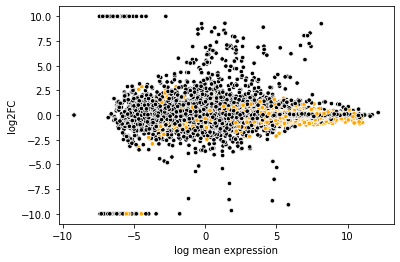


Graphing volcano plot: shows log fold change vs p-value

T-Test volcano plot:



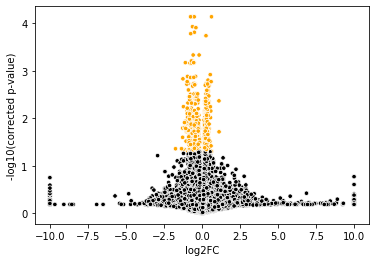

Rank-Sum test volcano plot:



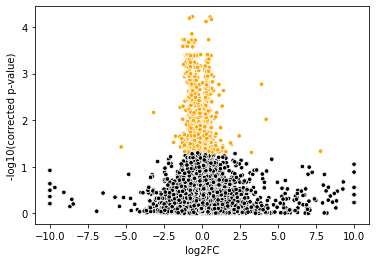

Graphing log10_pval for t-test (x axis) vs log10_pval for rank sum test (y axis)


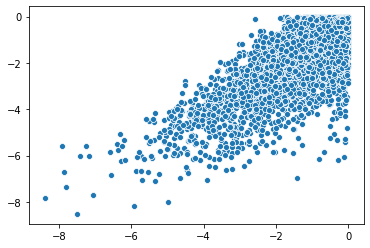


Determining which genes are highly/slightly expressed using:
p-value: 0.01 or lower
log2FoldChange: 2 or greater for highly expressed, -2 or lower for slightly expressed

T-Test Results:

Highly Expressed Genes:



gene      pval      qval    log2fc      mean  zero_mean  \
12097  OVCH2.341277  0.007653  0.117966  2.236408  0.061414      False   

       zero_variance  
12097          False


Slightly Expressed Genes:



gene      pval      qval    log2fc      mean  zero_mean  \
11673   OR10J1.26476  0.009500  0.132049 -2.433797  0.021255      False   
11831  OR4F21.441308  0.002191  0.060959 -2.916985  0.024487      False   

       zero_variance  
11673          False  
11831          False


Rank-Sum Results:

Highly Expressed Genes:



gene      pval      qval    log2fc        mean  zero_mean  \
2726           CA6.765  0.000018  0.001690  3.919547  319.125282      False   
5743      FAM55D.54827  0.007866  0.072639  2.572601    1.702525      False   
7491          HRC.3270  0.001124  0.021735  2.444502   36.591979      False   
7533       HSD3B1.3283  0.004176  0.049364  3.250766    1.863908      False   
8736    KRTAP3.1.83896  0.003694  0.046156  7.792765   14.575783      False   
8753   KRTAP5.3.387266  0.007215  0.068823  4.587268    0.721128      False   
8762   KRTAP6.3.337968  0.004540  0.052055  2.174811    0.016862      False   
12097     OVCH2.341277  0.009568  0.082070  2.236408    0.061414      False   
13992         REN.5972  0.007921  0.072927  2.047071    5.685701      False   
16448      STMN4.81551  0.008842  0.078057  2.147869    1.547164      False   
16792       TCF21.6943  0.000302  0.009570  4.218628   27.458077      False   

       zero_variance  
2726           False  
5743           False  
7491           False  
7533           False  
8736           False  
8753           False  
8762           False  
12097          False  
13992          False  
16448          False  
16792          False


Slightly Expressed Genes:



gene      pval      qval    log2fc        mean  zero_mean  \
1469          BPI.671  0.007164  0.068438 -2.189676   15.064212      False   
4883      DPPA4.55211  0.009587  0.082193 -2.172874   20.239549      False   
5609   FAM166B.730112  0.000172  0.006837 -3.183102   10.287976      False   
7470         HPD.3242  0.005997  0.061021 -2.065209    2.963626      False   
11831   OR4F21.441308  0.008661  0.077100 -2.916985    0.024487      False   
16399       STAR.6770  0.002673  0.037389 -5.310448  151.961759      False   

       zero_variance  
1469           False  
4883           False  
5609           False  
7470           False  
11831          False  
16399          False


Overall highly expresed:


gene    pval_x  log2fc_x    mean_x    pval_y  log2fc_y  \
0      OVCH2.341277  0.007653  2.236408  0.061414  0.009568  2.236408   
1           CA6.765       NaN       NaN       NaN  0.000018  3.919547   
2      FAM55D.54827       NaN       NaN       NaN  0.007866  2.572601   
3          HRC.3270       NaN       NaN       NaN  0.001124  2.444502   
4       HSD3B1.3283       NaN       NaN       NaN  0.004176  3.250766   
5    KRTAP3.1.83896       NaN       NaN       NaN  0.003694  7.792765   
6   KRTAP5.3.387266       NaN       NaN       NaN  0.007215  4.587268   
7   KRTAP6.3.337968       NaN       NaN       NaN  0.004540  2.174811   
8          REN.5972       NaN       NaN       NaN  0.007921  2.047071   
9       STMN4.81551       NaN       NaN       NaN  0.008842  2.147869   
10       TCF21.6943       NaN       NaN       NaN  0.000302  4.218628   

        mean_y  
0     0.061414  
1   319.125282  
2     1.702525  
3    36.591979  
4     1.863908  
5    14.575783  
6     0.721128  
7     0.016862  
8     5.685701  
9     1.547164  
10   27.458077


Overall slightly expresed:


gene    pval_x  log2fc_x    mean_x    pval_y  log2fc_y  \
0    OR10J1.26476  0.009500 -2.433797  0.021255       NaN       NaN   
1   OR4F21.441308  0.002191 -2.916985  0.024487  0.008661 -2.916985   
2         BPI.671       NaN       NaN       NaN  0.007164 -2.189676   
3     DPPA4.55211       NaN       NaN       NaN  0.009587 -2.172874   
4  FAM166B.730112       NaN       NaN       NaN  0.000172 -3.183102   
5        HPD.3242       NaN       NaN       NaN  0.005997 -2.065209   
6       STAR.6770       NaN       NaN       NaN  0.002673 -5.310448   

       mean_y  
0         NaN  
1    0.024487  
2   15.064212  
3   20.239549  
4   10.287976  
5    2.963626  
6  151.961759

In [87]:
#perform differential expression analysis and find hgihly/slightly expressed genes

data_prognosis_genes = create_data_to_find_highly_and_slightly_expressed_prognisis('gene_data', 
                                                                                   'gene')


highly_expressed_genes_prog, slightly_expressed_genes_prog = differential_expression_analysis(data_prognosis_genes,
                                                                                              'gene', 
                                                                                              -2, 
                                                                                              2)


In [93]:
print("highly expressed genes: prognosis (dead vs not dead)")
display(highly_expressed_genes_prog)

print("\nslightly expressed genes: prognosis (dead vs not dead)")
display(slightly_expressed_genes_prog)

# check if these genes exist in highly_expressed_genes_06_vs_01 or slightly_expressed_genes_06_vs_01
highly_expressed_genes_06_vs_01_list = list(highly_expressed_genes_06_vs_01['gene'])
slightly_expressed_genes_06_vs_01_list = list(slightly_expressed_genes_06_vs_01['gene'])


print("Checking if prognosis highly expressed genes were found in a previous metastases vs primary analysis:")
c1 = 0
for x in list(highly_expressed_genes_prog['gene']):
    for y in highly_expressed_genes_06_vs_01_list:
        if x == y:
            c1 += 1
            print("gene {} (highly expressed prognosis) was a highly_expressed gene in metastases vs primary analysis".format(x))
    for y in slightly_expressed_genes_06_vs_01_list:
        if x == y:
            c1 += 1
            print("gene {} (highly expressed prognosis) was a slightly_expressed gene in metastases vs primary analysis".format(x))
if c1 == 0:
    print("None of these genes were found in metastases vs primary analysis\n")
    
            
print("Checking if prognosis slightly expressed genes were found in a previous metastases vs primary analysis:")
c2 = 0
for x in list(slightly_expressed_genes_prog['gene']):
    for y in highly_expressed_genes_06_vs_01_list:
        if x == y:
            c2 += 1
            print("gene {} (slightly expressed prognosis) was a highly_expressed gene in metastases vs primary analysis".format(x))
    for y in slightly_expressed_genes_06_vs_01_list:
        if x == y:
            c2 += 1            
            print("gene {} (slightly expressed prognosis) was a slightly_expressed gene in metastases vs primary analysis".format(x))
if c2 == 0:
    print("None of these genes were found in metastases vs primary analysis\n")

highly expressed genes: prognosis (dead vs not dead)


gene    pval_x  log2fc_x    mean_x    pval_y  log2fc_y  \
0      OVCH2.341277  0.007653  2.236408  0.061414  0.009568  2.236408   
1           CA6.765       NaN       NaN       NaN  0.000018  3.919547   
2      FAM55D.54827       NaN       NaN       NaN  0.007866  2.572601   
3          HRC.3270       NaN       NaN       NaN  0.001124  2.444502   
4       HSD3B1.3283       NaN       NaN       NaN  0.004176  3.250766   
5    KRTAP3.1.83896       NaN       NaN       NaN  0.003694  7.792765   
6   KRTAP5.3.387266       NaN       NaN       NaN  0.007215  4.587268   
7   KRTAP6.3.337968       NaN       NaN       NaN  0.004540  2.174811   
8          REN.5972       NaN       NaN       NaN  0.007921  2.047071   
9       STMN4.81551       NaN       NaN       NaN  0.008842  2.147869   
10       TCF21.6943       NaN       NaN       NaN  0.000302  4.218628   

        mean_y  
0     0.061414  
1   319.125282  
2     1.702525  
3    36.591979  
4     1.863908  
5    14.575783  
6     0.721128  
7     0.016862  
8     5.685701  
9     1.547164  
10   27.458077


slightly expressed genes: prognosis (dead vs not dead)


gene    pval_x  log2fc_x    mean_x    pval_y  log2fc_y  \
0    OR10J1.26476  0.009500 -2.433797  0.021255       NaN       NaN   
1   OR4F21.441308  0.002191 -2.916985  0.024487  0.008661 -2.916985   
2         BPI.671       NaN       NaN       NaN  0.007164 -2.189676   
3     DPPA4.55211       NaN       NaN       NaN  0.009587 -2.172874   
4  FAM166B.730112       NaN       NaN       NaN  0.000172 -3.183102   
5        HPD.3242       NaN       NaN       NaN  0.005997 -2.065209   
6       STAR.6770       NaN       NaN       NaN  0.002673 -5.310448   

       mean_y  
0         NaN  
1    0.024487  
2   15.064212  
3   20.239549  
4   10.287976  
5    2.963626  
6  151.961759

Checking if prognosis highly expressed genes were found in a previous metastases vs primary analysis:
None of these genes were found in metastases vs primary analysis

Checking if prognosis slightly expressed genes were found in a previous metastases vs primary analysis:
None of these genes were found in metastases vs primary analysis



Check miRNA

Transforming to str index.


Performing differential expression tests and displaying sample results

Running Welch's T-Test:

      micro_rna      pval      qval    log2fc          mean
0  hsa.let.7a.1  0.369869  0.698677 -0.055473  14536.472068
1  hsa.let.7a.2  0.383309  0.702495 -0.053978  29087.963533
2  hsa.let.7a.3  0.376440  0.702495 -0.054531  14671.609930
3    hsa.let.7b  0.772858  0.909765  0.028624  23291.392685
4    hsa.let.7c  0.012571  0.323280  0.341237   2033.068285

Running Rank-Sum Test:

      micro_rna      pval      qval    log2fc          mean
0  hsa.let.7a.1  0.242367  0.647990 -0.055473  14536.472068
1  hsa.let.7a.2  0.251928  0.659294 -0.053978  29087.963533
2  hsa.let.7a.3  0.253181  0.659294 -0.054531  14671.609930
3    hsa.let.7b  0.991564  0.999328  0.028624  23291.392685
4    hsa.let.7c  0.006131  0.145358  0.341237   2033.068285

Printing MA plot: shows log2-fold changes vs mean expression


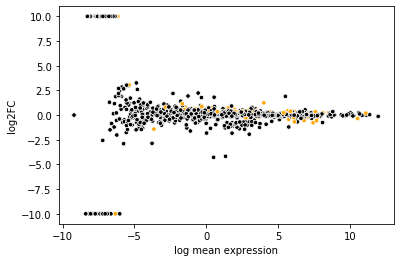


Graphing volcano plot: shows log fold change vs p-value

T-Test volcano plot:



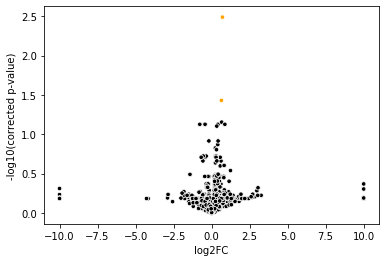

Rank-Sum test volcano plot:



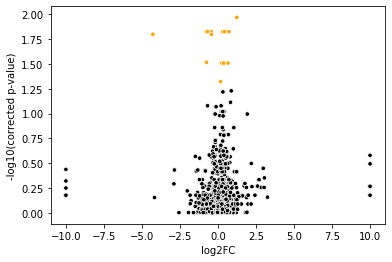

Graphing log10_pval for t-test (x axis) vs log10_pval for rank sum test (y axis)


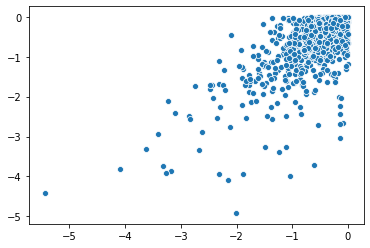


Determining which genes are highly/slightly expressed using:
p-value: 0.01 or lower
log2FoldChange: 2 or greater for highly expressed, -2 or lower for slightly expressed

T-Test Results:

Highly Expressed Genes:



micro_rna      pval      qval       log2fc      mean  zero_mean  \
66   hsa.mir.1244.1  0.032705  0.427174  1066.157512  0.002119      False   
129  hsa.mir.1289.2  0.045559  0.477313     3.051515  0.004653      False   
218    hsa.mir.1827  0.049483  0.495381  1065.956914  0.001844      False   

     zero_variance  
66           False  
129          False  
218          False


Slightly Expressed Genes:



micro_rna      pval      qval       log2fc      mean  zero_mean  \
657  hsa.mir.4281  0.048205  0.488008 -1065.829837  0.001783      False   

     zero_variance  
657          False


Rank-Sum Results:

Highly Expressed Genes:



micro_rna      pval      qval       log2fc      mean  zero_mean  \
66   hsa.mir.1244.1  0.021073  0.263699  1066.157512  0.002119      False   
95     hsa.mir.1265  0.047893  0.356162     2.977407  0.004521      False   
218    hsa.mir.1827  0.039366  0.321362  1065.956914  0.001844      False   
594    hsa.mir.3919  0.037091  0.318461     2.190893  0.098352      False   

     zero_variance  
66           False  
95           False  
218          False  
594          False


Slightly Expressed Genes:



micro_rna      pval      qval    log2fc      mean  zero_mean  \
262  hsa.mir.202  0.000194  0.015927 -4.280842  1.668276      False   

     zero_variance  
262          False


Overall highly expresed:


micro_rna    pval_x     log2fc_x    mean_x    pval_y     log2fc_y  \
0  hsa.mir.1244.1  0.032705  1066.157512  0.002119  0.021073  1066.157512   
1  hsa.mir.1289.2  0.045559     3.051515  0.004653       NaN          NaN   
2    hsa.mir.1827  0.049483  1065.956914  0.001844  0.039366  1065.956914   
3    hsa.mir.1265       NaN          NaN       NaN  0.047893     2.977407   
4    hsa.mir.3919       NaN          NaN       NaN  0.037091     2.190893   

     mean_y  
0  0.002119  
1       NaN  
2  0.001844  
3  0.004521  
4  0.098352


Overall slightly expresed:


micro_rna    pval_x     log2fc_x    mean_x    pval_y  log2fc_y    mean_y
0  hsa.mir.4281  0.048205 -1065.829837  0.001783       NaN       NaN       NaN
1   hsa.mir.202       NaN          NaN       NaN  0.000194 -4.280842  1.668276

In [89]:
#perform differential expression analysis and find hgihly/slightly expressed miRNA

data_prognosis_mirna = create_data_to_find_highly_and_slightly_expressed_prognisis('micro_rna_data', 'micro_rna')

highly_expressed_mirna_prog, slightly_expressed_mirna_prog = differential_expression_analysis(data_prognosis_mirna,
                                                                                            'micro_rna', 
                                                                                              -2, 
                                                                                              2, 
                                                                                              0.05)


In [148]:
print("highly expressed miRNA: prognosis (dead vs not dead)")
display(highly_expressed_mirna_prog)

print("\nslightly expressed miRNA: prognosis (dead vs not dead)")
display(slightly_expressed_mirna_prog)

# check if these mRNA exist in highly_expressed_mirna_06_vs_01 or slightly_expressed_mirna_06_vs_01
highly_expressed_mirna_06_vs_01_list = [x.replace('-', '.').replace('R', 'r') for x in list(highly_expressed_mirna_06_vs_01['micro_rna'])]
slightly_expressed_mirna_06_vs_01_list = [x.replace('-', '.').replace('R', 'r') for x in list(slightly_expressed_mirna_06_vs_01['micro_rna'])]

print("Checking if prognosis highly expressed mRNA were found in a previous metastases vs primary analysis:")
c1 = 0
for x in list(highly_expressed_mirna_prog['micro_rna']):
    for y in highly_expressed_mirna_06_vs_01_list:
        if x == y:
            c1+=1
            print("mRNA {} (highly expressed prognosis) was a highly_expressed mRNA in metastases vs primary analysis".format(x))
    for y in slightly_expressed_mirna_06_vs_01_list:
        if x == y:
            c1+=1
            print("mRNA {} (highly expressed prognosis) was a slightly_expressed mRNA in metastases vs primary analysis".format(x))
if c1 == 0:
    print("None of these mRNA were found in metastases vs primary analysis\n")

print("\nChecking if prognosis slightly expressed genes were found in a previous metastases vs primary analysis:")
c2 = 0
for x in list(slightly_expressed_mirna_prog['micro_rna']):
    for y in highly_expressed_mirna_06_vs_01_list:
        if x == y:
            c2+=1
            print("mRNA {} (slightly expressed prognosis) was a highly_expressed mRNA in metastases vs primary analysis".format(x))
    for y in slightly_expressed_mirna_06_vs_01_list:
        if x == y:
            c2+=1
            print("mRNA {} (slightly expressed prognosis) was a slightly_expressed mRNA in metastases vs primary analysis".format(x))
if c2 == 0:
    print("None of these mRNA were found in metastases vs primary analysis\n")

highly expressed miRNA: prognosis (dead vs not dead)


micro_rna    pval_x     log2fc_x    mean_x    pval_y     log2fc_y  \
0  hsa.mir.1244.1  0.032705  1066.157512  0.002119  0.021073  1066.157512   
1  hsa.mir.1289.2  0.045559     3.051515  0.004653       NaN          NaN   
2    hsa.mir.1827  0.049483  1065.956914  0.001844  0.039366  1065.956914   
3    hsa.mir.1265       NaN          NaN       NaN  0.047893     2.977407   
4    hsa.mir.3919       NaN          NaN       NaN  0.037091     2.190893   

     mean_y  
0  0.002119  
1       NaN  
2  0.001844  
3  0.004521  
4  0.098352


slightly expressed miRNA: prognosis (dead vs not dead)


micro_rna    pval_x     log2fc_x    mean_x    pval_y  log2fc_y    mean_y
0  hsa.mir.4281  0.048205 -1065.829837  0.001783       NaN       NaN       NaN
1   hsa.mir.202       NaN          NaN       NaN  0.000194 -4.280842  1.668276

Checking if prognosis highly expressed mRNA were found in a previous metastases vs primary analysis:
mRNA hsa.mir.1289.2 (highly expressed prognosis) was a highly_expressed mRNA in metastases vs primary analysis
mRNA hsa.mir.3919 (highly expressed prognosis) was a highly_expressed mRNA in metastases vs primary analysis

Checking if prognosis slightly expressed genes were found in a previous metastases vs primary analysis:
None of these mRNA were found in metastases vs primary analysis



Research Questions and Analysis Methodology:

<u>Question # 7</u>

**Question: It is possible that highly-expressed genes for metastases will be related to the immune system, because the tumor may be larger and therefore the immune system may attack it more. Try removing such genes from your analysis**

**Analysis Description:**<br />
1. First we tried to determine which genes are related to the immune system. 
    - We did this by downloading the data in https://www.immport.org/shared/ (based on an explanation we found in https://www.innatedb.com/redirect.do?go=resourcesGeneLists) into dataframes['immune_genes']
2. We created a new non-normalized dataframe that contains only genes that are not related to the immune system, and called it: not_normalized_dataframes['gene_data_without_immune']
3. We preformed differential gene expression analysis using the functions defined in Q4 on the data without immune cells

**Conclusion**<br />
- The results contain the same genes as our original analysis, except some of the original genes are missing (specifically: SCGB1A1.7356 is missing from the highly-expressed list and DEFB4A.1673, DEFB108B.245911 are missing from the slightly-expressed list)
- There is no bigger change in our results because we didn't change the limits for the log2foldchange (which we originally selected based on the MA plot) or the pvalue: by keeping them the same as before, we did not leave any major room for change in the data except for having some genes missing from our new list


In [103]:
# first, we'll try to determine which genes are related to the immune system
# we researched several options and eventually decided to use https://www.immport.org/shared/, based on explanation in 
# https://www.innatedb.com/redirect.do?go=resourcesGeneLists

# we downloaded the list by selecting view list --> download
    
dataframes['immune_genes'] = pd.read_csv('InnateDB_genes.csv', sep=",")
dataframes['immune_genes'].head()

id       species  taxonId          ensembl       entrez     name  \
0   21  Homo sapiens     9606  ENSG00000099715  27328,83259  PCDH11Y   
1   67  Homo sapiens     9606  ENSG00000092377        90665    TBL1Y   
2  191  Homo sapiens     9606  ENSG00000114374         8287    USP9Y   
3  238  Homo sapiens     9606  ENSG00000165246        22829   NLGN4Y   
4  259  Homo sapiens     9606  ENSG00000101557         9097    USP14   

                                            fullname synonym  \
0                         protocadherin 11 Y-linked      NaN   
1                transducin (beta)-like 1, Y-linked      NaN   
2          ubiquitin specific peptidase 9, Y-linked      NaN   
3                            neuroligin 4, Y-linked      NaN   
4  ubiquitin specific peptidase 14 (tRNA-guanine ...     TGT   

                                     signature  chromStart  ...  \
0  PCDH11Y|IDBG-21|ENSG00000099715|27328,83259     5000226  ...   
1          TBL1Y|IDBG-67|ENSG00000092377|90665     6910686  ...   
2          USP9Y|IDBG-191|ENSG00000114374|8287    12701231  ...   
3        NLGN4Y|IDBG-238|ENSG00000165246|22829    14522638  ...   
4          USP14|IDBG-259|ENSG00000101557|9097      158383  ...   

                                         goFunctions  \
0                    GO:0005509: calcium ion binding   
1                        GO:0005515: protein binding   
2  GO:0004843: ubiquitin-specific protease activi...   
3  GO:0004872: receptor activity#GO:0005515: prot...   
4  GO:0004197: cysteine-type endopeptidase activi...   

                                     goLocalizations cerebralLocalization  \
0                    GO:0005509: calcium ion binding      Plasma membrane   
1                        GO:0005515: protein binding              Nucleus   
2  GO:0004843: ubiquitin-specific protease activi...            Cytoplasm   
3  GO:0004872: receptor activity,GO:0005515: prot...         Cell surface   
4  GO:0004197: cysteine-type endopeptidase activi...         Cell surface   

  nrIntxsValidated nrIntxsPredicted  \
0                0                0   
1                3                0   
2                9                0   
3                0                0   
4               70                4   

                                  transcripts humanOrthologs  \
0               23|25|29|228206|810827|810829            NaN   
1                                    69|73|75            NaN   
2                                  195|361872            NaN   
3                  240|242|246|248|250|362070            NaN   
4  261|263|228677|726168|727583|727521|808979            NaN   

                                mouseOrthologs  \
0                                          NaN   
1   Tbl1x|IDBG-157725|ENSMUSG00000025246|21372   
2  Usp9y|IDBG-127674|ENSMUSG00000069044|107868   
3                                          NaN   
4   Usp14|IDBG-128322|ENSMUSG00000047879|59025   

                                     bovineOrthologs  lastModified  
0                                                NaN    2017-02-20  
1  TBL1X|IDBG-639526|ENSBTAG00000018112|100849399...    2017-02-20  
2                                                NaN    2017-02-20  
3                                                NaN    2017-02-20  
4     BT.20599|IDBG-644085|ENSBTAG00000019214|505106    2017-02-20  

[5 rows x 26 columns]

In [104]:
# we want to create a column of 'gene' composed of 'name'.'entrez'
# however, some genes have multiple entrez, we want to create a value per gene 

# we'll create a list, multiple_ids, to deal with cases where a single gene name has multiple id values
multiple_ids = []
multiple_entrez = list(dataframes['immune_genes']['entrez'][dataframes['immune_genes']['entrez'].notnull() &
                         dataframes['immune_genes']['entrez'].str.contains(',', regex=False)])
relevant_gene_symbols = list(dataframes['immune_genes']['name'][dataframes['immune_genes']['entrez'].notnull() &
                        dataframes['immune_genes']['entrez'].str.contains(',', regex=False)])

for x in range(len(multiple_entrez)):
    relevant_ids = multiple_entrez[x].split(",")
    for id_val in relevant_ids:
        multiple_ids.append(relevant_gene_symbols[x] + "." + id_val)
        
# we'll create a list, single_ids, to deal with cases where a single gene name has one id value

single_ids = []
single_entrez = list(dataframes['immune_genes']['entrez'][dataframes['immune_genes']['entrez'].notnull() &
                         (~dataframes['immune_genes']['entrez'].str.contains(',', regex=False, na=False))])
relevant_gene_symbols = list(dataframes['immune_genes']['name'][dataframes['immune_genes']['entrez'].notnull() &
                         (~dataframes['immune_genes']['entrez'].str.contains(',', regex=False, na=False))])

for x in range(len(single_entrez)):
    single_ids.append(relevant_gene_symbols[x] + "." + single_entrez[x])
    
# add all relevant ids to multiple_ids
multiple_ids.extend(single_ids)


# create new dataframe, 'gene_data_without_immune', containing only genes not related to the immune system

not_normalized_dataframes['gene_data_without_immune'] = not_normalized_dataframes['gene_data'][
                                                ~not_normalized_dataframes['gene_data']['gene'].isin(multiple_ids)]

In [105]:
# find highly-expressed genes for gene expression data, without immune system genes

Graphing relationship between dataframe mean and std (after log2):

Full dataframe:


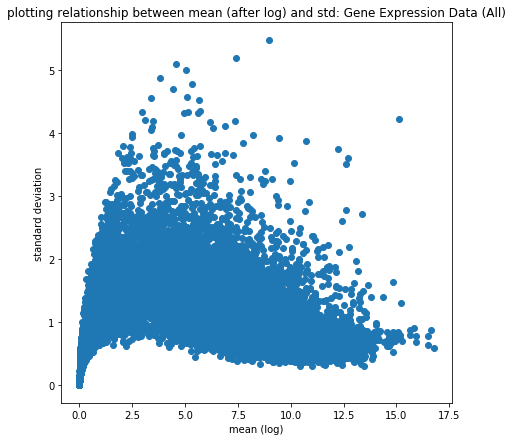

Partial dataframe: primary tumor samples only:


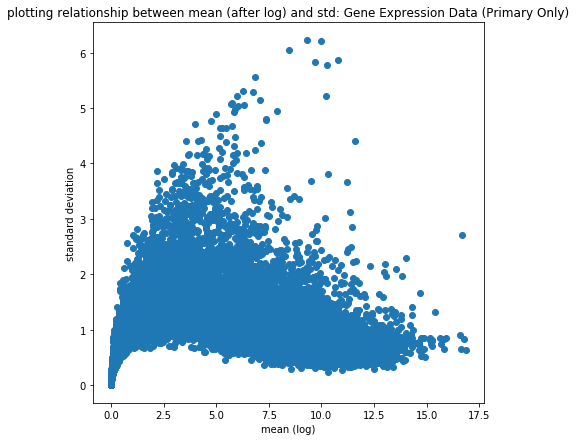

Partial dataframe: metastases samples only:


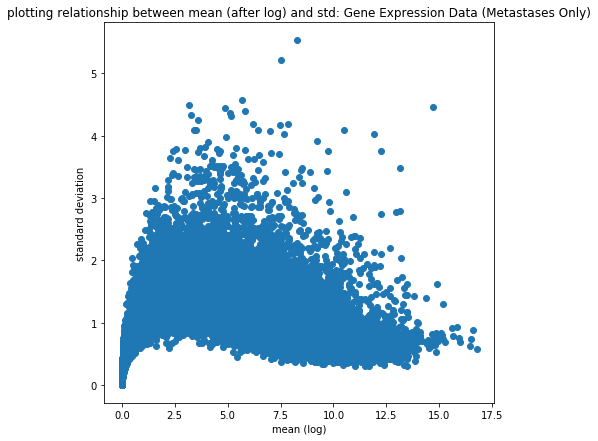

Transforming to str index.


In [106]:
# prep gene expression data for differential expression analysis and graph log mean vs std

titles = ['Gene Expression Data (All)', 'Gene Expression Data (Primary Only)', 'Gene Expression Data (Metastases Only)']
data_genes_new = create_data_to_find_highly_and_slightly_expressed('gene_data_without_immune', titles, 'gene')


Performing differential expression tests and displaying sample results

Running Welch's T-Test:

           gene      pval      qval    log2fc        mean
0        A1BG.1  0.001069  0.006129 -0.548340  294.801172
1   A2BP1.54715  0.385012  0.527449 -2.700799    4.697858
2   A2LD1.87769  0.073438  0.157597 -0.178384  101.314465
3  A2ML1.144568  0.000076  0.000781 -4.328338  251.987262
4  A4GALT.53947  0.008582  0.030361  0.417978  149.325830

Running Rank-Sum Test:

           gene          pval          qval    log2fc        mean
0        A1BG.1  1.003637e-05  9.238240e-05 -0.548340  294.801172
1   A2BP1.54715  6.614095e-01  7.563578e-01 -2.700799    4.697858
2   A2LD1.87769  3.563117e-02  7.907584e-02 -0.178384  101.314465
3  A2ML1.144568  7.830184e-15  7.250656e-13 -4.328338  251.987262
4  A4GALT.53947  5.930723e-01  7.026717e-01  0.417978  149.325830

Printing MA plot: shows log2-fold changes vs mean expression


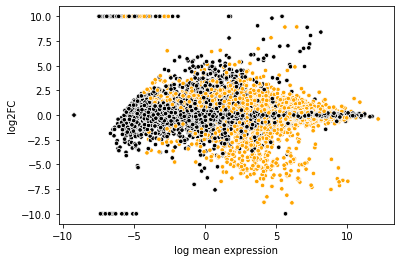


Graphing volcano plot: shows log fold change vs p-value

T-Test volcano plot:



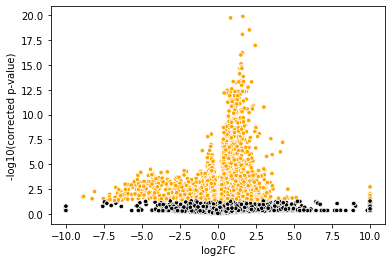

Rank-Sum test volcano plot:



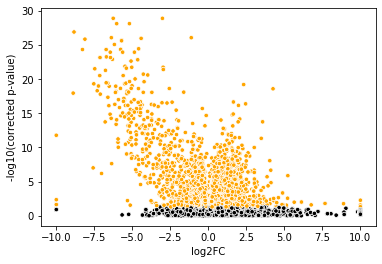

Graphing log10_pval for t-test (x axis) vs log10_pval for rank sum test (y axis)


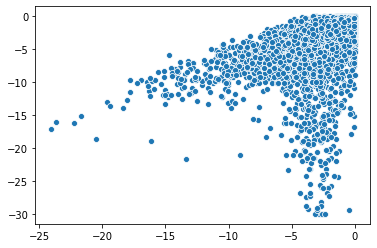


Determining which genes are highly/slightly expressed using:
p-value: 0.01 or lower
log2FoldChange: 7.5 or greater for highly expressed, -7.5 or lower for slightly expressed

T-Test Results:

Highly Expressed Genes:



gene      pval      qval       log2fc      mean  \
4366       FAM138B.654412  0.000246  0.001935  1069.610675  0.037283   
5135             GIP.2695  0.009081  0.031677  1069.524744  0.035127   
7252     LOC154449.154449  0.004802  0.019445  1068.655280  0.019227   
7329     LOC285375.285375  0.003603  0.015551  1067.974434  0.011994   
7580     LOC730811.730811  0.002410  0.011549  1067.552621  0.008953   
9306        OR11G2.390439  0.008949  0.031294  1066.841179  0.005468   
9356        OR2A12.346525  0.001657  0.008613  1067.636551  0.009489   
10234        PLGLA.285189  0.004218  0.017572  1067.510231  0.008694   
12600  SNORA38B.100124536  0.002061  0.010229  1068.005334  0.012253   
13446        TAS2R7.50837  0.003309  0.014630  1068.183079  0.013860   
14268           TSHB.7252  0.007413  0.027141  1067.549333  0.008933   

       zero_mean  zero_variance  
4366       False          False  
5135       False          False  
7252       False          False  
7329       False          False  
7580       False          False  
9306       False          False  
9356       False          False  
10234      False          False  
12600      False          False  
13446      False          False  
14268      False          False


Slightly Expressed Genes:



gene      pval      qval    log2fc         mean  zero_mean  \
6764     KRT6C.286887  0.008132  0.029169 -7.534058  6895.910799      False   
6935     LCE3E.353145  0.008471  0.030065 -8.277418    76.602001      False   
11630  S100A7A.338324  0.000986  0.005752 -8.116672   310.107806      False   
13052     SPRR2G.6706  0.005677  0.022214 -8.887956   444.402500      False   
14917   WFDC12.128488  0.004220  0.017578 -8.834378    62.517250      False   

       zero_variance  
6764           False  
6935           False  
11630          False  
13052          False  
14917          False


Rank-Sum Results:

Highly Expressed Genes:



gene      pval      qval       log2fc         mean  \
1810   C20orf70.140683  0.004872  0.015445     7.671862    59.939656   
3288         CSN2.1447  0.001305  0.005176    10.984137     5.933407   
4366    FAM138B.654412  0.009415  0.026647  1069.610675     0.037283   
13194       STATH.6779  0.005379  0.016783     8.890804  1297.589287   

       zero_mean  zero_variance  
1810       False          False  
3288       False          False  
4366       False          False  
13194      False          False


Slightly Expressed Genes:



gene          pval          qval       log2fc         mean  \
6764     KRT6C.286887  1.366750e-22  4.915214e-20    -7.534058  6895.910799   
6783        KRT9.3857  1.957202e-14  1.653889e-12   -10.870980   282.939480   
6932     LCE3B.353143  7.532479e-03  2.216177e-02 -1068.863119     0.006215   
6933     LCE3C.353144  3.264622e-09  9.641079e-08    -7.575577     2.002315   
6935     LCE3E.353145  4.946981e-28  4.781257e-25    -8.277418    76.602001   
9468      OR4P4.81300  7.532479e-03  2.216177e-02 -1068.002888     0.003424   
9557     OR5L1.219437  7.532479e-03  2.216177e-02 -1067.005570     0.001715   
11630  S100A7A.338324  8.537951e-30  1.467010e-26    -8.116672   310.107806   
11742  SCGB1D4.404552  7.532479e-03  2.216177e-02 -1069.215766     0.007936   
12944  SPAG11A.653423  1.045823e-03  4.302371e-03 -1067.747207     0.002868   
13052     SPRR2G.6706  4.605457e-21  1.130457e-18    -8.887956   444.402500   
14917   WFDC12.128488  4.176581e-31  1.291733e-27    -8.834378    62.517250   

       zero_mean  zero_variance  
6764       False          False  
6783       False          False  
6932       False          False  
6933       False          False  
6935       False          False  
9468       False          False  
9557       False          False  
11630      False          False  
11742      False          False  
12944      False          False  
13052      False          False  
14917      False          False


Overall highly expresed:


gene    pval_x     log2fc_x    mean_x    pval_y  \
0       FAM138B.654412  0.000246  1069.610675  0.037283  0.009415   
1             GIP.2695  0.009081  1069.524744  0.035127       NaN   
2     LOC154449.154449  0.004802  1068.655280  0.019227       NaN   
3     LOC285375.285375  0.003603  1067.974434  0.011994       NaN   
4     LOC730811.730811  0.002410  1067.552621  0.008953       NaN   
5        OR11G2.390439  0.008949  1066.841179  0.005468       NaN   
6        OR2A12.346525  0.001657  1067.636551  0.009489       NaN   
7         PLGLA.285189  0.004218  1067.510231  0.008694       NaN   
8   SNORA38B.100124536  0.002061  1068.005334  0.012253       NaN   
9         TAS2R7.50837  0.003309  1068.183079  0.013860       NaN   
10           TSHB.7252  0.007413  1067.549333  0.008933       NaN   
11     C20orf70.140683       NaN          NaN       NaN  0.004872   
12           CSN2.1447       NaN          NaN       NaN  0.001305   
13          STATH.6779       NaN          NaN       NaN  0.005379   

       log2fc_y       mean_y  
0   1069.610675     0.037283  
1           NaN          NaN  
2           NaN          NaN  
3           NaN          NaN  
4           NaN          NaN  
5           NaN          NaN  
6           NaN          NaN  
7           NaN          NaN  
8           NaN          NaN  
9           NaN          NaN  
10          NaN          NaN  
11     7.671862    59.939656  
12    10.984137     5.933407  
13     8.890804  1297.589287


Overall slightly expresed:


gene    pval_x  log2fc_x       mean_x        pval_y  \
0     KRT6C.286887  0.008132 -7.534058  6895.910799  1.366750e-22   
1     LCE3E.353145  0.008471 -8.277418    76.602001  4.946981e-28   
2   S100A7A.338324  0.000986 -8.116672   310.107806  8.537951e-30   
3      SPRR2G.6706  0.005677 -8.887956   444.402500  4.605457e-21   
4    WFDC12.128488  0.004220 -8.834378    62.517250  4.176581e-31   
5        KRT9.3857       NaN       NaN          NaN  1.957202e-14   
6     LCE3B.353143       NaN       NaN          NaN  7.532479e-03   
7     LCE3C.353144       NaN       NaN          NaN  3.264622e-09   
8      OR4P4.81300       NaN       NaN          NaN  7.532479e-03   
9     OR5L1.219437       NaN       NaN          NaN  7.532479e-03   
10  SCGB1D4.404552       NaN       NaN          NaN  7.532479e-03   
11  SPAG11A.653423       NaN       NaN          NaN  1.045823e-03   

       log2fc_y       mean_y  
0     -7.534058  6895.910799  
1     -8.277418    76.602001  
2     -8.116672   310.107806  
3     -8.887956   444.402500  
4     -8.834378    62.517250  
5    -10.870980   282.939480  
6  -1068.863119     0.006215  
7     -7.575577     2.002315  
8  -1068.002888     0.003424  
9  -1067.005570     0.001715  
10 -1069.215766     0.007936  
11 -1067.747207     0.002868

In [107]:
# perform differential expression analysis and find hgihly/slightly expressed genes

highly_expressed_genes_06_vs_01_new, slightly_expressed_genes_06_vs_01_new = differential_expression_analysis(data_genes_new,
                                                                                                      'gene')


In [111]:
# the results contain the same genes, except some of the original genes are missing
# this is because we didn't change our limits for the log2foldchange and kept them the same

print("print missing genes\n")
print("highly expressed:")
for x in list(highly_expressed_genes_06_vs_01['gene']):
    if x not in list(highly_expressed_genes_06_vs_01_new['gene']):
        print("gene {} is related to the immune system and is now missing".format(x))

print("\nslightly expressed:")
for x in list(slightly_expressed_genes_06_vs_01['gene']):
    if x not in list(slightly_expressed_genes_06_vs_01_new['gene']):
        print("gene {} is related to the immune system and is now missing".format(x))
   



print missing genes

highly expressed:
gene SCGB1A1.7356 is related to the immune system and is now missing

slightly expressed:
gene DEFB4A.1673 is related to the immune system and is now missing
gene DEFB108B.245911 is related to the immune system and is now missing
